In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
Asset_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

#### Load Gaussian KDE timeseries

In [3]:
density_matrix_t_series = pickle.load(open(Asset_PATH  + 'density_matrix_t_series_100x100.pickle', 'rb'))

In [4]:
density_matrix_t_series.shape

(198, 100, 100)

In [5]:
print(np.max(density_matrix_t_series))
print(np.min(density_matrix_t_series))

2019.7794007598727
-2.393156546274511e-13


In [6]:
density_matrix_t_series.shape[0]

198

In [7]:
timesteps = 52

In [8]:
train, valid = (60,20)
test = 20

total_len = density_matrix_t_series.shape[0] - timesteps
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

In [9]:
flattened_matrix_np = np.reshape(density_matrix_t_series, 
                                 (density_matrix_t_series.shape[0],
                                  density_matrix_t_series.shape[1]*density_matrix_t_series.shape[2]))
flattened_matrix_np.shape

(198, 10000)

In [10]:
np.max(flattened_matrix_np[train_index])

1935.6194220503628

In [11]:
scaler_max = np.max(flattened_matrix_np[train_index])
scaler_min = np.min(flattened_matrix_np[train_index])

X_train = (flattened_matrix_np[train_index] - scaler_min)/(scaler_max - scaler_min)


In [12]:
X_train = X_train.reshape(X_train.shape[0],
                          1,    
                          X_train.shape[1])
X_train.shape

(87, 1, 10000)

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],int(X_train.shape[2]**(1/2)),int(X_train.shape[2]**(1/2)),1)
X_train.shape

(87, 1, 100, 100, 1)

In [14]:
print(np.max(X_train))
print(np.min(X_train))

1.0
0.0


#### We transform the whole train, valid, test based on scaler fitted on train

In [15]:
np.max(flattened_matrix_np)

2019.7794007598727

In [16]:
flattened_matrix_np.dtype

dtype('float64')

In [17]:
scaled_flattened_matrix = (flattened_matrix_np - scaler_min)/(scaler_max - scaler_min)

In [18]:
flattened_matrix_np.shape

(198, 10000)

In [19]:
scaled_flattened_matrix.shape

(198, 10000)

In [20]:
print(np.max(scaled_flattened_matrix))
print(np.min(scaled_flattened_matrix))

1.0434796105839654
-3.2227207716804404e-17


In [21]:
scaled_flattened_matrix.shape

(198, 10000)

In [22]:
def window_stack(a, stepsize=1, width=52):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [23]:
stacked = window_stack(scaled_flattened_matrix,1,timesteps)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
stacked.shape

(147, 520000)

In [25]:
reshape_stack = stacked.reshape(stacked.shape[0],timesteps,
                                int((stacked.shape[1]/timesteps)**(1/2)),
                                int((stacked.shape[1]/timesteps)**(1/2)),1)

In [26]:
reshape_stack.shape

(147, 52, 100, 100, 1)

#### We reshape to (sample, timestep, inputshape)

In [27]:
scaled_flattened_matrix = reshape_stack
scaled_flattened_matrix.shape

(147, 52, 100, 100, 1)

In [28]:
train, valid = (60,20)
test = 20

total_len = scaled_flattened_matrix.shape[0]
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

#### We set the target to be 7 days aggregated KDE or 1 single frame forward

In [29]:
X_train = scaled_flattened_matrix[np.array(train_index)]
Y_train = scaled_flattened_matrix[np.array(train_index)+1][:,-1,:]
Y_train = Y_train.reshape(Y_train.shape[0],int(Y_train.shape[1]*Y_train.shape[2]*Y_train.shape[3]))

In [30]:
X_valid = scaled_flattened_matrix[np.array(valid_index)]
Y_valid = scaled_flattened_matrix[np.array(valid_index)+1][:,-1,:]
Y_valid = Y_valid.reshape(Y_valid.shape[0],int(Y_valid.shape[1]*Y_valid.shape[2]*Y_valid.shape[3]))

In [31]:
X_test = scaled_flattened_matrix[np.array(test_index)]
Y_test = scaled_flattened_matrix[np.array(test_index)+1][:,-1,:]
Y_test = Y_test.reshape(Y_test.shape[0],int(Y_test.shape[1]*Y_test.shape[2]*Y_test.shape[3]))

In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(88, 52, 100, 100, 1)
(88, 10000)
(28, 52, 100, 100, 1)
(28, 10000)
(28, 52, 100, 100, 1)
(28, 10000)


In [33]:
import os, datetime
import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GaussianNoise, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, LSTM, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.layers import concatenate, Activation, Permute, Multiply, Lambda, Reshape, LeakyReLU, Attention


In [34]:
checkpoint_filepath = Asset_PATH+'checkpoints/'
print(checkpoint_filepath)

/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/


## FFT + Dense Layer out

In [39]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#Frequency Head
timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2, 1])(timeDist) #transpose for FFT. FFT library treats the last dimension as time
print('timeDist.shape',timeDist.shape)
fftLayer = Lambda(lambda x : tf.math.abs(tf.signal.rfft(x)))(timeDist) ## transform to frequency domain with TF
fftLayer  = Permute([2, 1], name="fft_out")(fftLayer)#transpose back for the following shape
print('fftLayer.shape',fftLayer.shape)  
#(None,num_of_frequencies,num_of_features)
#compress frequency domain data from 10000 to downsized dimension for attention
#Time distributed is now frequency distributed
timeDist4 = TimeDistributed(Dense(100))(fftLayer)
units = timeDist4.shape[2]

Dense_out2 = TimeDistributed(Dense(3, activation='relu'))(timeDist4)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense_out2))
outputs = Dense2

model = Model(inputs, outputs, name="Attention_FFT")
model.summary()

adam = optimizers.Adam(lr)
#rmsProp = optimizers.RMSprop(learning_rate=lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


timeDist.shape (None, 10000, 52)
fftLayer.shape (None, 27, 10000)
Model: "Attention_FFT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 52, 10000)         0         
_________________________________________________________________
permute_2 (Permute)          (None, 10000, 52)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 10000, 27)         0         
_________________________________________________________________
fft_out (Permute)            (None, 27, 10000)         0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 27, 100)           1000100   
_____________________________________________________

#### FFT + Attention vs FFT + Dense layer out have identical MAE. This proves attention is not needed for frequency domain data.

# TimeDistributed Attention on Pixels

In [287]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2,1])(timeDist) #3D transpose between pixel and time dimension
units = timeDist.shape[2]
# compute importance for each step
#q^TxWxk_i, W is a projection of dimensions if key is different dimension from the query k_i.
attention1 = Dense(units, activation='tanh',name="W")(timeDist) ## weight matrix W (= units_key x units_project)
attention1 = Dense(1, activation='linear',name ="Query")(attention1) ## weight matrix v (= units x 1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax',name='attention1_weights')(attention1)
attention1 = RepeatVector(units)(attention1)
attention1 = Permute([2, 1])(attention1)
attention1 = Multiply()([timeDist, attention1])
attention1 = Permute([2, 1])(attention1) #transpose back to time being shape[1]
#attended_Dense_out1 = TimeDistributed(Dense(3, activation='relu'))(attention1)

attended_Dense_out = TimeDistributed(Dense(1, activation='relu'))(attention1 )

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2


model = Model(inputs, outputs, name="TimeDistributed_attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "TimeDistributed_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_104 (TimeDistr (None, 52, 10000)    0           input_45[0][0]                   
__________________________________________________________________________________________________
permute_160 (Permute)           (None, 10000, 52)    0           time_distributed_104[0][0]       
__________________________________________________________________________________________________
W (Dense)                       (None, 10000, 52)    2756        permute_160[0][0]                
__________________________________________________________________________

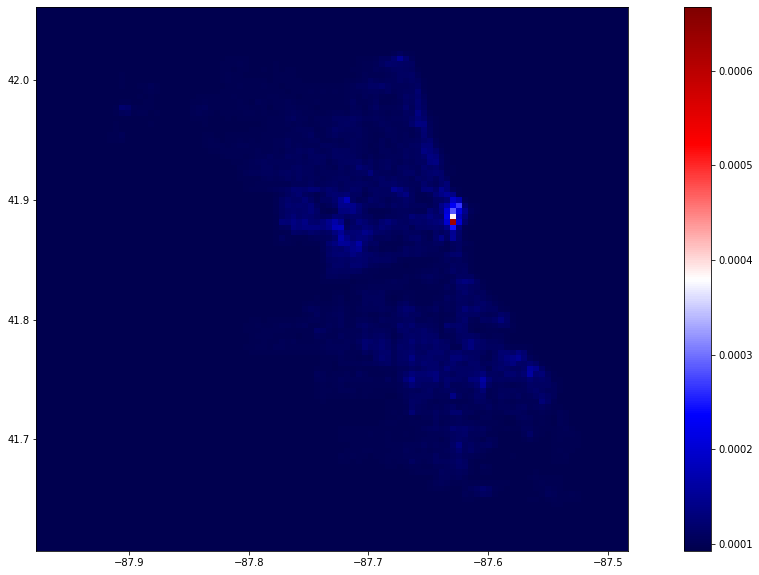

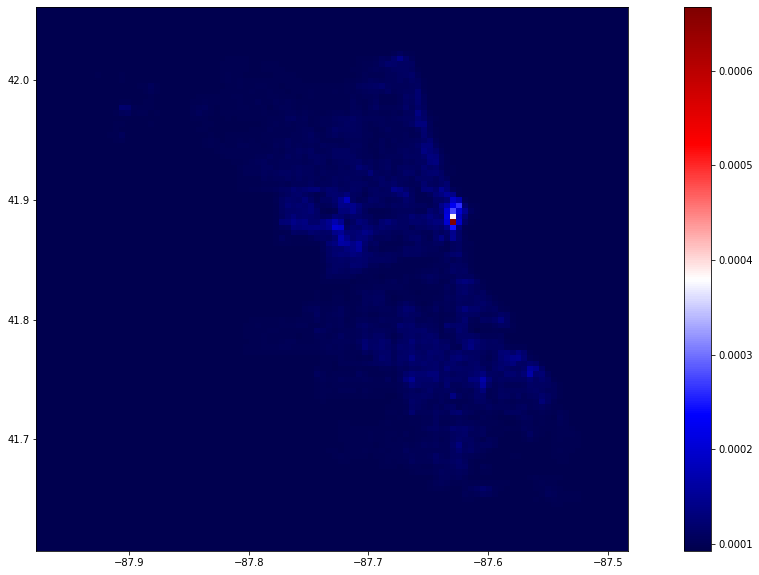

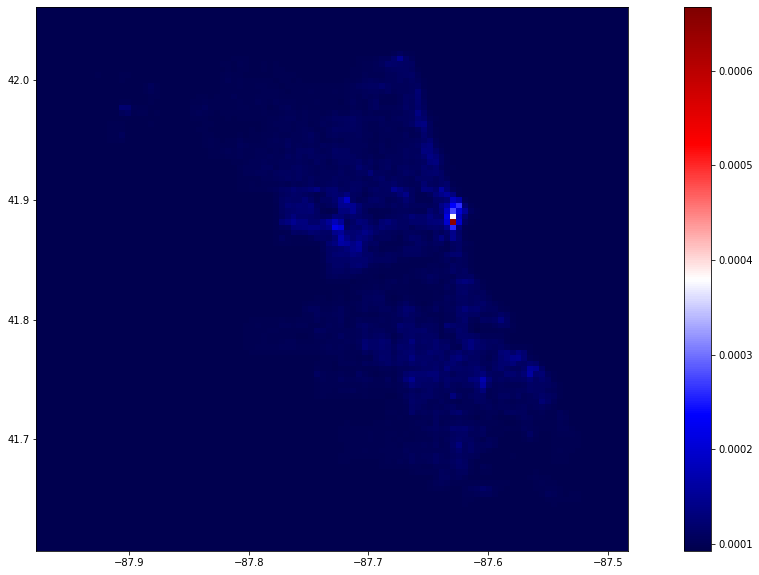

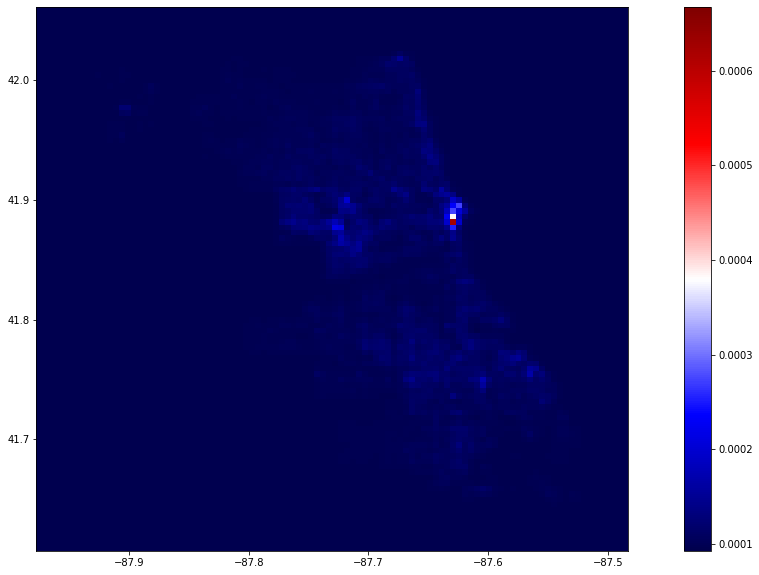

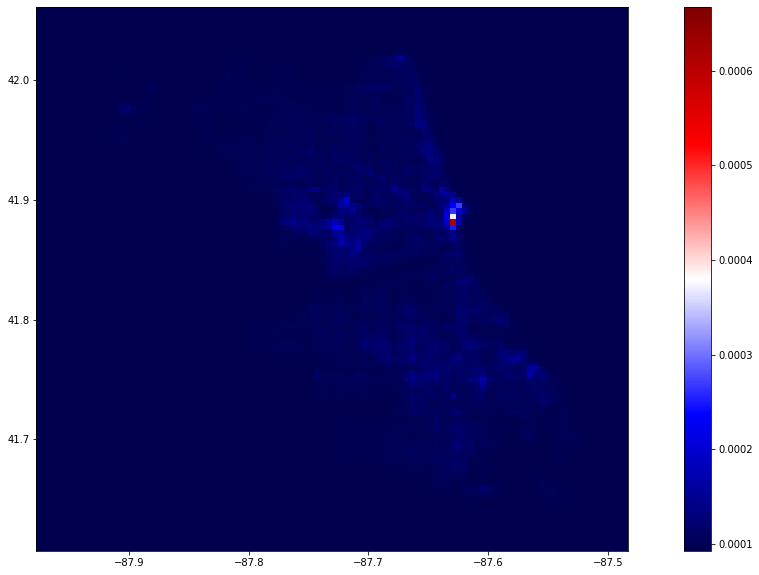

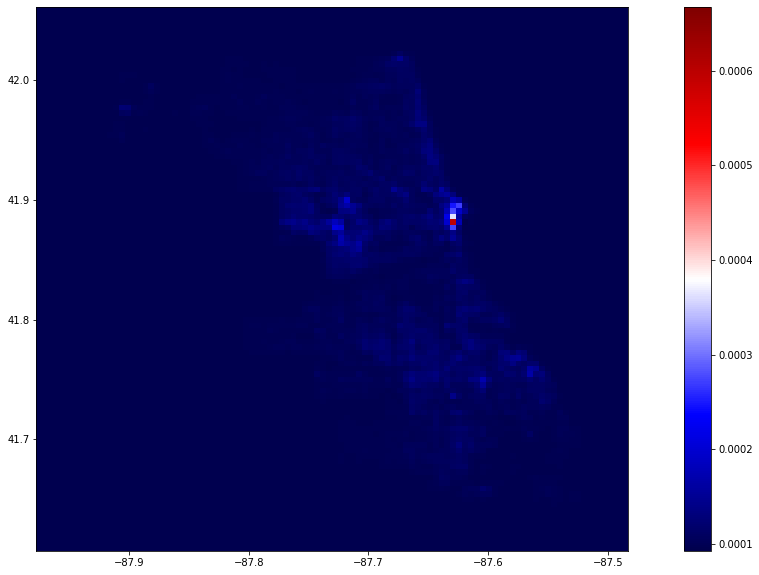

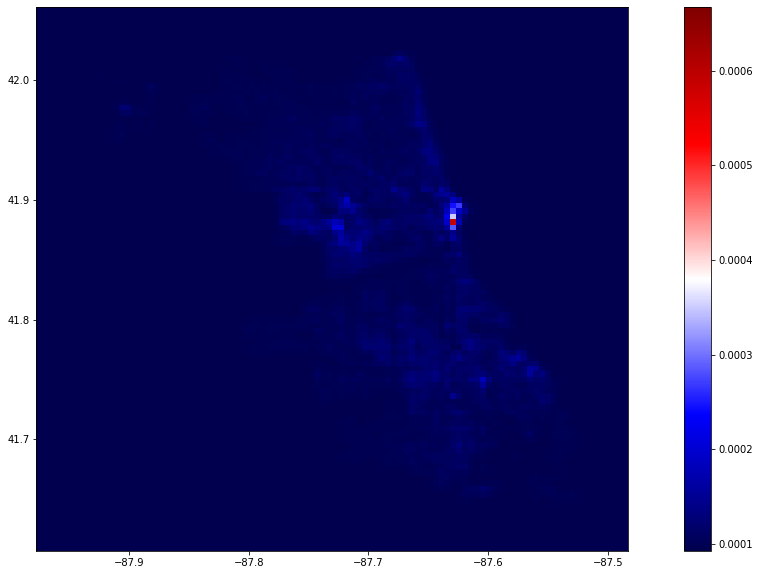

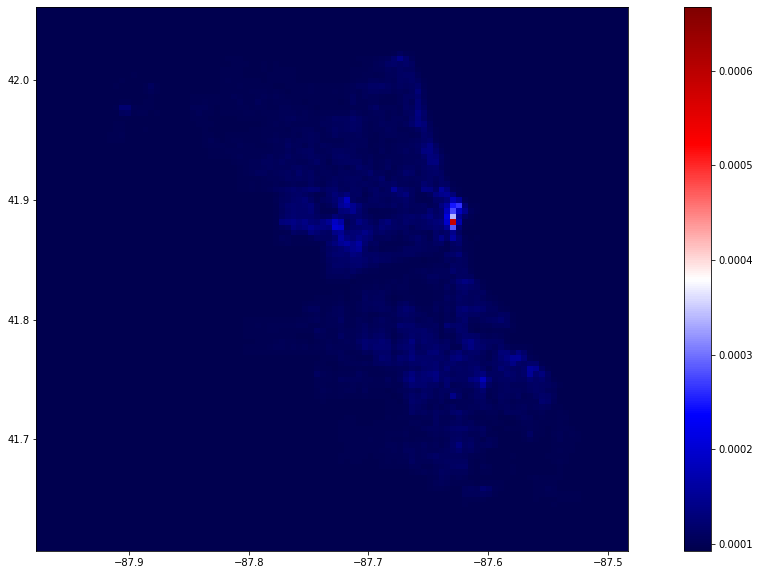

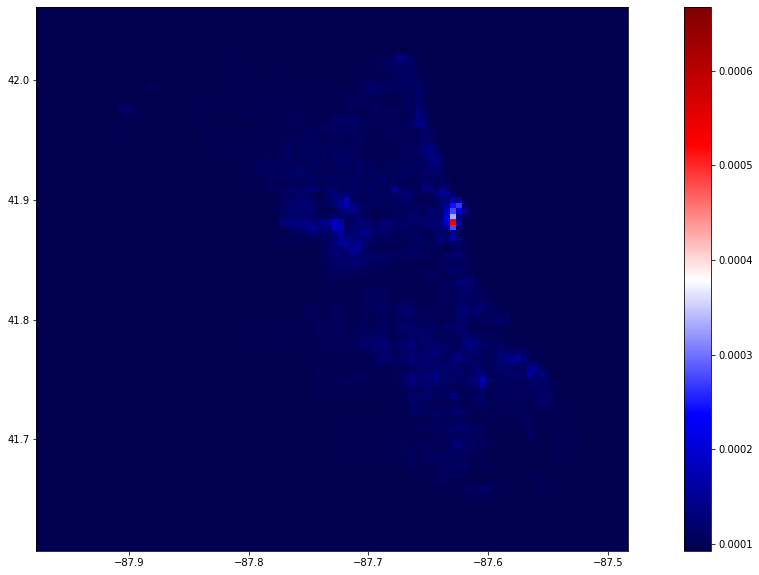

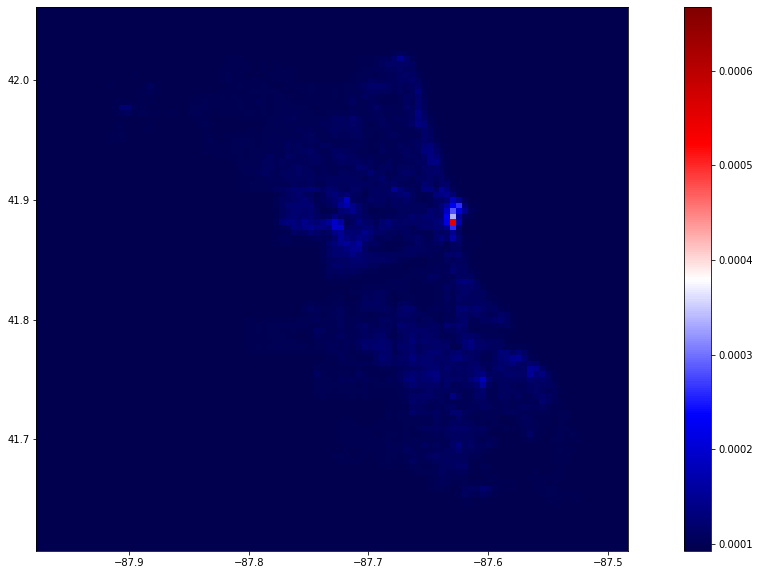

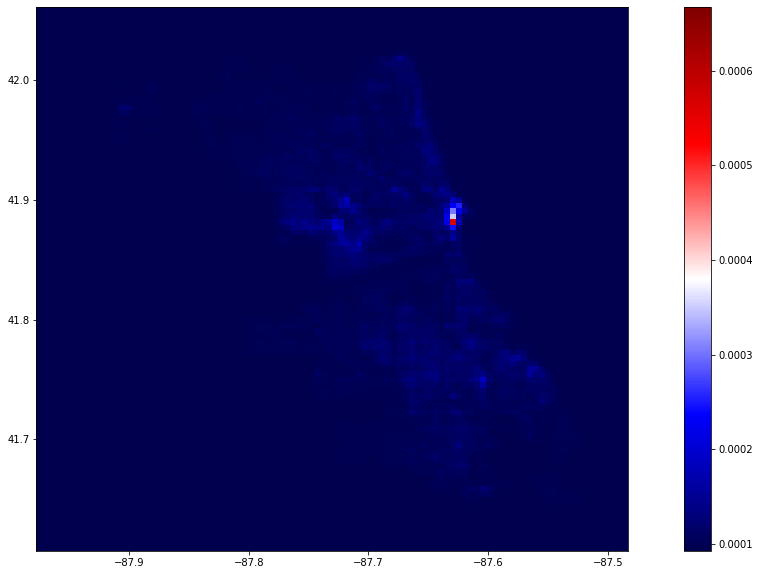

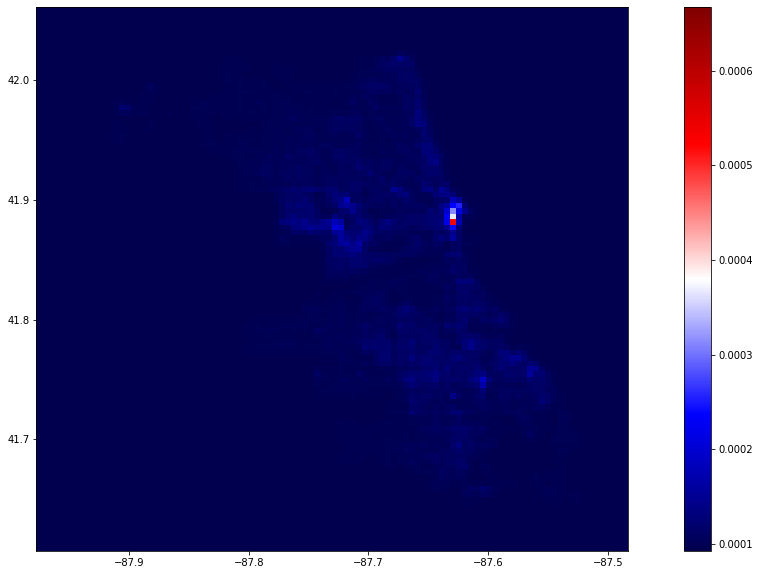

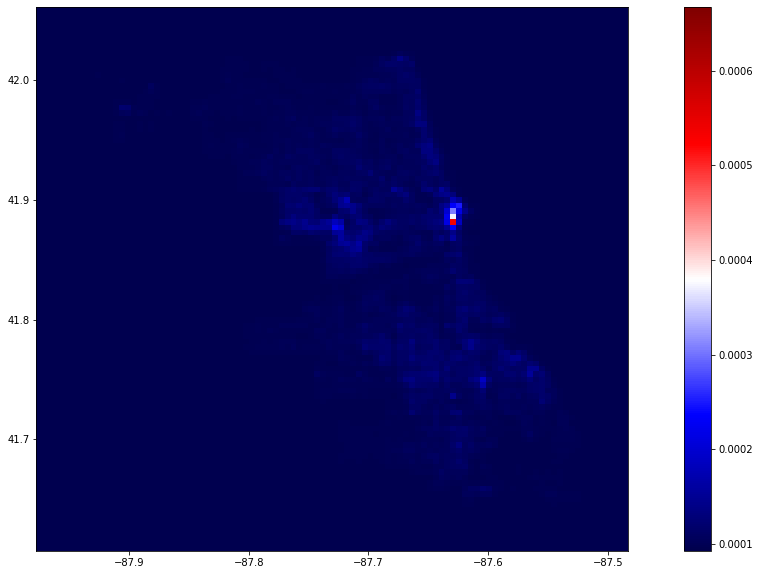

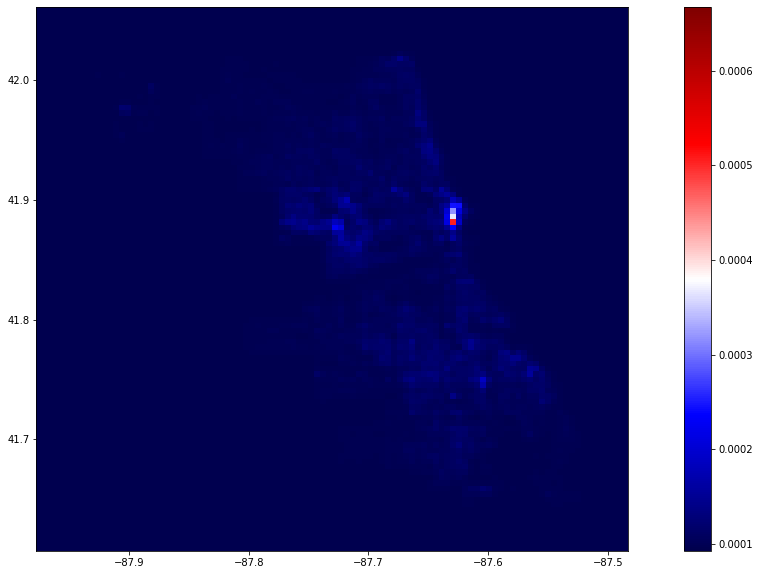

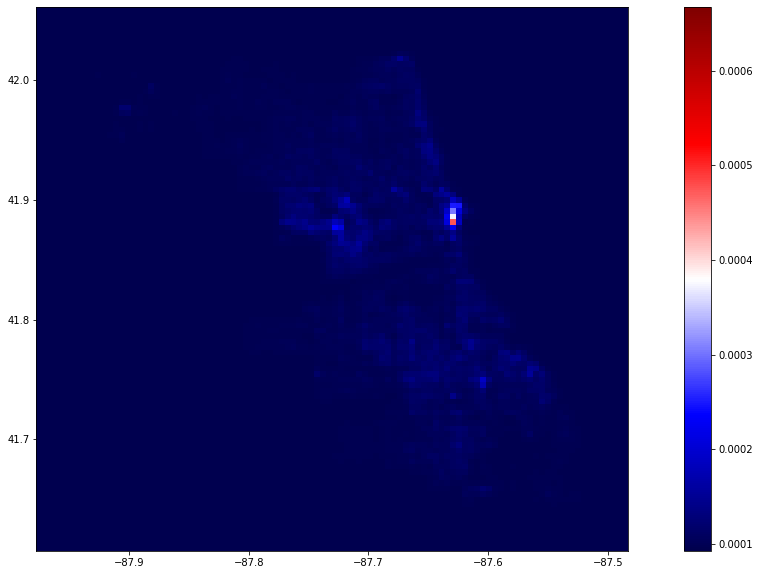

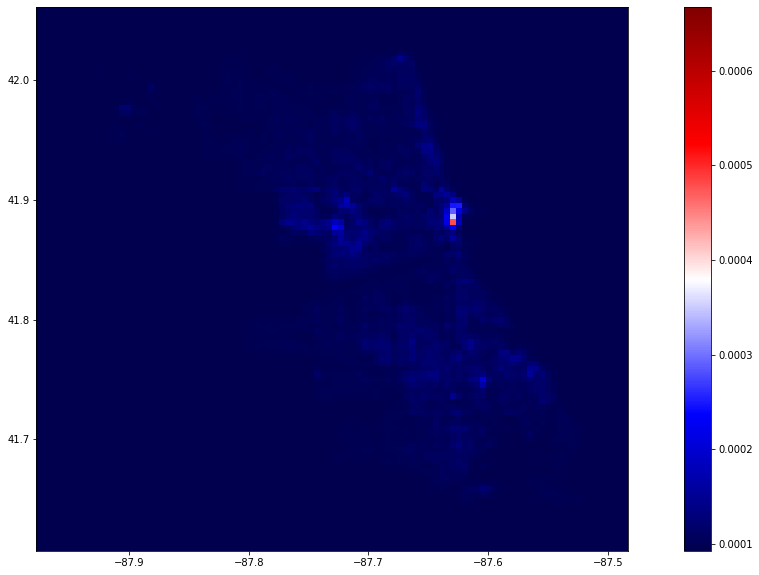

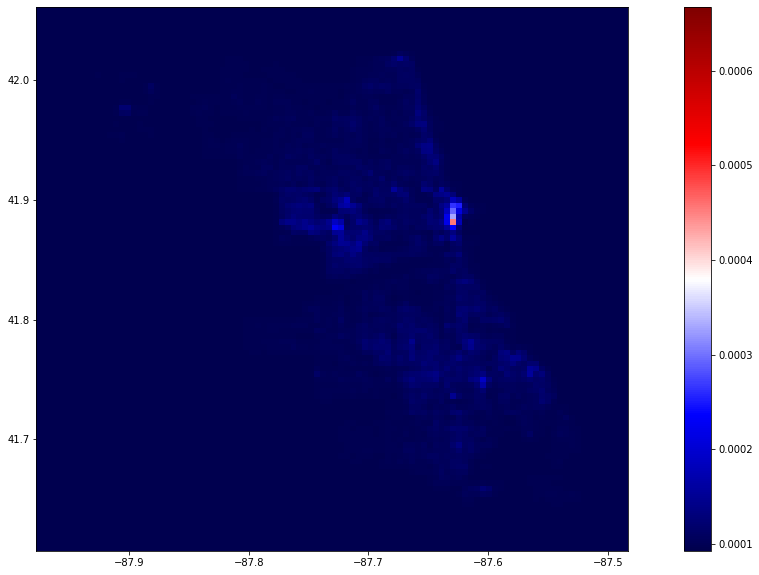

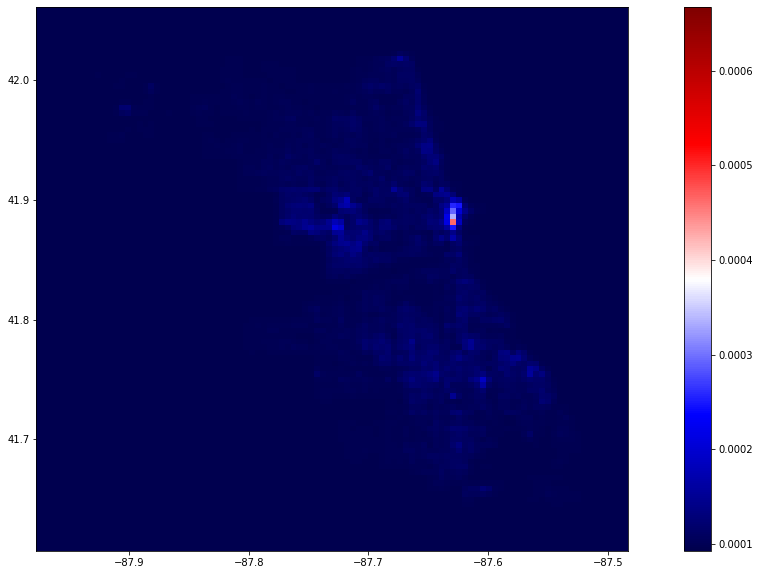

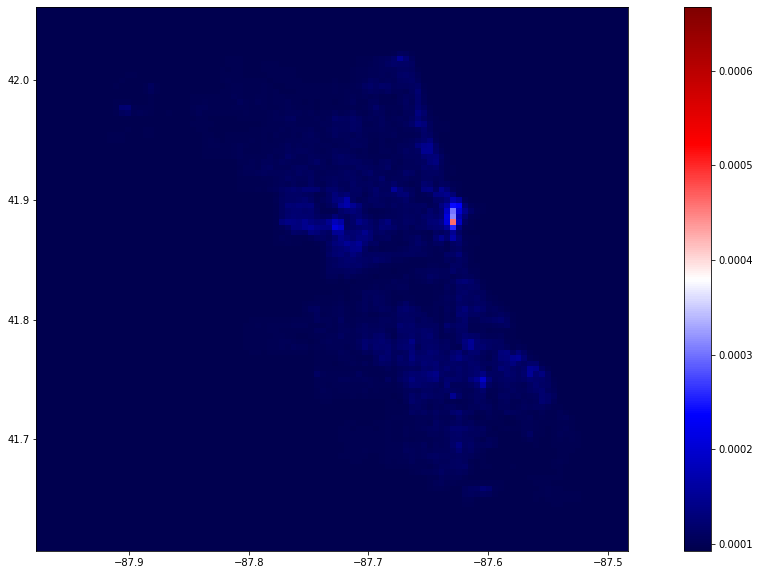

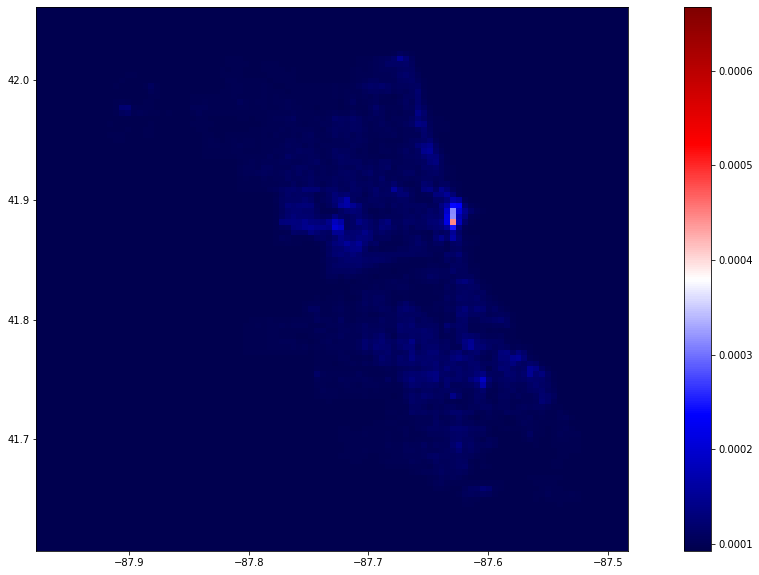

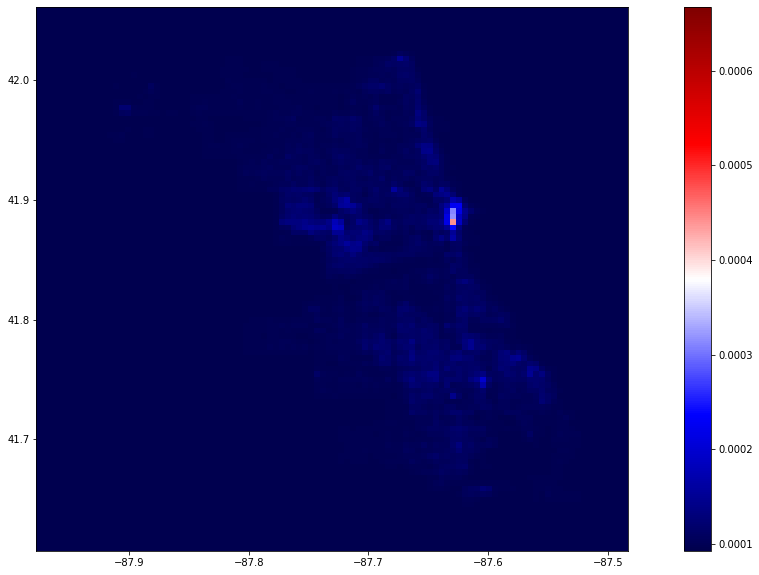

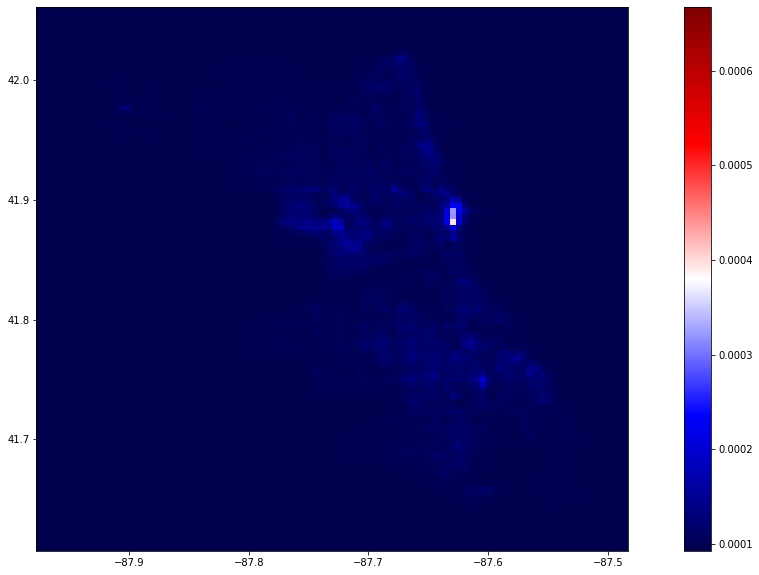

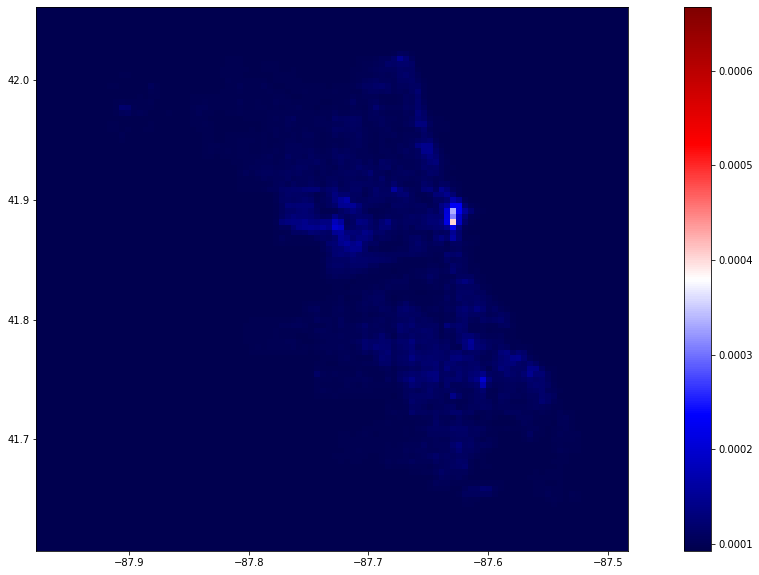

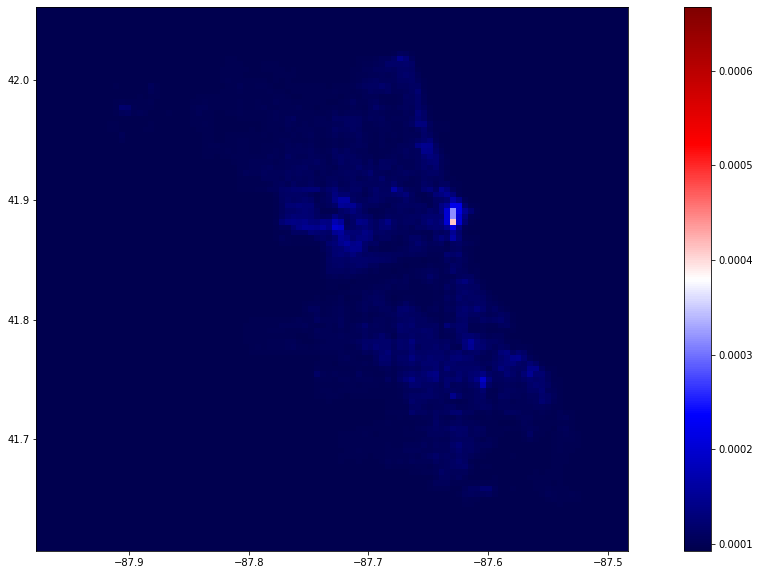

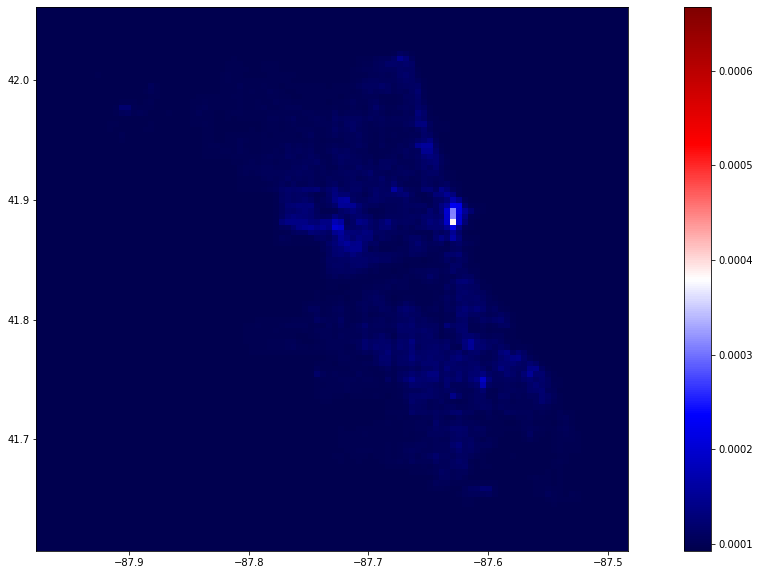

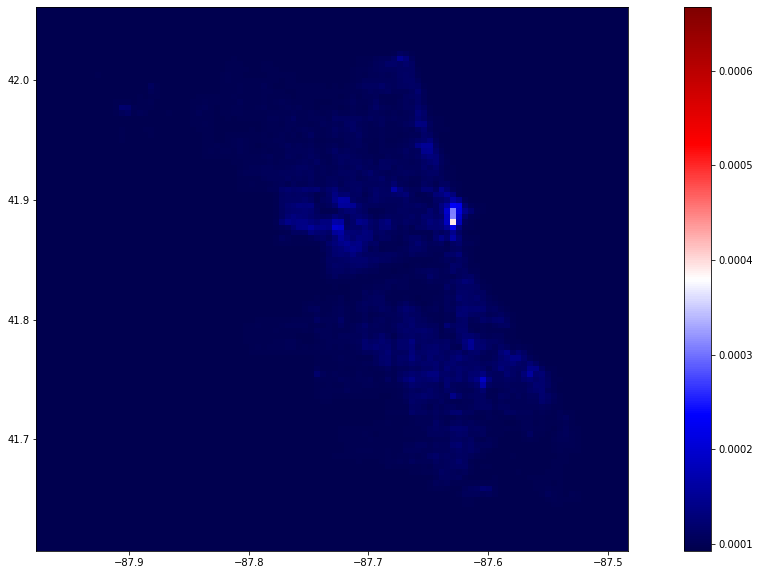

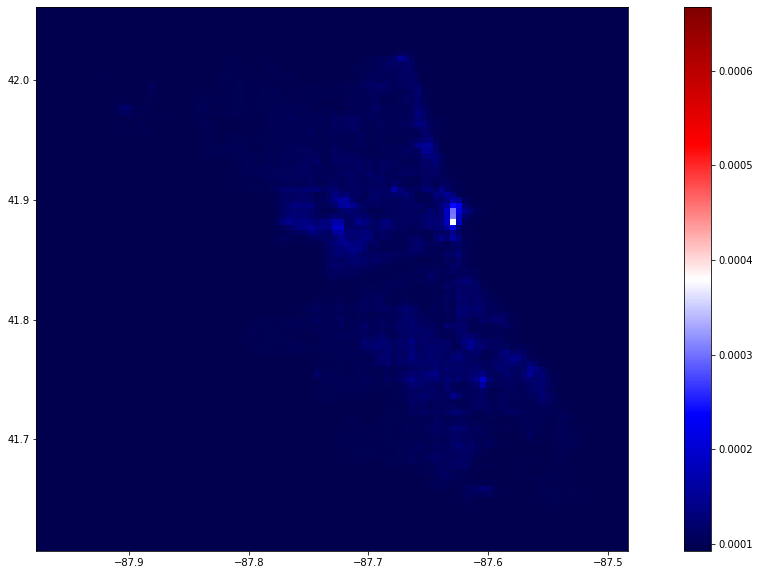

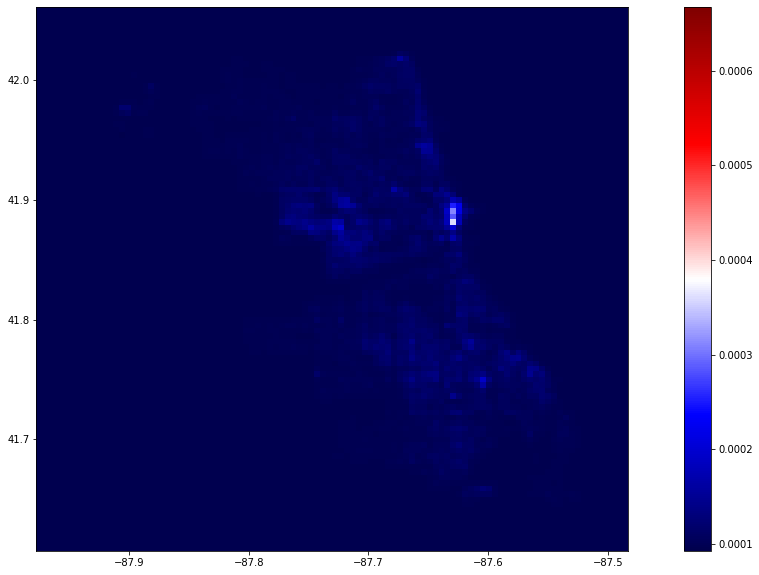

In [292]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention1_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

vmax,vmin = np.max(intermediate_layer_model.predict(X_valid)),np.min(intermediate_layer_model.predict(X_valid))

x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    #print(intermediate_output.shape)
    attImage = intermediate_output[0,:].reshape(100,100)
    #print(attImage.shape)
    plt.figure(figsize=(20,10))
    plt.imshow( X=np.rot90(attImage),vmin=vmin, vmax=vmax,cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    plt.show()

## TimeDistributed attention + attention on time

In [293]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2,1])(timeDist) #3D transpose between pixel and time dimension
units = timeDist.shape[2]
# compute importance for each step
#q^TxWxk_i, W is a projection of dimensions if key is different dimension from the query k_i.
attention1 = Dense(units, activation='tanh')(timeDist) ## weight matrix W (= units_key x units_project)
attention1 = Dense(1, activation='linear')(attention1)     ## weight matrix v (= units x 1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax',name='attention1_weights')(attention1)
attention1 = RepeatVector(units)(attention1)
attention1 = Permute([2, 1])(attention1)
attention1 = Multiply()([timeDist, attention1])
attention1 = Permute([2, 1])(attention1) #transpose back to time being shape[1]
print(attention1.shape)
timeDist2 = TimeDistributed(Dense(1000))(attention1)
units = timeDist2.shape[2]
# compute importance for each step
attention2 = Dense(units/10, activation='tanh')(timeDist2) ## weight matrix W (= units x units/10) dimension reduction with W
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax',name='attention2_weights')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation = Multiply()([timeDist2, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2

model = Model(inputs, outputs, name="TimeDistributed_attention1_plus_attention2_on_time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


(None, 52, 10000)
Model: "TimeDistributed_attention1_plus_attention2_on_time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_106 (TimeDistr (None, 52, 10000)    0           input_46[0][0]                   
__________________________________________________________________________________________________
permute_163 (Permute)           (None, 10000, 52)    0           time_distributed_106[0][0]       
__________________________________________________________________________________________________
dense_212 (Dense)               (None, 10000, 52)    2756        permute_163[0][0]                
_______________________________

In [295]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention1_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

#### We peak at trained attention1 on the image layer

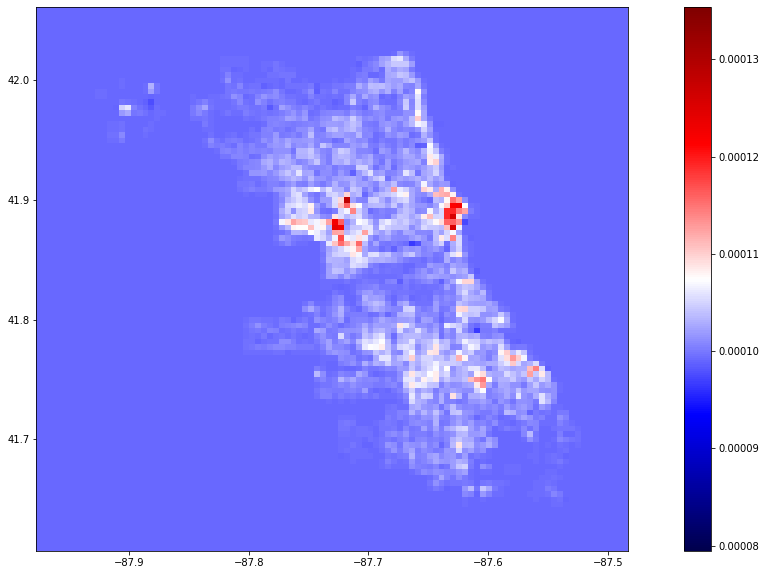

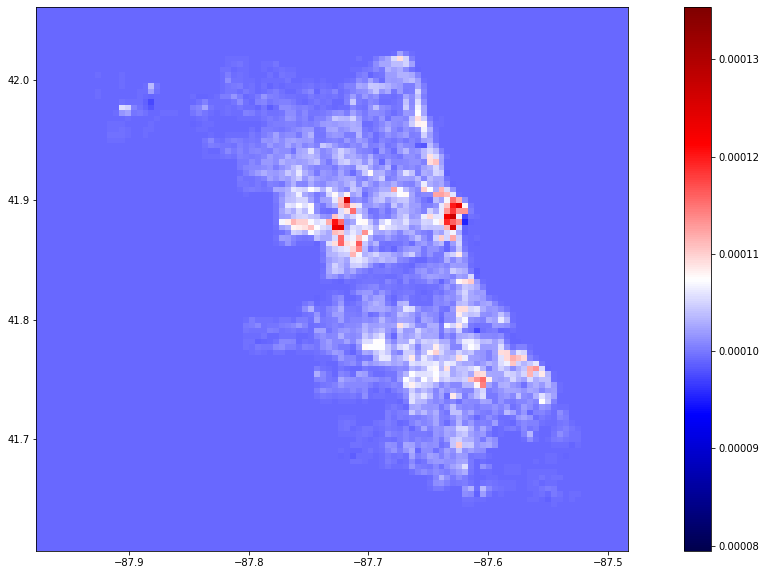

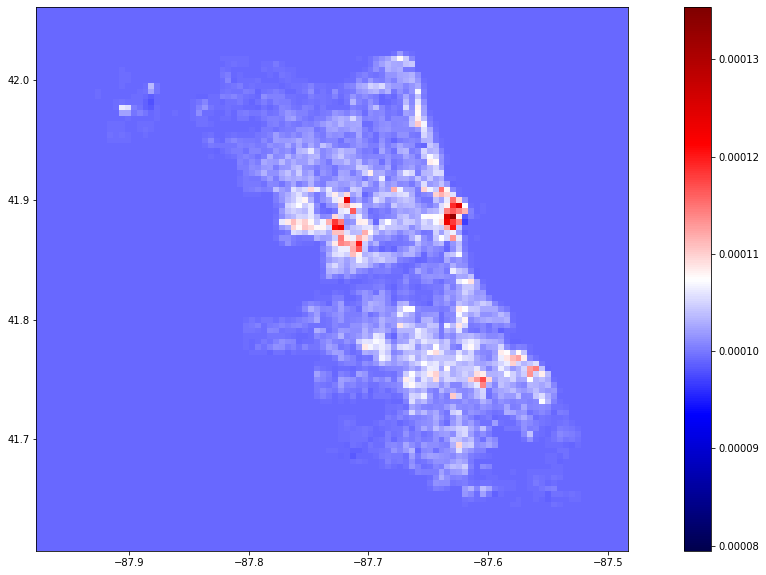

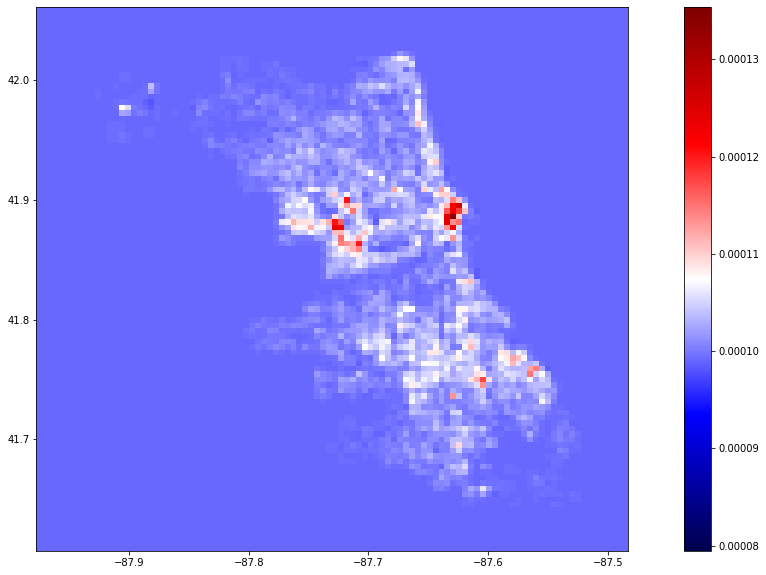

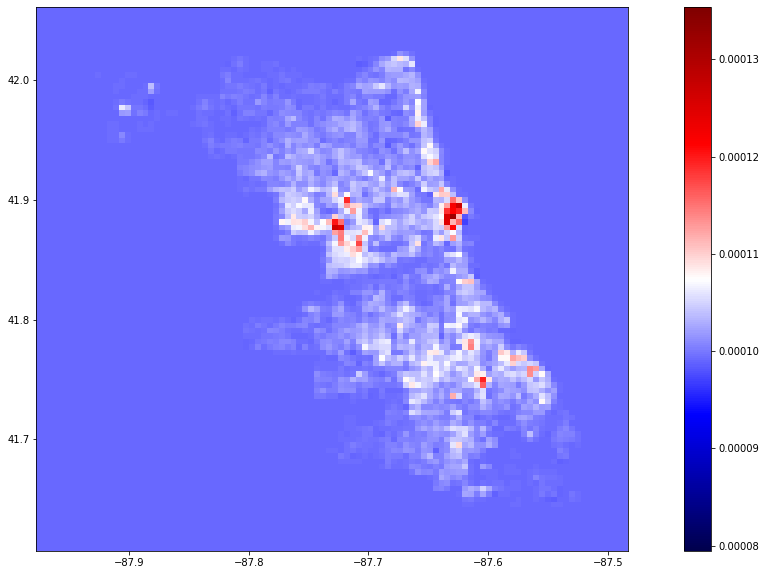

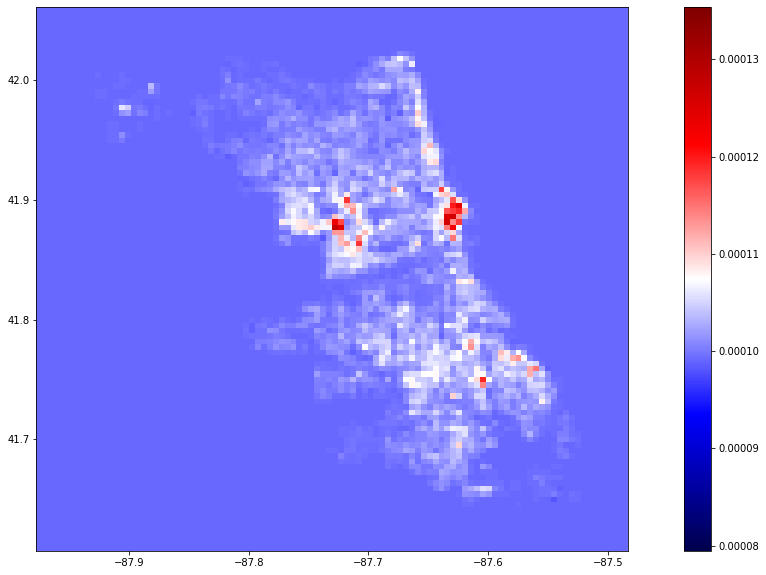

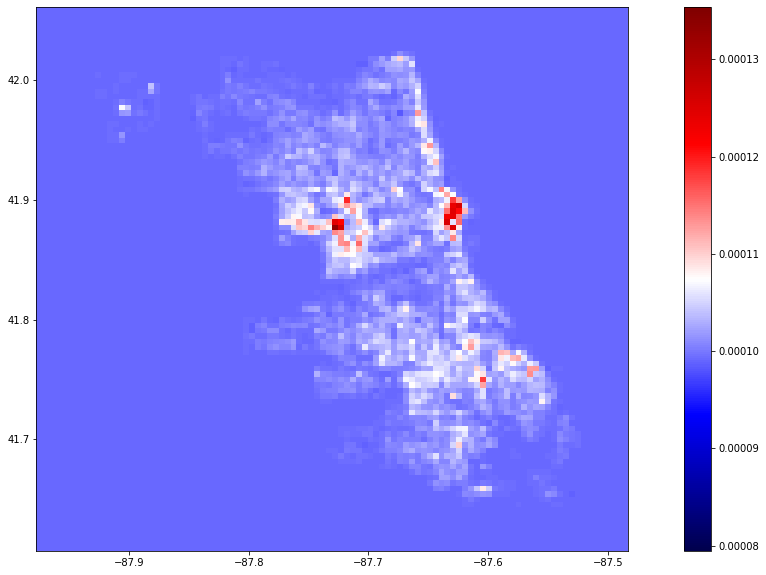

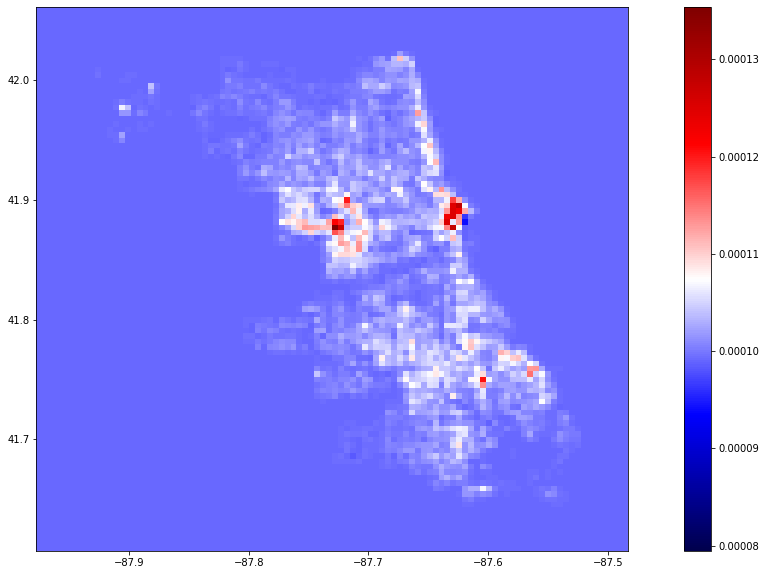

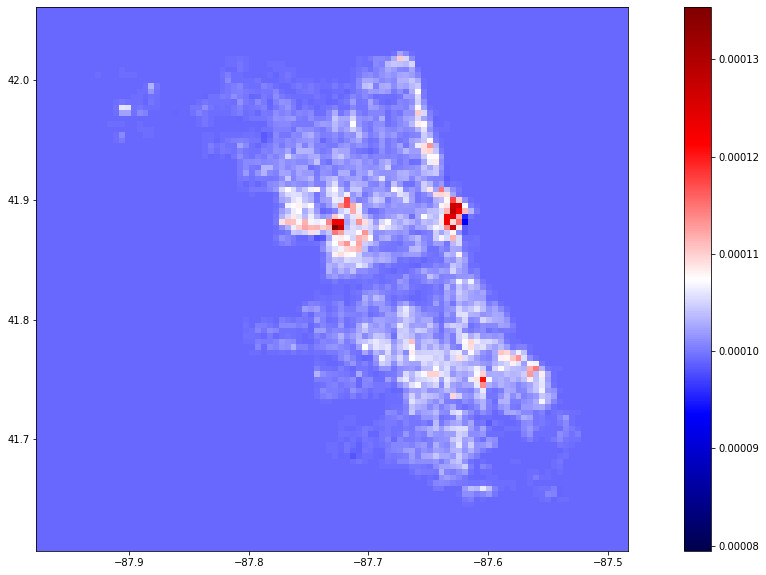

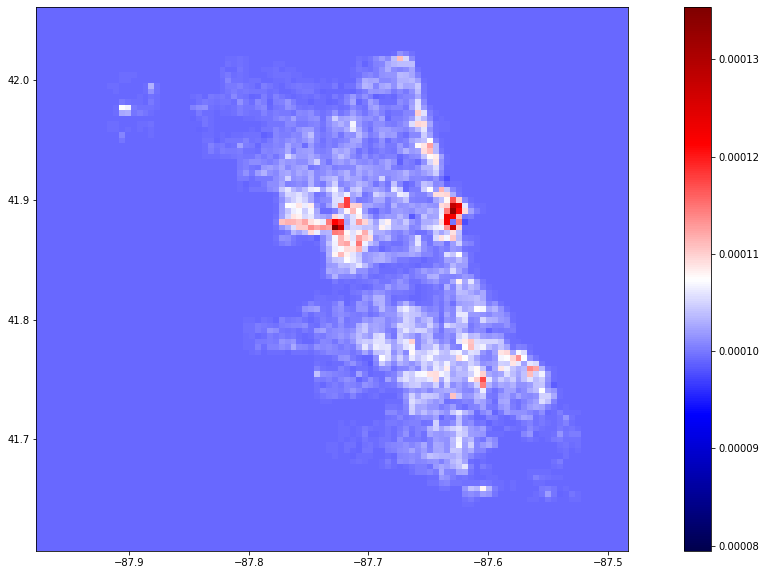

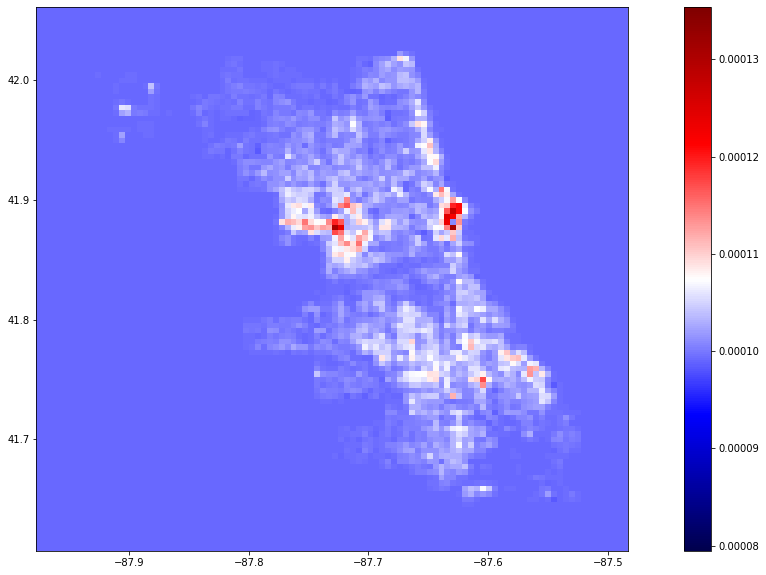

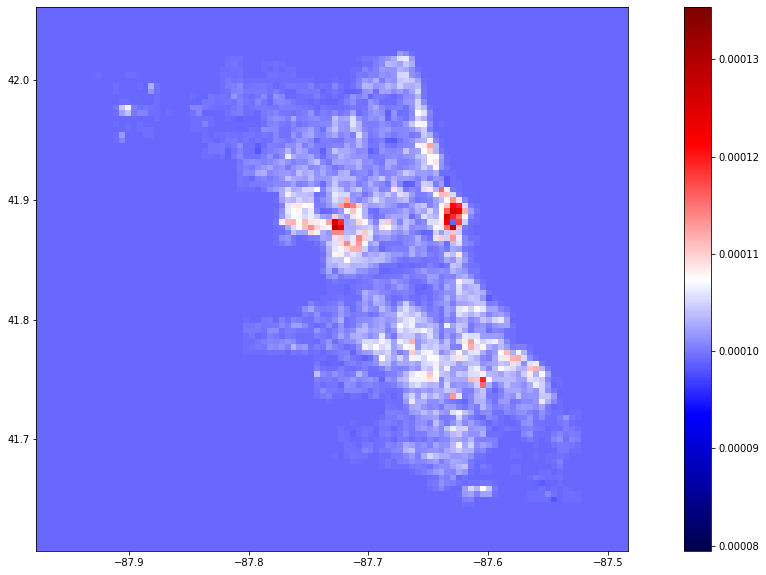

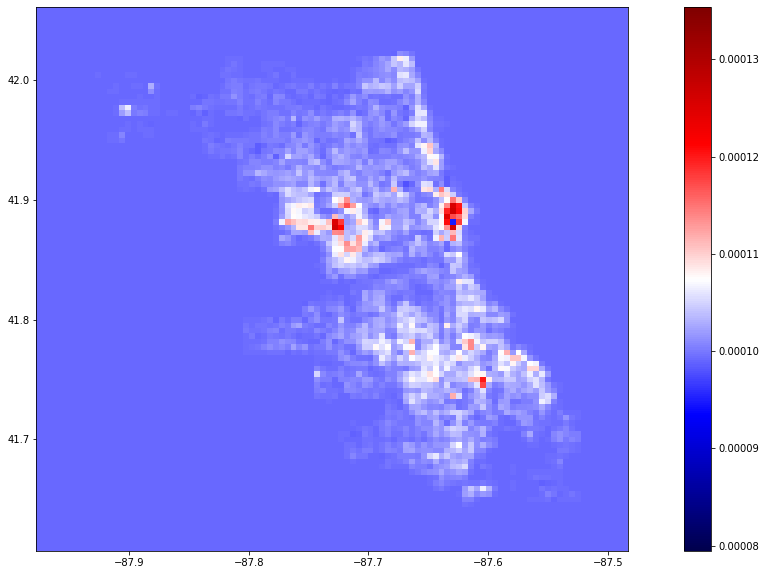

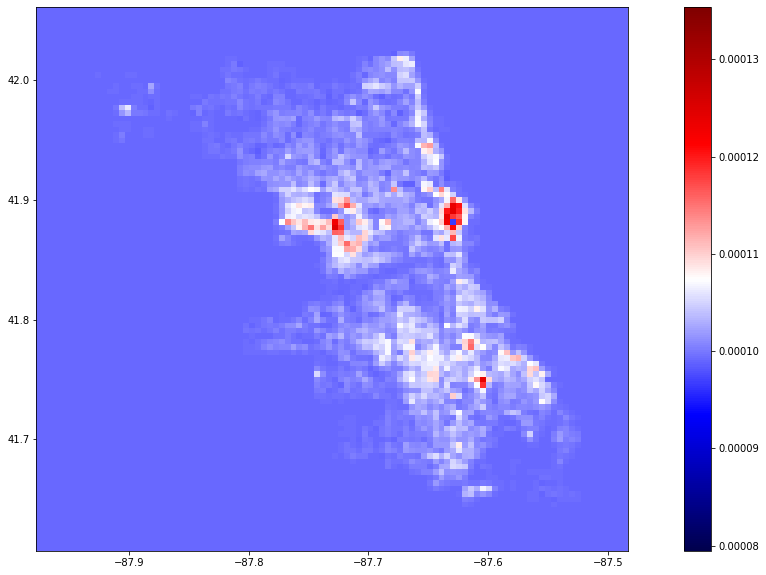

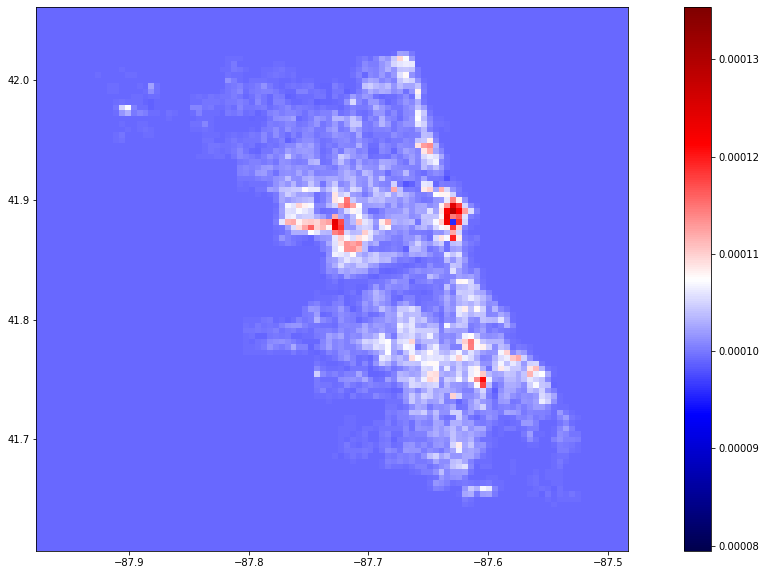

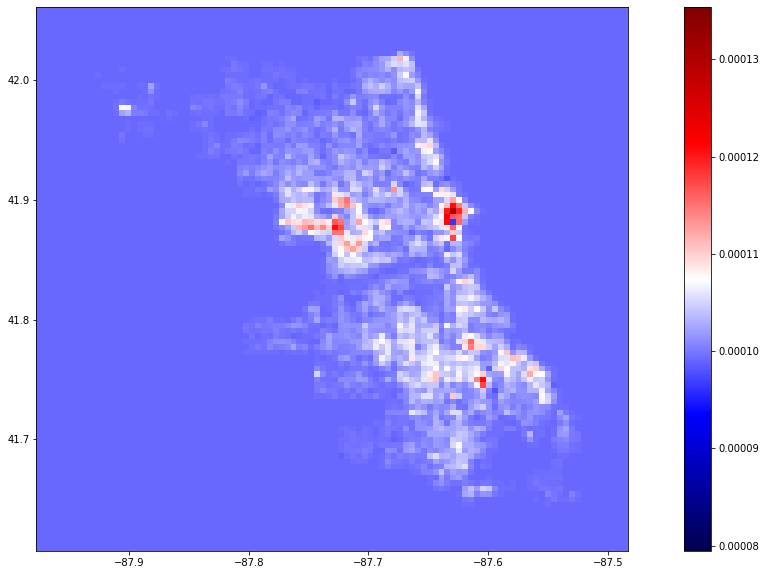

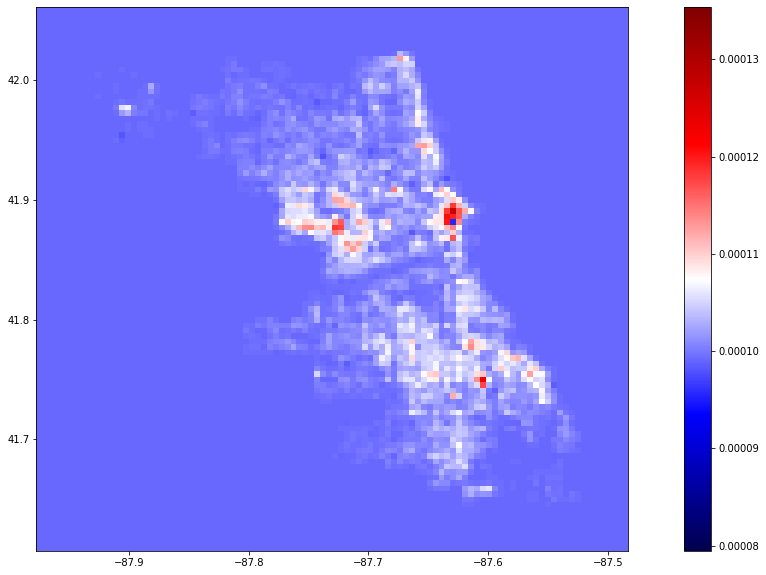

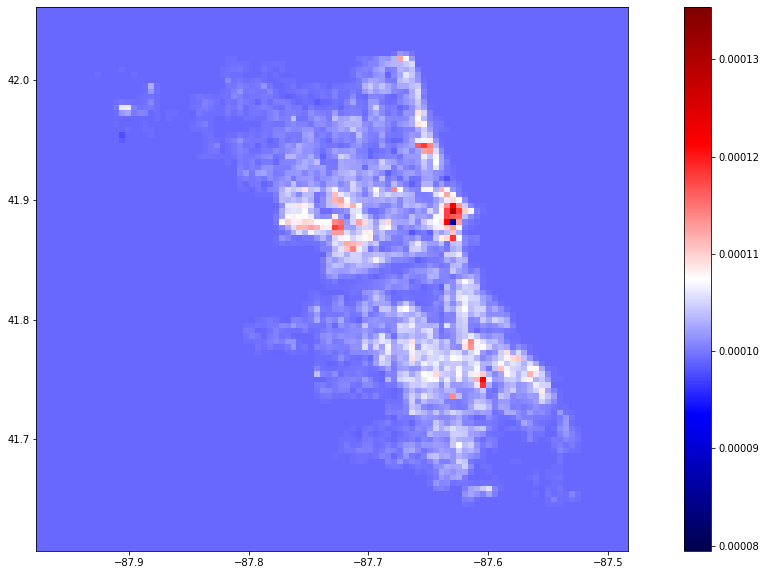

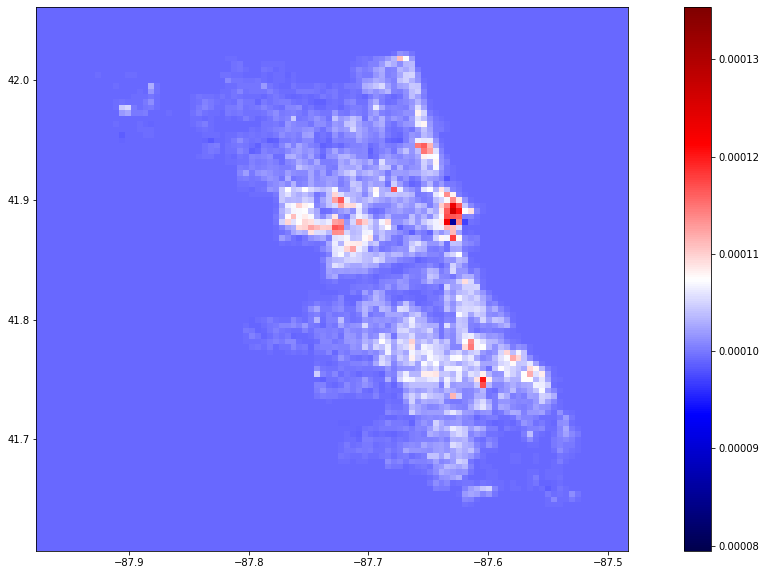

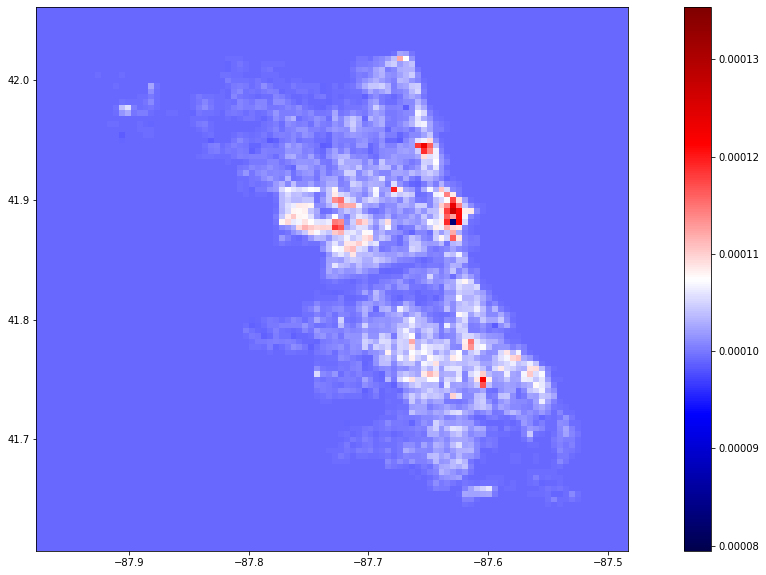

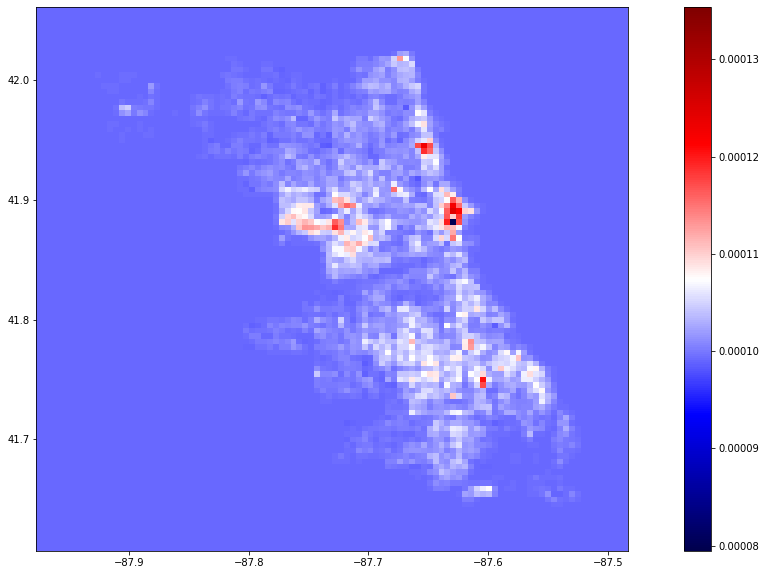

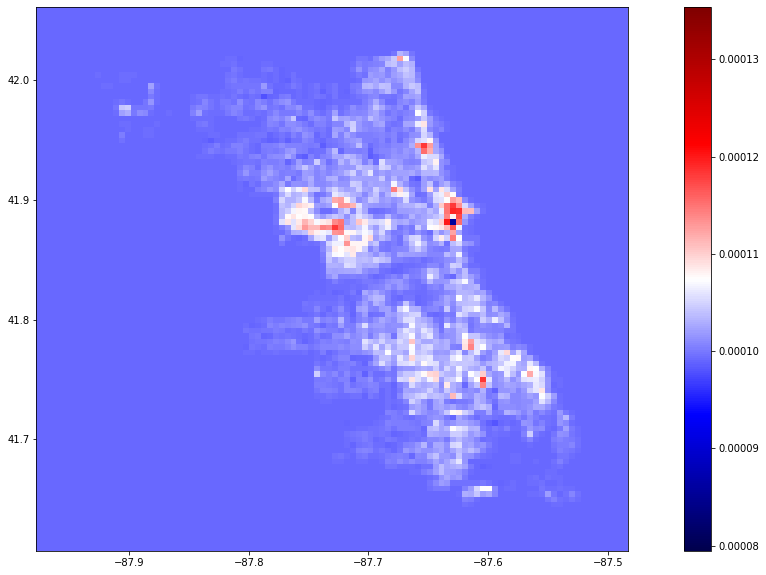

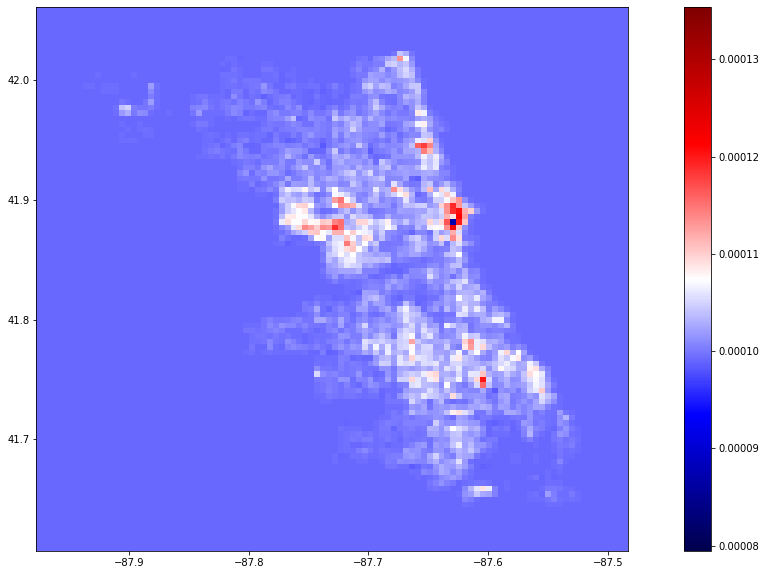

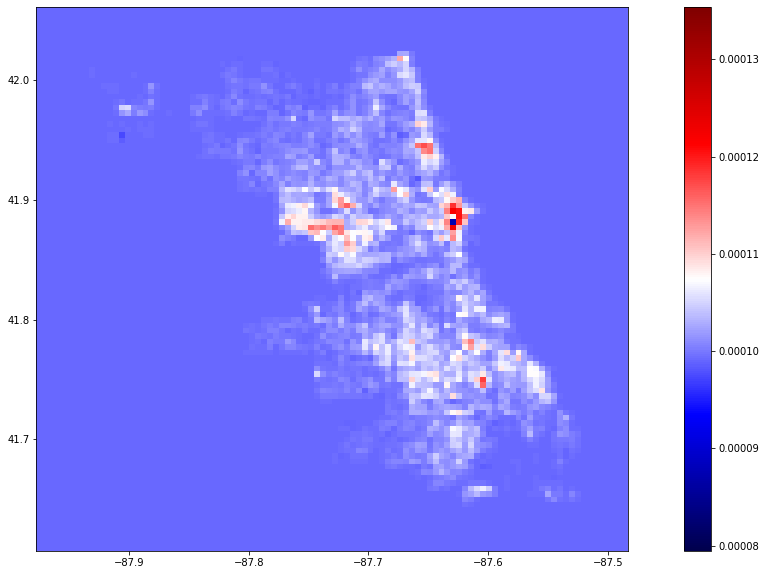

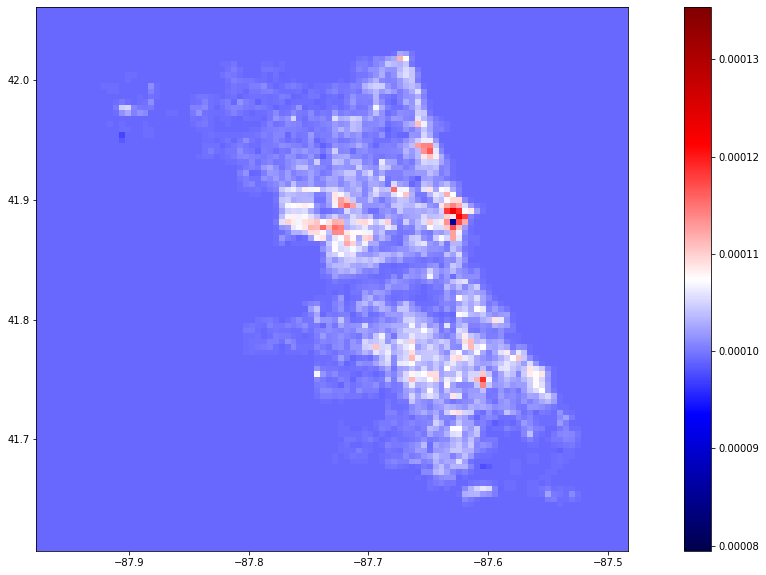

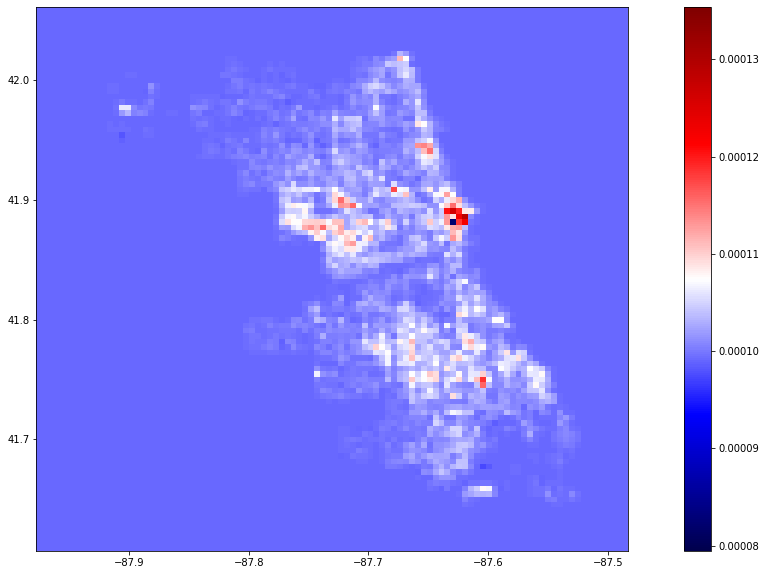

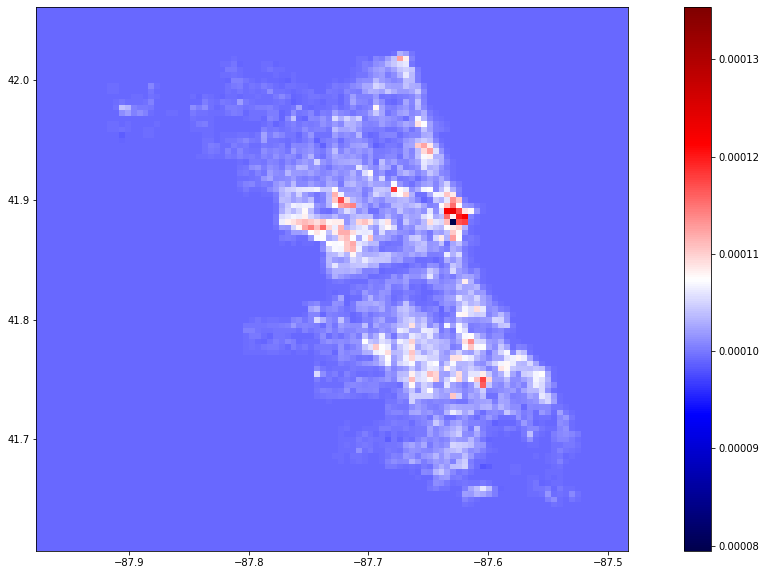

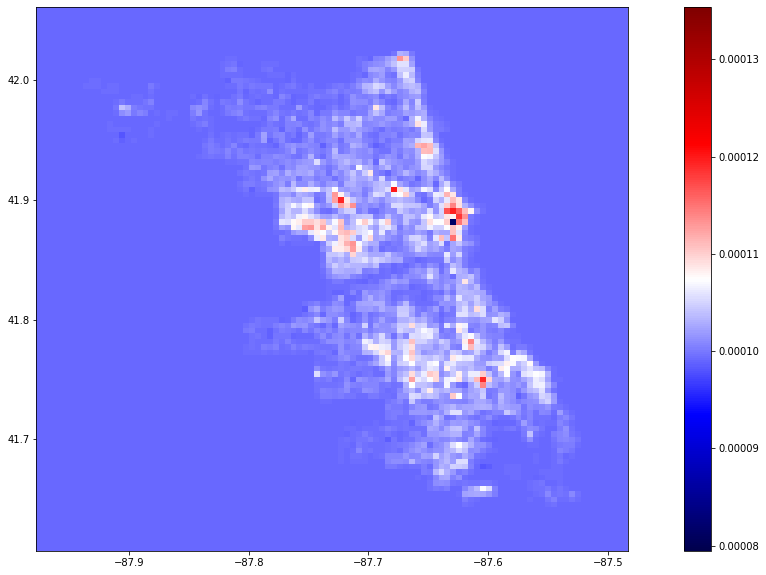

In [296]:
vmax,vmin = np.max(intermediate_layer_model.predict(X_valid)),np.min(intermediate_layer_model.predict(X_valid))

x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    #print(intermediate_output.shape)
    attImage = intermediate_output[0,:].reshape(100,100)
    #print(attImage.shape)
    plt.figure(figsize=(20,10))
    plt.imshow( X=np.rot90(attImage),vmin=vmin, vmax=vmax,cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    plt.show()

In [297]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention2_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

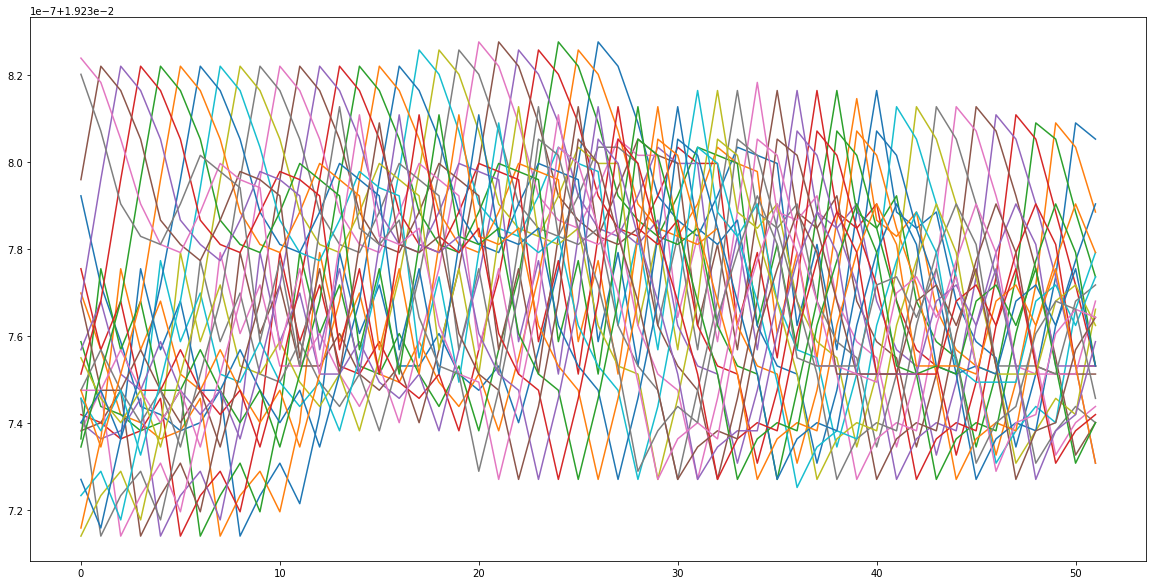

In [298]:
plt.figure(figsize=(20,10))
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

## 2 Heads Attention Pixel + Attention Timestep 

In [299]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist = Permute([2,1])(timeDist) #3D transpose between pixel and time dimension
units = timeDist.shape[2]
# compute importance for each step
#q^TxWxk_i, W is a projection of dimensions if key is different dimension from the query k_i.
attention1 = Dense(units, activation='tanh',name="W")(timeDist) ## weight matrix W (= units_key x units_project)
attention1 = Dense(1, activation='linear',name ="Query")(attention1) ## weight matrix v (= units x 1)
attention1 = Flatten()(attention1)
attention1 = Activation('softmax',name='attention1_weights')(attention1)
attention1 = RepeatVector(units)(attention1)
attention1 = Permute([2, 1])(attention1)
attention1 = Multiply()([timeDist, attention1])
attention1 = Permute([2, 1])(attention1) #transpose back to time being shape[1]
#attended_Dense_out1 = TimeDistributed(Dense(3, activation='relu'))(attention1)

timeDist2 = TimeDistributed(Flatten())(inputs)
timeDist2 = TimeDistributed(Dense(100), name="compressor")(timeDist2)
units = timeDist2.shape[2]
# compute importance for each step
attention2 = Dense(units, activation='tanh')(timeDist2) ## weight matrix W (= units x units/10) dimension reduction with W
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax',name='attention2_weights')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
attention2 = Multiply()([timeDist2, attention2])
#For each timestep update a single weight on Dense layer

merge = Concatenate()([attention1, attention2])

attended_Dense_out = TimeDistributed(Dense(1, activation='relu'))(merge)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_Dense_out))
outputs = Dense2


model = Model(inputs, outputs, name="TimeDistributed_attention1_plus_attention2_on_time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "TimeDistributed_attention1_plus_attention2_on_time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_109 (TimeDistr (None, 52, 10000)    0           input_47[0][0]                   
__________________________________________________________________________________________________
permute_167 (Permute)           (None, 10000, 52)    0           time_distributed_109[0][0]       
__________________________________________________________________________________________________
time_distributed_110 (TimeDistr (None, 52, 10000)    0           input_47[0][0]                   
_________________________________________________

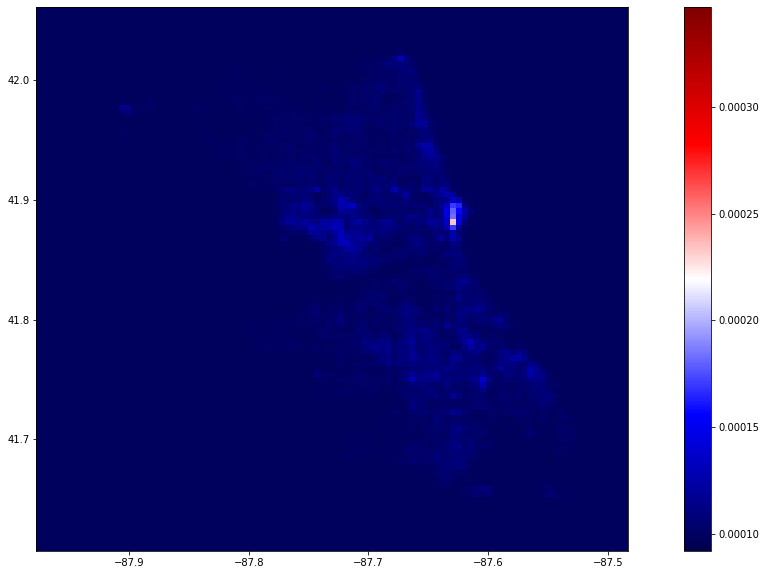

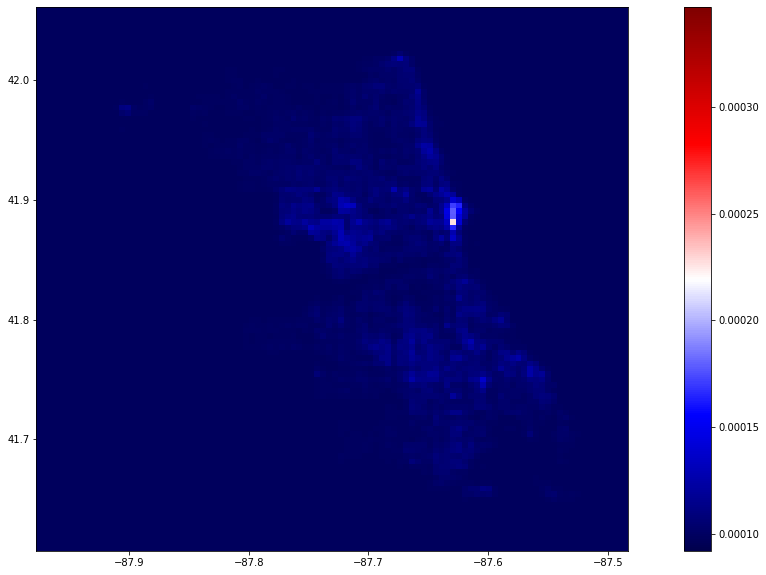

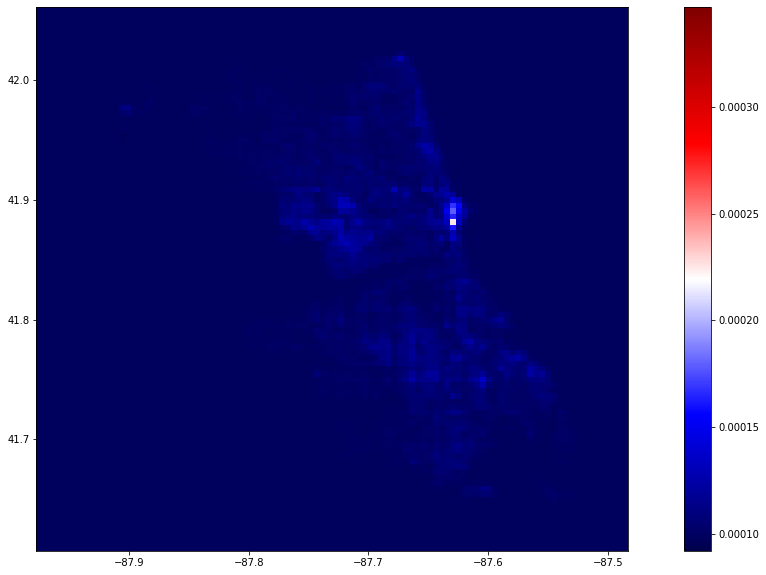

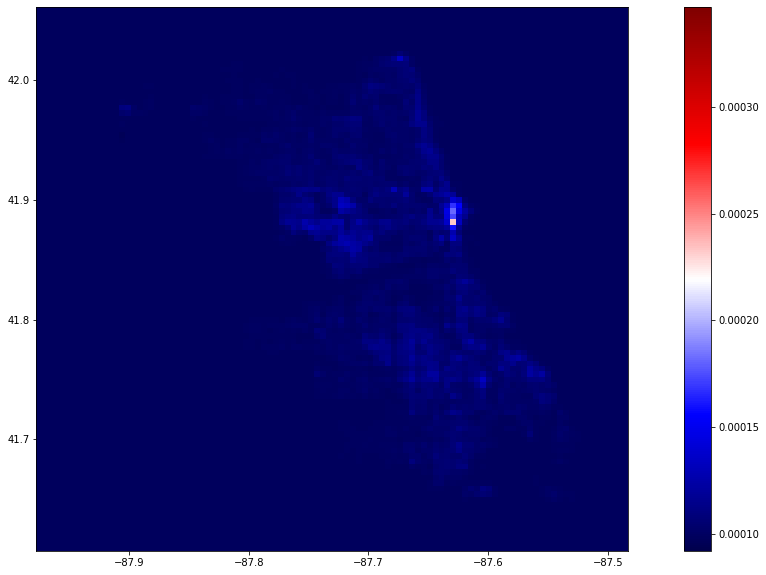

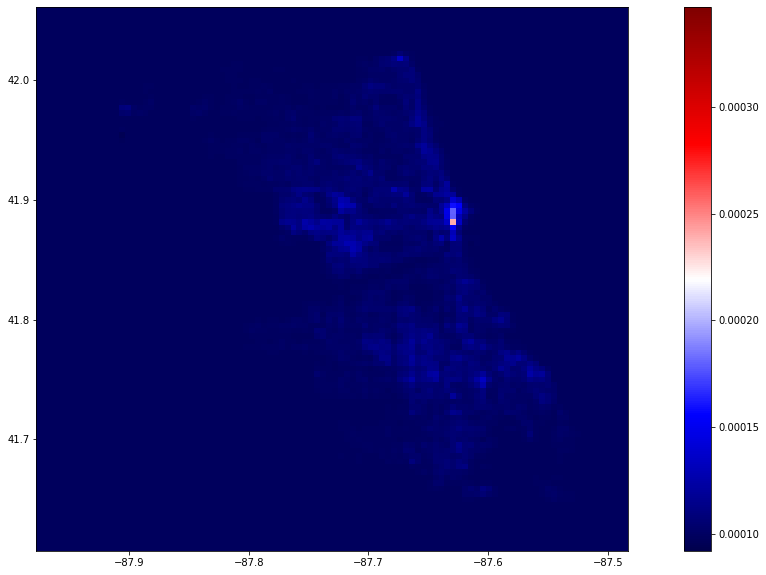

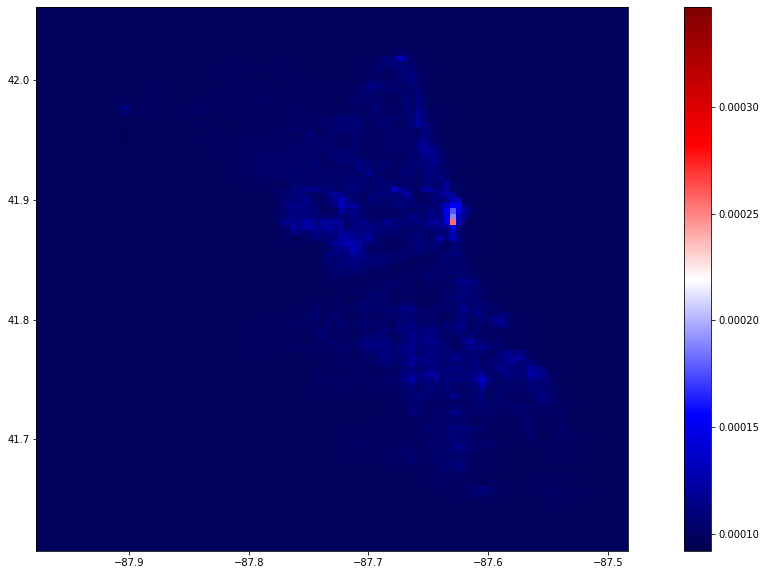

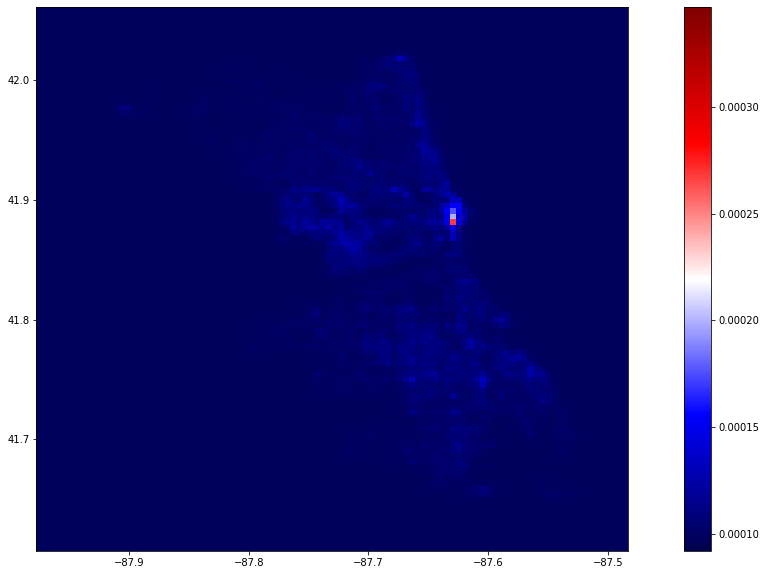

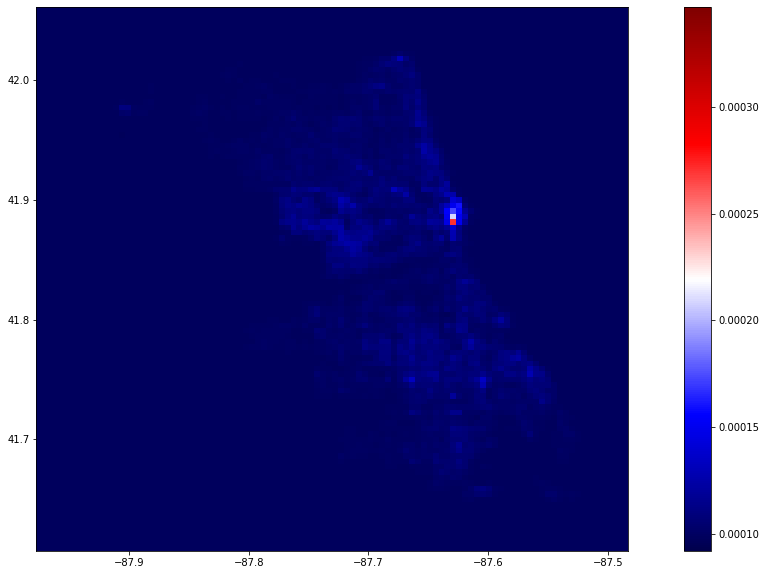

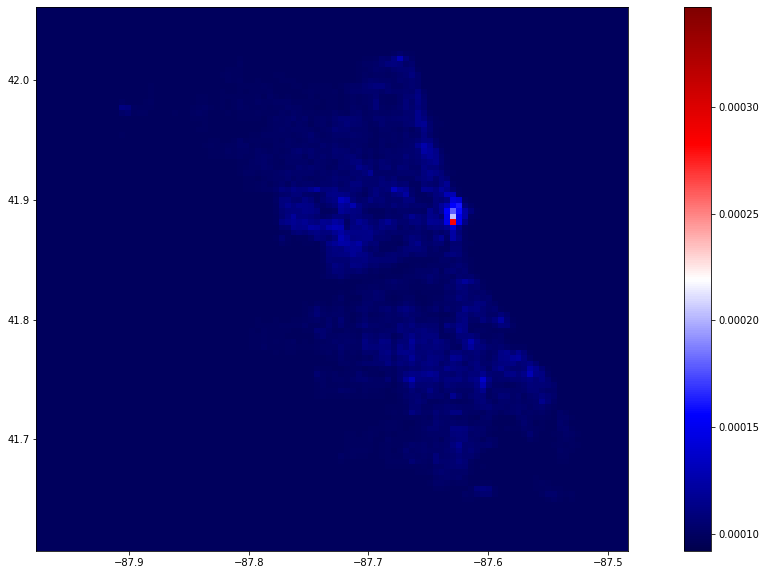

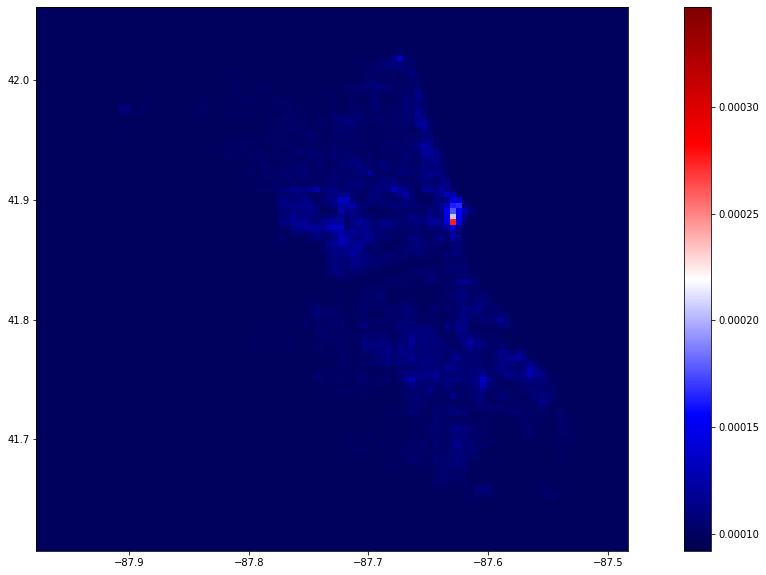

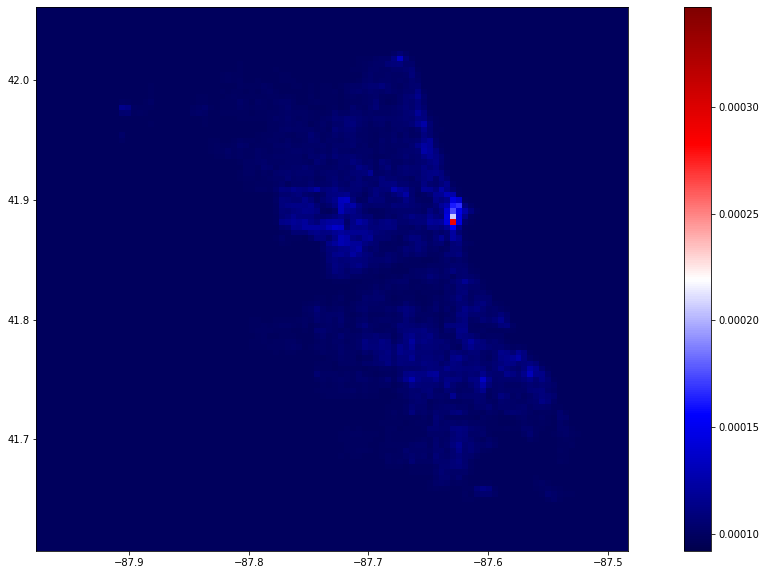

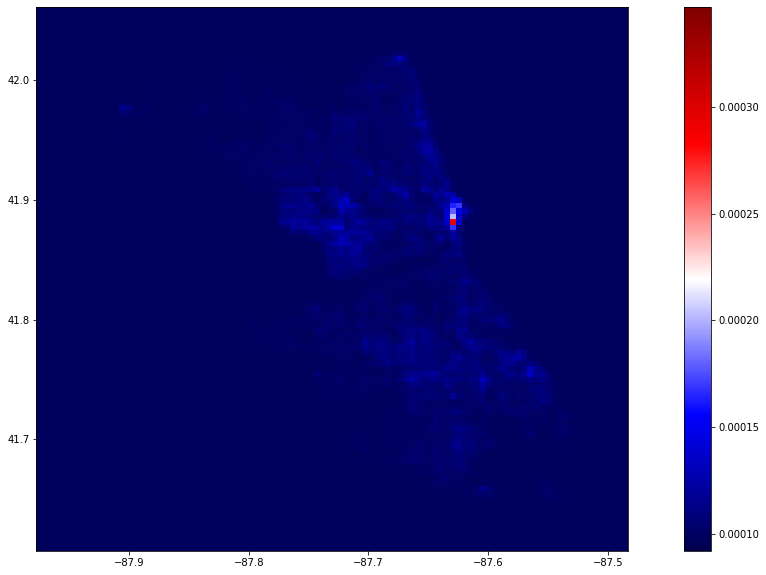

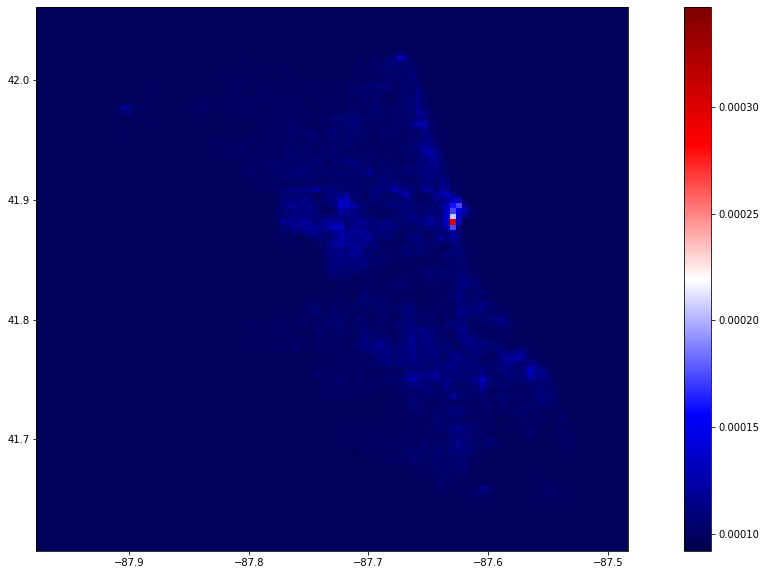

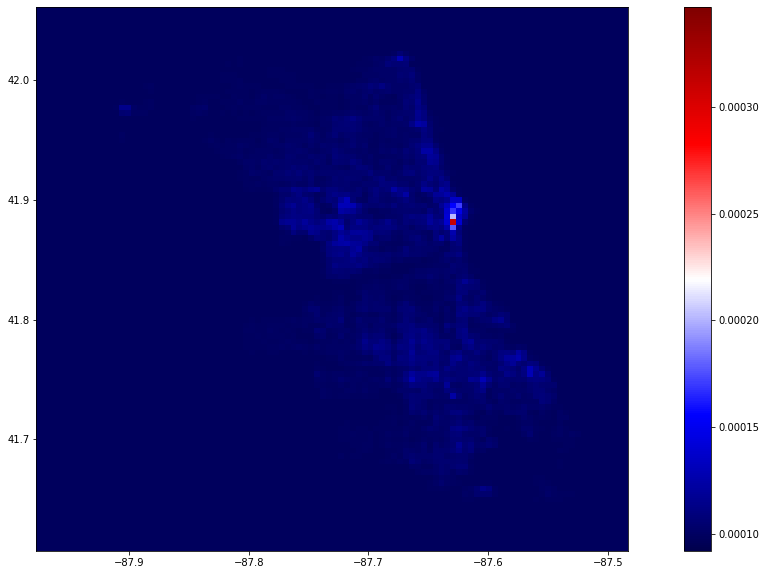

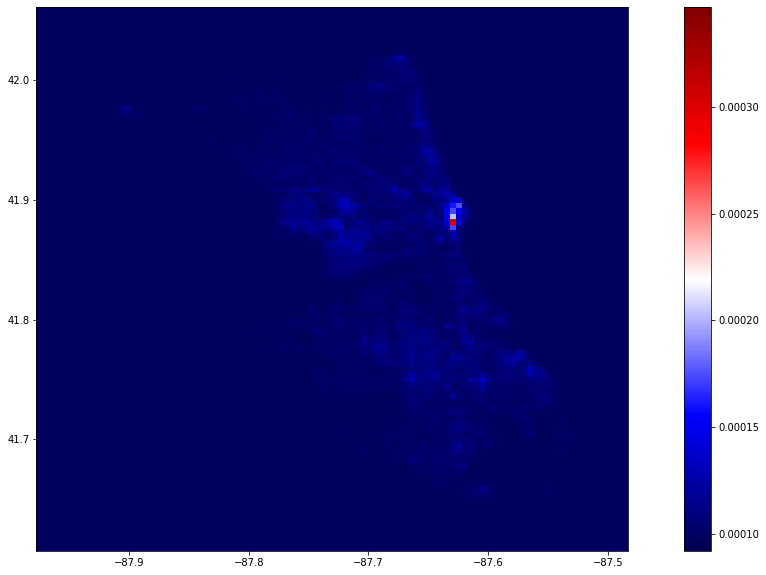

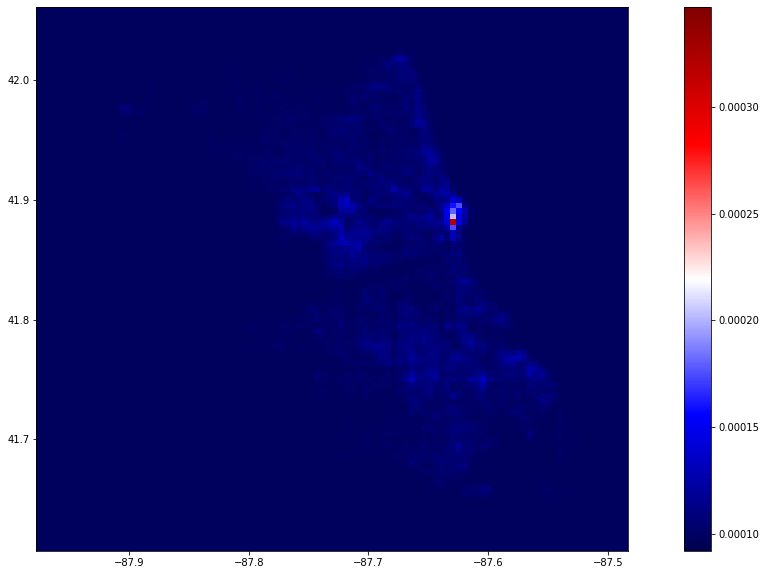

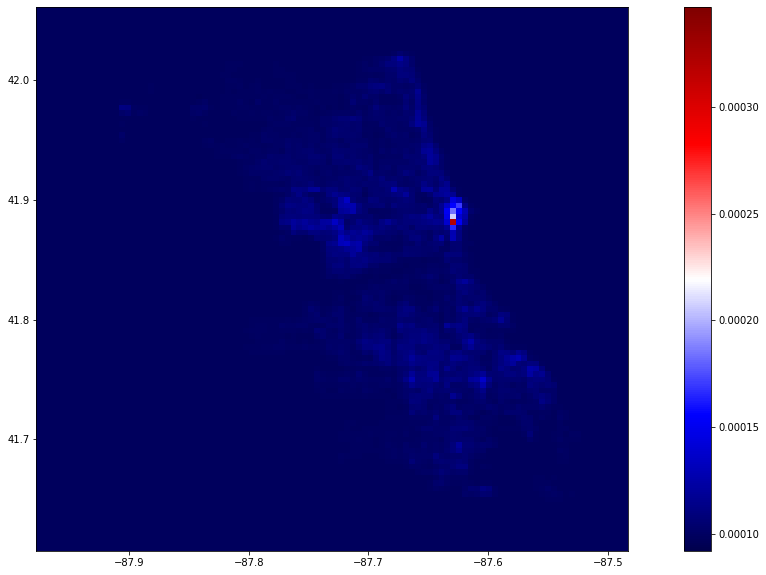

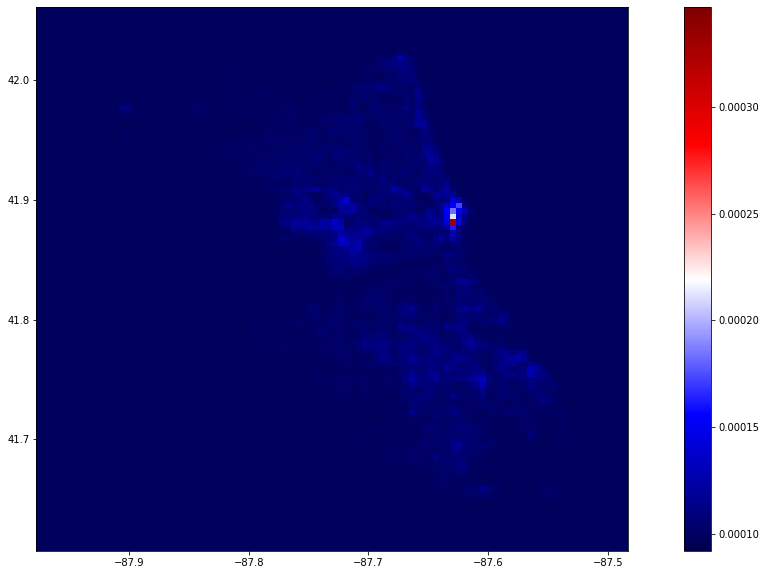

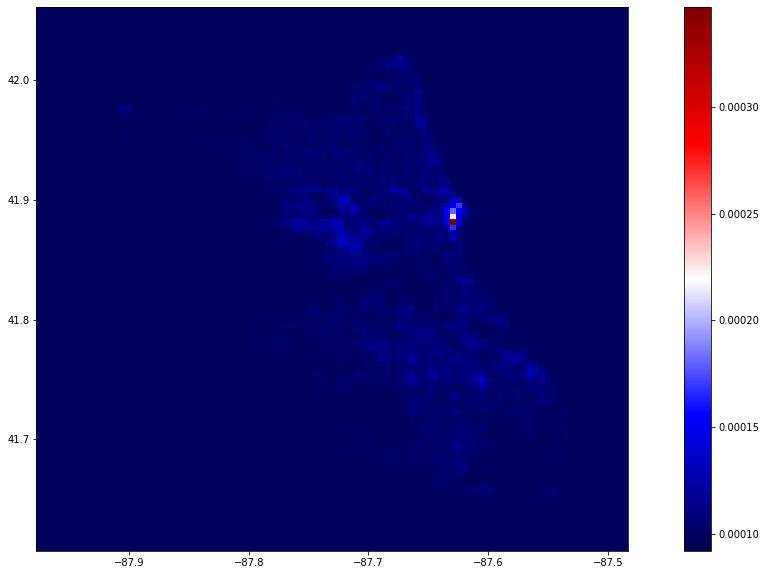

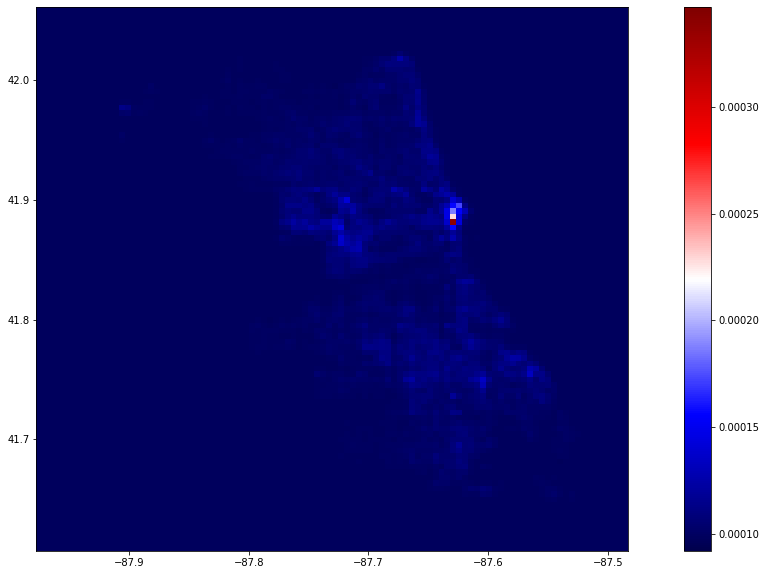

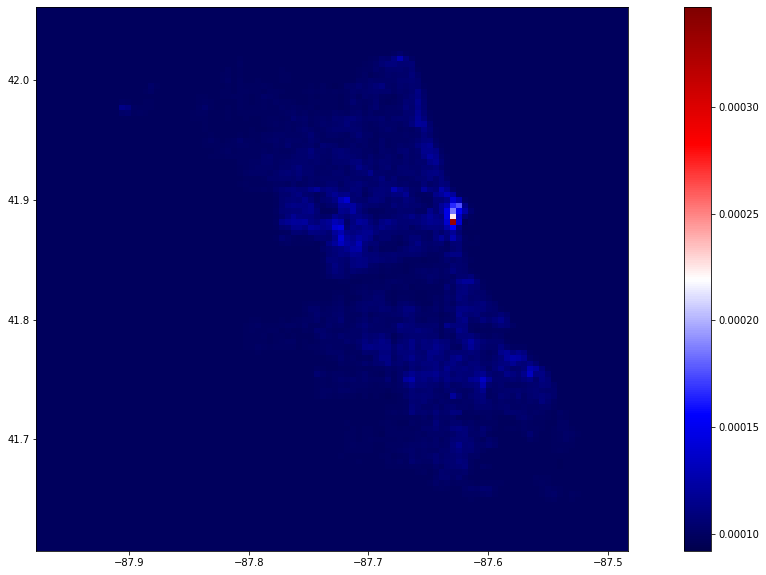

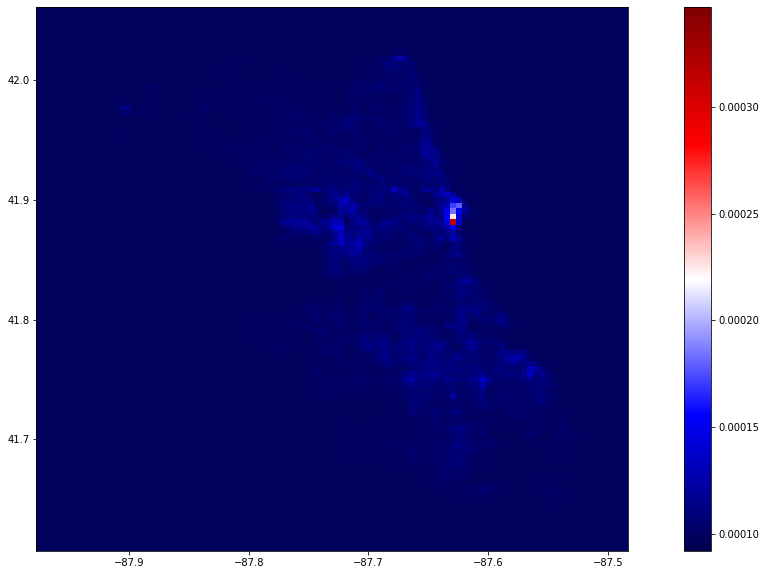

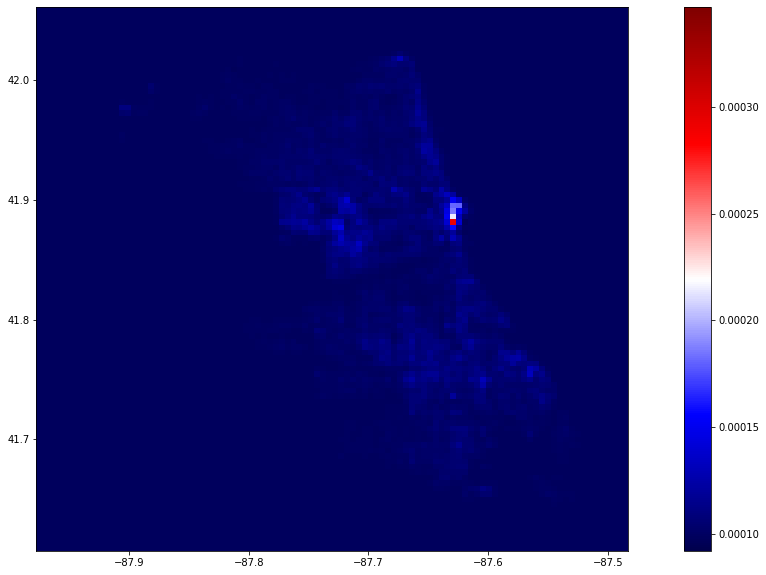

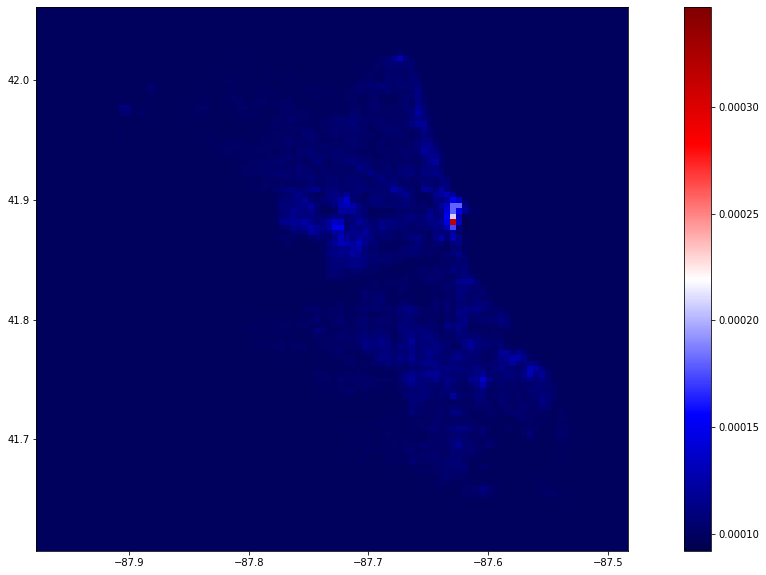

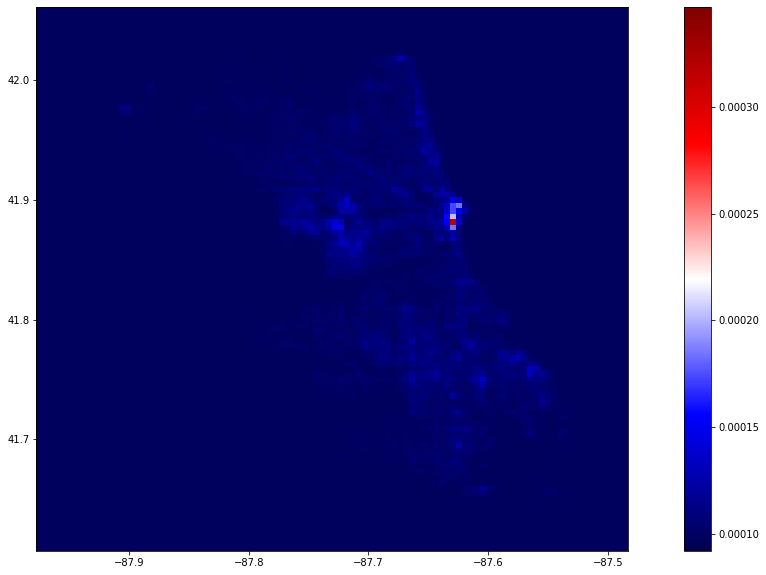

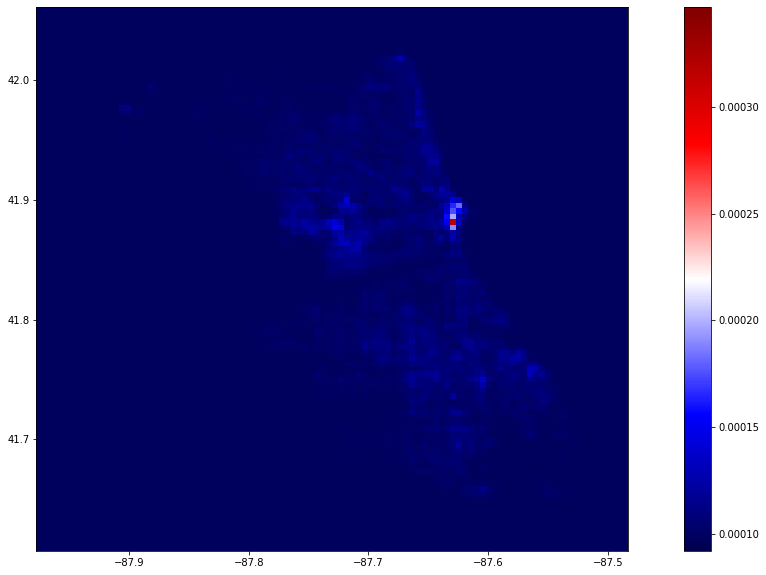

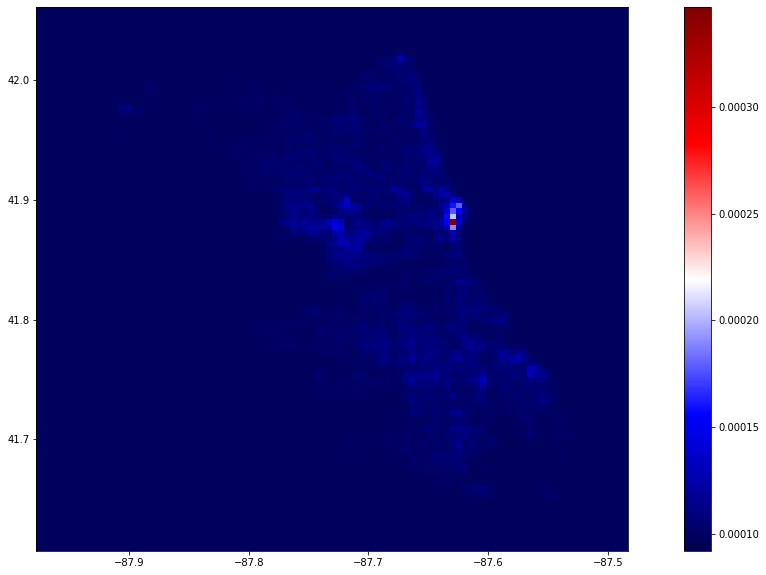

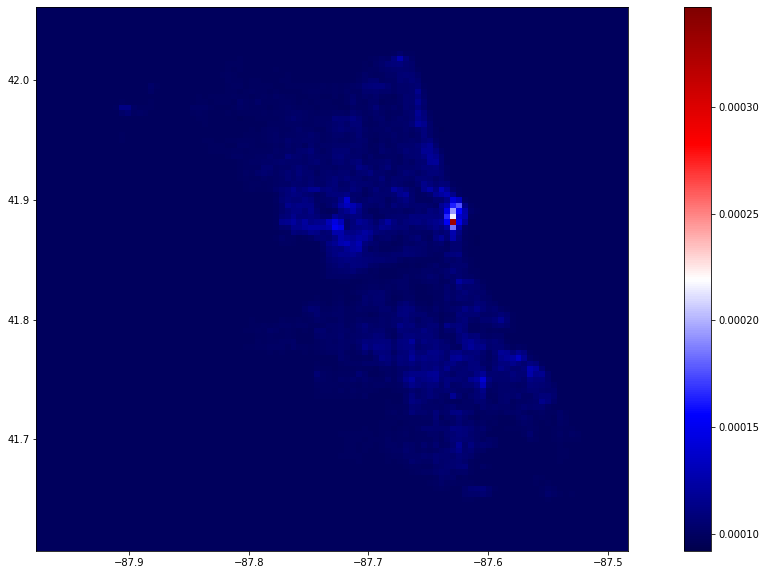

In [301]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention1_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)

vmax,vmin = np.max(intermediate_layer_model.predict(X_valid)),np.min(intermediate_layer_model.predict(X_valid))

x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    #print(intermediate_output.shape)
    attImage = intermediate_output[0,:].reshape(100,100)
    #print(attImage.shape)
    plt.figure(figsize=(20,10))
    plt.imshow( X=np.rot90(attImage),vmin=vmin, vmax=vmax,cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    plt.show()

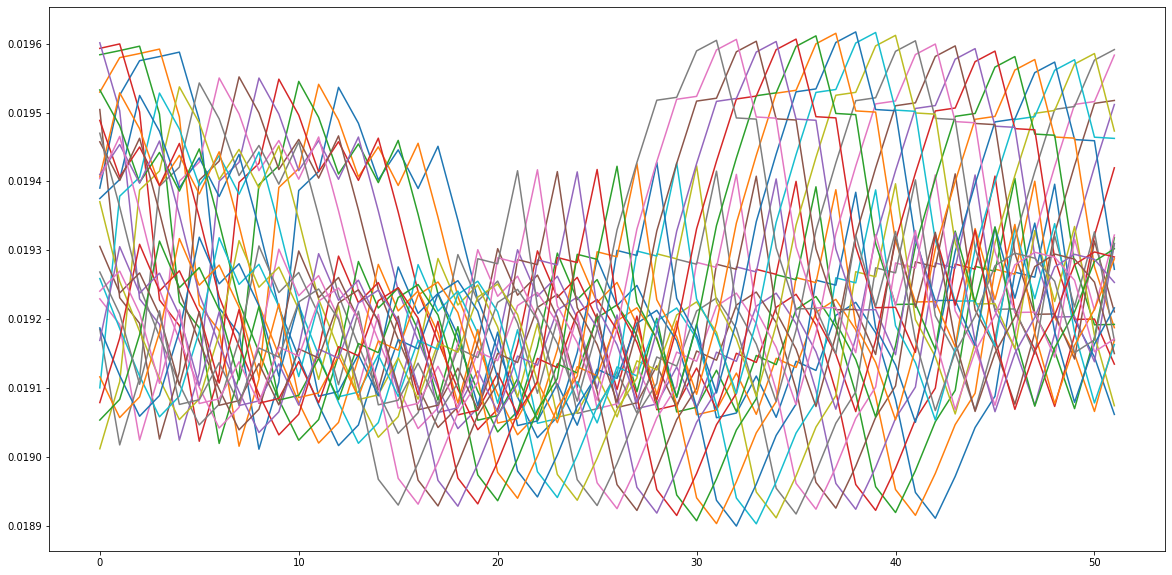

In [302]:
model_AttentionOut = model  # include here your original model

layer_name = 'attention2_weights'
intermediate_layer_model = Model(inputs=model_AttentionOut.input,
                                 outputs=model_AttentionOut.get_layer(layer_name).output)
plt.figure(figsize=(20,10))
for timeStepWeek in range(X_valid.shape[0]):
    intermediate_output = intermediate_layer_model.predict(X_valid[timeStepWeek:timeStepWeek+1])
    plt.plot(intermediate_output[0])
    #plt.show()

## Run fit on any of the previous model here

In [300]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)


model.summary()

model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=1000, 
                             batch_size=6, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ])

valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Model: "TimeDistributed_attention1_plus_attention2_on_time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_109 (TimeDistr (None, 52, 10000)    0           input_47[0][0]                   
__________________________________________________________________________________________________
permute_167 (Permute)           (None, 10000, 52)    0           time_distributed_109[0][0]       
__________________________________________________________________________________________________
time_distributed_110 (TimeDistr (None, 52, 10000)    0           input_47[0][0]                   
_________________________________________________

88/88 [==============================] - 0s 4ms/sample - loss: 0.0065 - mae: 0.0065 - val_loss: 0.0064 - val_mae: 0.0064
Epoch 7/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0063 - mae: 0.0063
Epoch 00007: val_loss improved from 0.00638 to 0.00613, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 3ms/sample - loss: 0.0062 - mae: 0.0062 - val_loss: 0.0061 - val_mae: 0.0061
Epoch 8/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0060 - mae: 0.0060
Epoch 00008: val_loss improved from 0.00613 to 0.00590, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 3ms/sample - loss: 0.0060 - mae: 0.0060 - val_loss: 0.0059 - val_mae: 0.0059
Epoch

88/88 [==============================] - 0s 4ms/sample - loss: 0.0034 - mae: 0.0034 - val_loss: 0.0035 - val_mae: 0.0035
Epoch 26/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0033 - mae: 0.0033
Epoch 00026: val_loss improved from 0.00346 to 0.00337, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0033 - mae: 0.0033 - val_loss: 0.0034 - val_mae: 0.0034
Epoch 27/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0032 - mae: 0.0032
Epoch 00027: val_loss improved from 0.00337 to 0.00328, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0032 - mae: 0.0032 - val_loss: 0.0033 - val_mae: 0.0033
Epo

88/88 [==============================] - 0s 4ms/sample - loss: 0.0024 - mae: 0.0024 - val_loss: 0.0024 - val_mae: 0.0024
Epoch 45/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0024 - mae: 0.0024
Epoch 00045: val_loss improved from 0.00245 to 0.00241, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0024 - mae: 0.0024 - val_loss: 0.0024 - val_mae: 0.0024
Epoch 46/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0023 - mae: 0.0023
Epoch 00046: val_loss improved from 0.00241 to 0.00239, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0023 - mae: 0.0023 - val_loss: 0.0024 - val_mae: 0.0024
Epo

88/88 [==============================] - 0s 4ms/sample - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0021 - val_mae: 0.0021
Epoch 64/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0020 - mae: 0.0020
Epoch 00064: val_loss improved from 0.00210 to 0.00209, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0021 - val_mae: 0.0021
Epoch 65/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0020 - mae: 0.0020
Epoch 00065: val_loss improved from 0.00209 to 0.00208, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0021 - val_mae: 0.0021
Epo

88/88 [==============================] - 0s 4ms/sample - loss: 0.0019 - mae: 0.0019 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 83/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0019 - mae: 0.0019
Epoch 00083: val_loss did not improve from 0.00195
88/88 [==============================] - 0s 3ms/sample - loss: 0.0019 - mae: 0.0019 - val_loss: 0.0020 - val_mae: 0.0020
Epoch 84/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0019 - mae: 0.0019
Epoch 00084: val_loss improved from 0.00195 to 0.00194, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0019 - mae: 0.0019 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 85/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0019 - mae: 0.0019
Epoch 00085: val_loss improved from 0.00194 to 0.00194, saving model to /home/zhimin9

88/88 [==============================] - 0s 4ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 106/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00106: val_loss improved from 0.00186 to 0.00186, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 107/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00107: val_loss did not improve from 0.00186
88/88 [==============================] - 0s 3ms/sample - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0019 - val_mae: 0.0019
Epoch 108/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0018 - mae: 0.0018
Epoch 00108: val_loss improved from 0.00186 to 0.00186, saving model to /home/zhim

88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 130/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00130: val_loss did not improve from 0.00182
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 131/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00131: val_loss did not improve from 0.00182
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 132/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00132: val_loss did not improve from 0.00182
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 133/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae

Epoch 156/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00156: val_loss did not improve from 0.00179
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 157/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00157: val_loss did not improve from 0.00179
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 158/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00158: val_loss improved from 0.00179 to 0.00179, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 159/1000
78/88 [=========

88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 184/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00184: val_loss did not improve from 0.00176
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 185/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00185: val_loss did not improve from 0.00176
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 186/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00186: val_loss did not improve from 0.00176
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 187/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae

Epoch 212/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00212: val_loss did not improve from 0.00175
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0018 - val_mae: 0.0018
Epoch 213/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00213: val_loss improved from 0.00175 to 0.00175, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 214/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0017 - mae: 0.0017
Epoch 00214: val_loss did not improve from 0.00175
88/88 [==============================] - 0s 3ms/sample - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 215/1000
78/88 [=========

Epoch 240/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00240: val_loss did not improve from 0.00174
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 241/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00241: val_loss did not improve from 0.00174
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 242/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00242: val_loss did not improve from 0.00174
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 243/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00243: val_loss improved from 0.00174 to 0.00173, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC6

Epoch 268/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00268: val_loss did not improve from 0.00173
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 269/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00269: val_loss did not improve from 0.00173
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 270/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00270: val_loss did not improve from 0.00173
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 271/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00271: val_loss did not improve from 0.00173
88/88 [==============================] - 0s 3ms/sample - loss

78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00296: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 297/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00297: val_loss improved from 0.00172 to 0.00172, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 298/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00298: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 299/1000
78/88 [========================

78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00324: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 325/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00325: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 326/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00326: val_loss did not improve from 0.00172
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 327/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00327: val_loss improved from 0.00172 to 0.00171, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Rese

Epoch 352/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00352: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 353/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00353: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 354/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00354: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 355/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00355: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss

Epoch 381/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00381: val_loss improved from 0.00171 to 0.00171, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 382/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00382: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 383/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00383: val_loss did not improve from 0.00171
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 384/1000
78/88 [=========

78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00409: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 410/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00410: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 411/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00411: val_loss improved from 0.00170 to 0.00170, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 412/1000
78/88 [========================

78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00437: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 438/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00438: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 439/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00439: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 440/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00440: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae:

78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00466: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 467/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00467: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 468/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00468: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 469/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00469: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae:

78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00495: val_loss improved from 0.00169 to 0.00169, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200712-095217_model.hdf5
88/88 [==============================] - 0s 4ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 496/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00496: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 497/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00497: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 498/1000
78/88 [========================

78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00525: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 526/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00526: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 527/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00527: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 528/1000
78/88 [=========================>....] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00528: val_loss did not improve from 0.00169
88/88 [==============================] - 0s 3ms/sample - loss: 0.0016 - mae:

# Test Set accuracy

#### Flattened+Attention

In [54]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.002142413, valid_loss=0.002142413053661585


#### Flattened+LSTM+Attention

In [48]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.0021439143, valid_loss=0.002143914345651865


#### FFT+Attention

In [104]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.002143551, valid_loss=0.0021435508970171213


#### Attention on Attention

In [135]:
valid_loss, valid_acc = model.evaluate(X_test, Y_test, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

28/28 - 0s - loss: 0.0021 - mae: 0.0021
valid_accuracy_MAE=0.0021426608, valid_loss=0.0021426607854664326


# Validation Set:

### Best flatten() + fully connected Dense is at  MAE of 0.001698

### Best flatten() + LSTM(100) is at  MAE of 0.001731

### Best 2D CNN + LSTM(50) is at MAE of 0.001724

### Best 2D CNN + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.0016917

### Best flatten() + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.0016915

### Best flatten() + 2x Attention Heads on  TimeDistributed is at MAE of 0.0016920

### Best FFT + Attention Heads on  TimeDistributed is at MAE of 0.0016920

## Best Pixel Attention + Time Distributed is at MAE of 0.00169077

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [242]:
Predict = model.predict(X_valid)

In [243]:
Predict.shape

(28, 10000)

In [244]:
int(Predict[-1].shape[0]**(1/2)),int(Predict[-1].shape[0]**(1/2))

(100, 100)

In [245]:
def reshapePred(Predict, fromLast=1):
    return np.rot90(Predict[-1*fromLast].reshape(int(Predict[-1*fromLast].shape[0]**(1/2)),int(Predict[-1*fromLast].shape[0]**(1/2))))

In [246]:
Y_valid.shape

(28, 10000)

In [247]:
vmax, vmin = np.max(Predict),np.min(Predict)
vmax, vmin

(0.7712556, -5.3925636e-05)

In [268]:
dvmax, dvmin = np.max(np.abs(Predict-Y_valid)),np.min(np.abs(Predict-Y_valid))
dvmax, dvmin

(0.22230684871577672, 8.223502324425432e-09)

In [269]:
diff_max,diff_min = (dvmax , dvmin ) 
def scaleDiff(diff,diff_max,diff_min):
    return (diff - diff_min)/(diff_max - diff_min)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explic

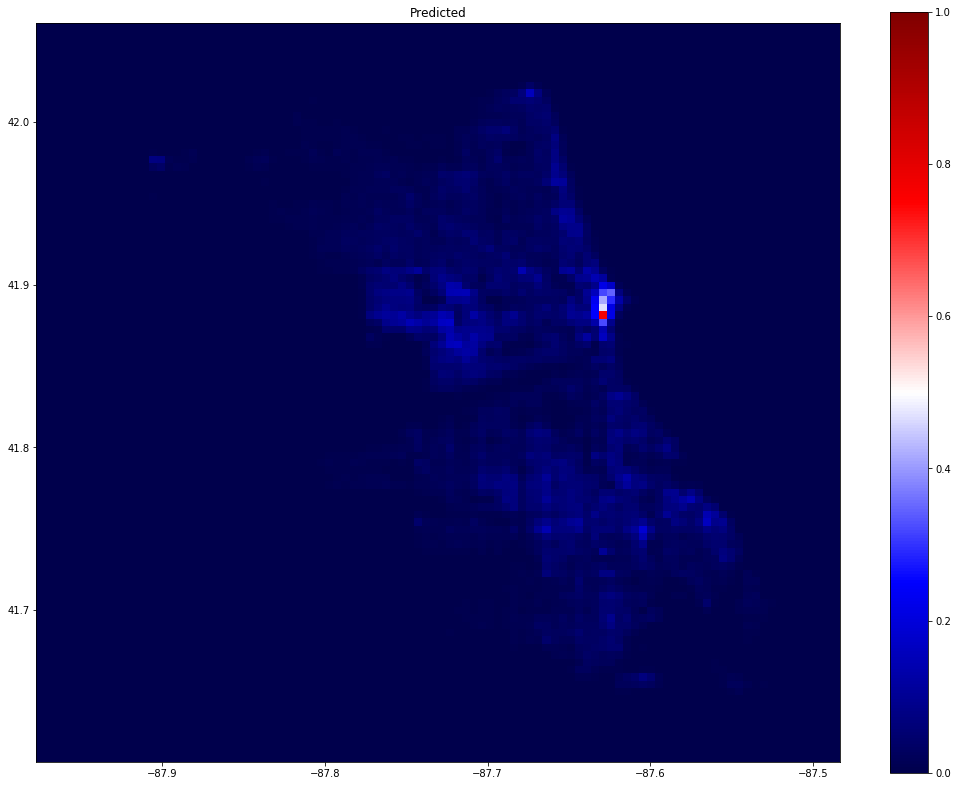

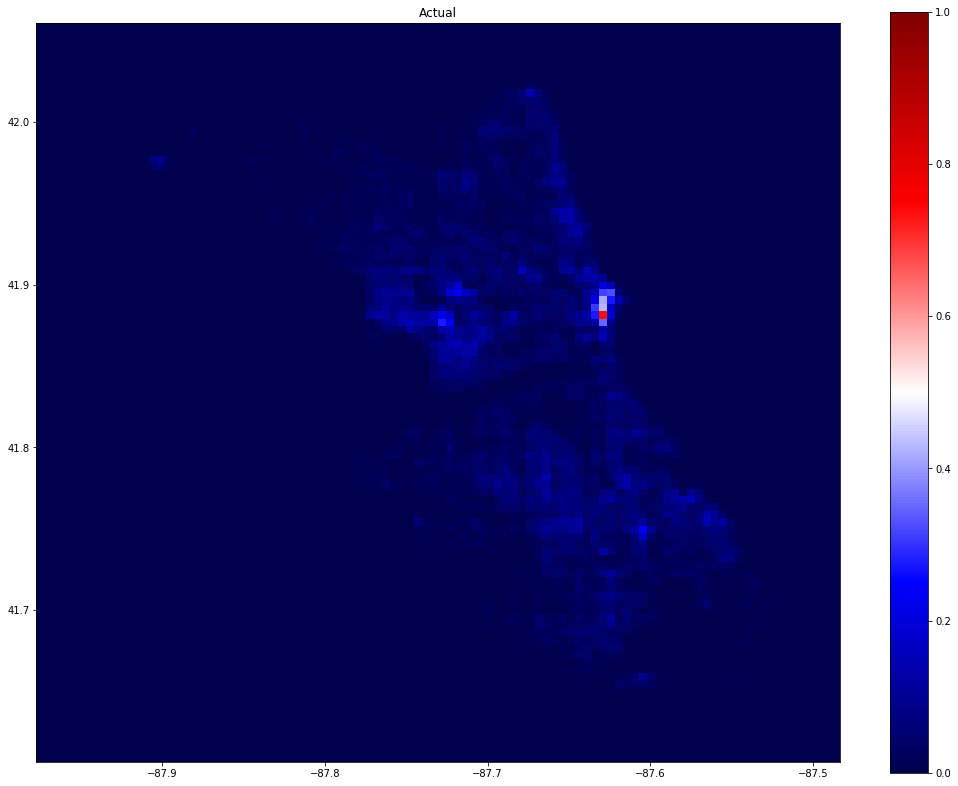

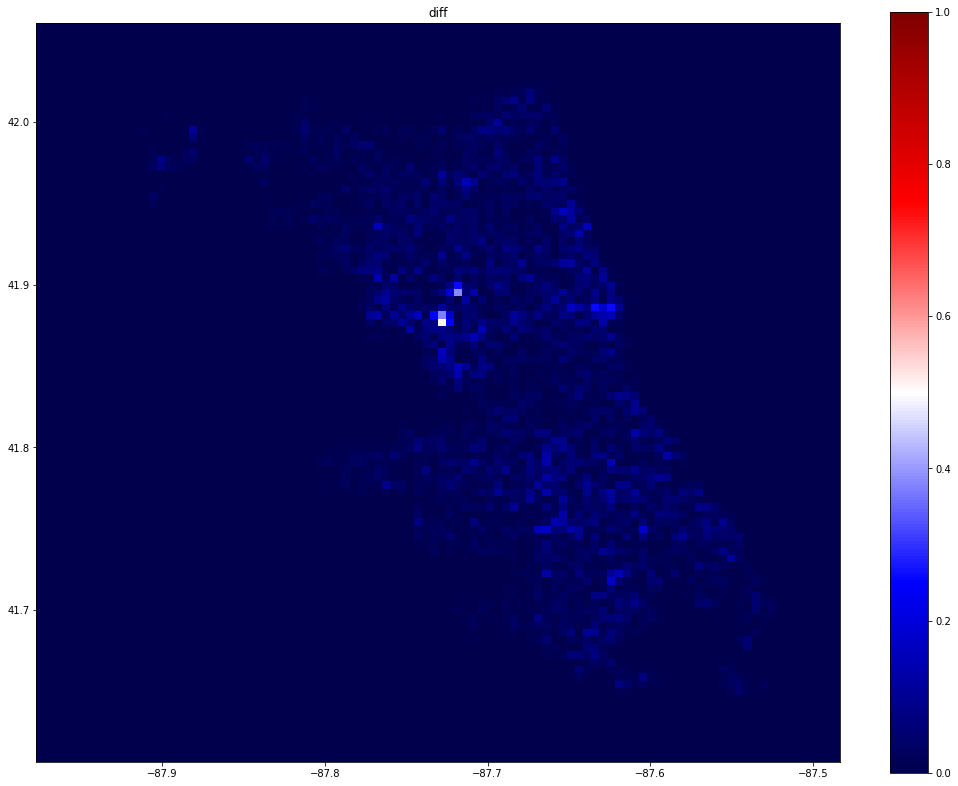

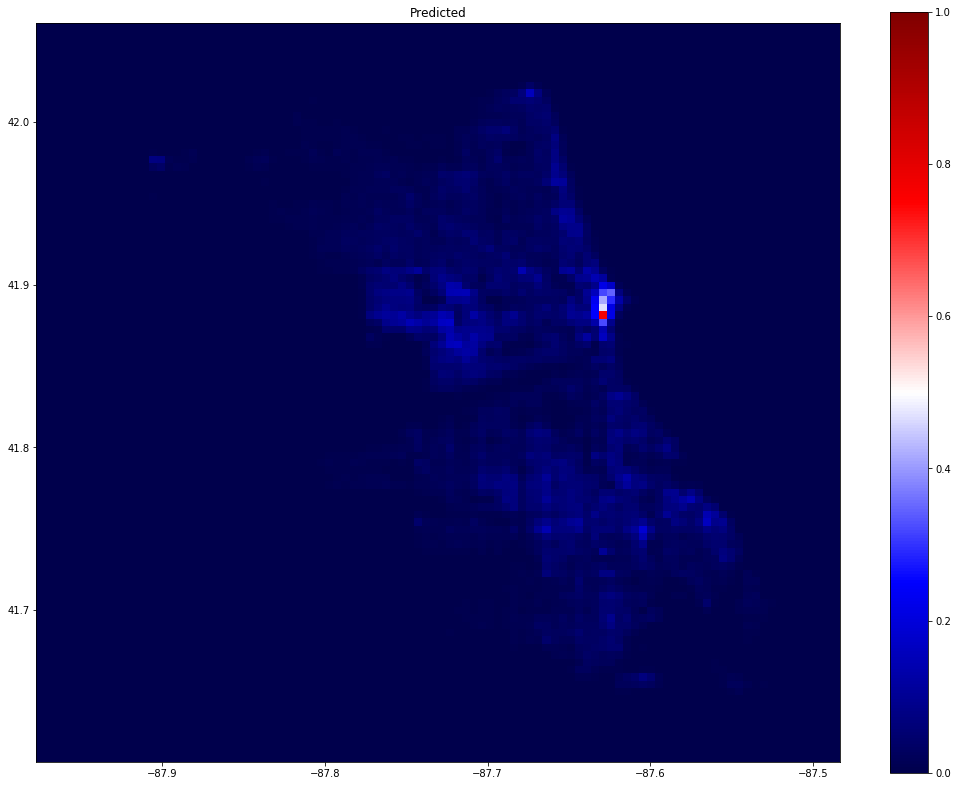

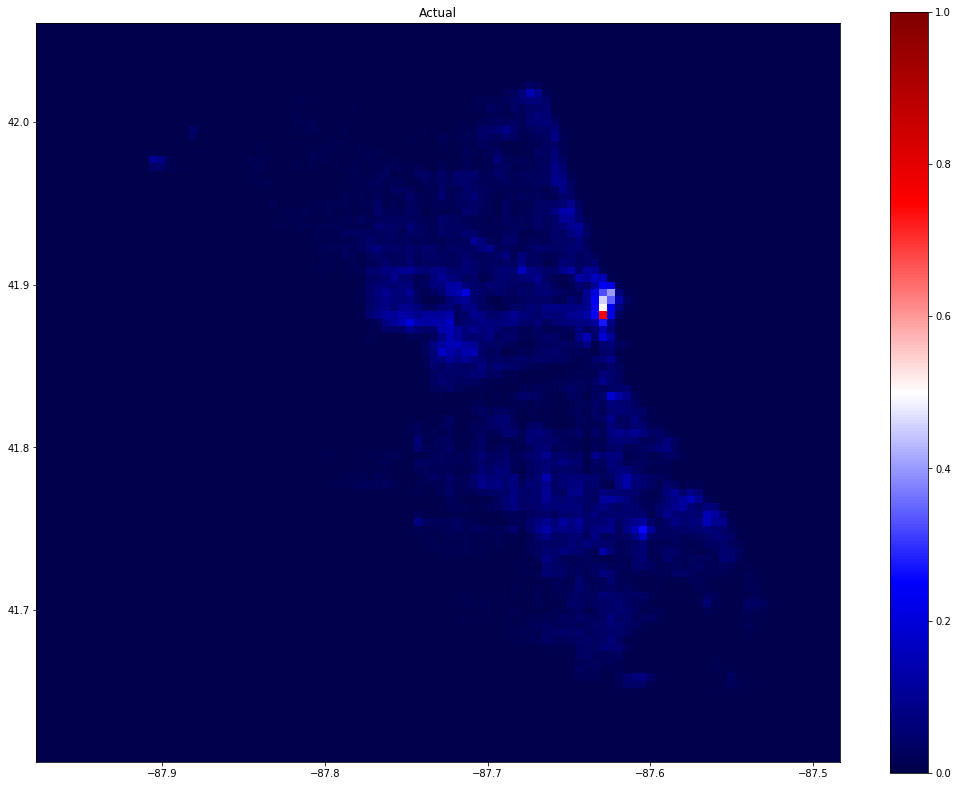

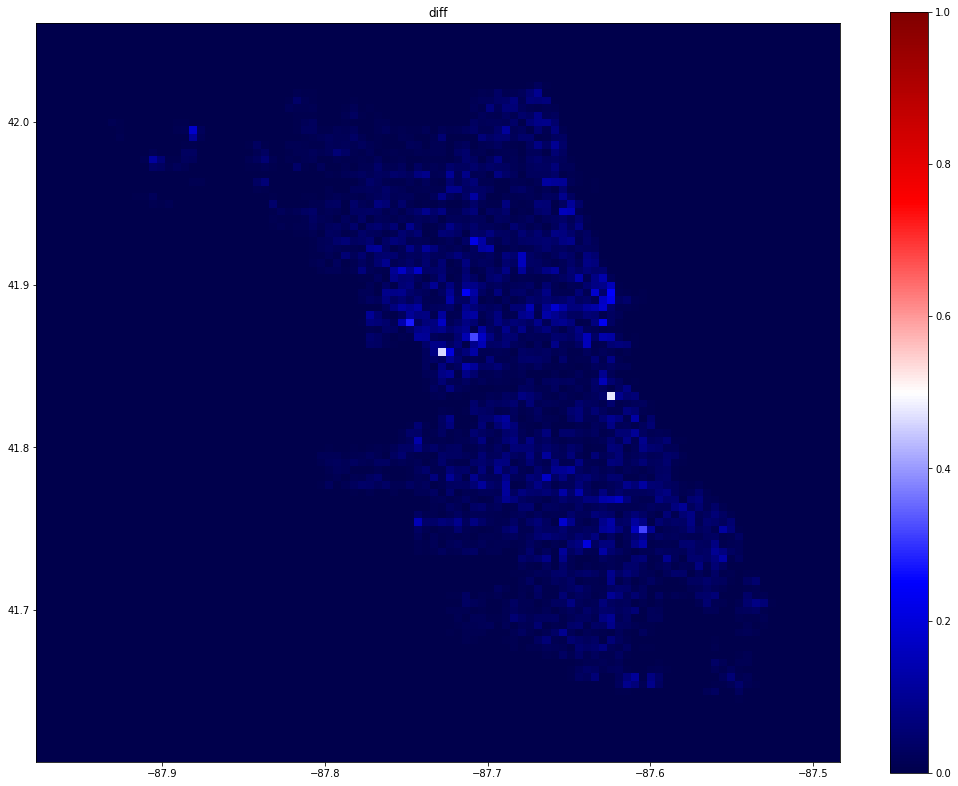

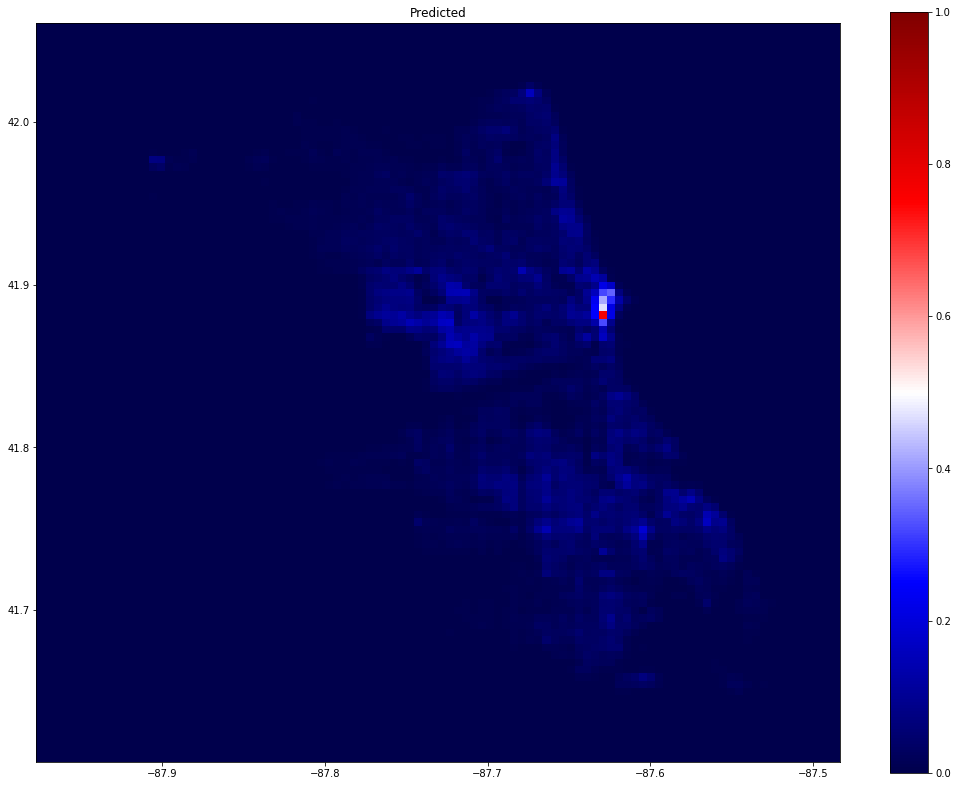

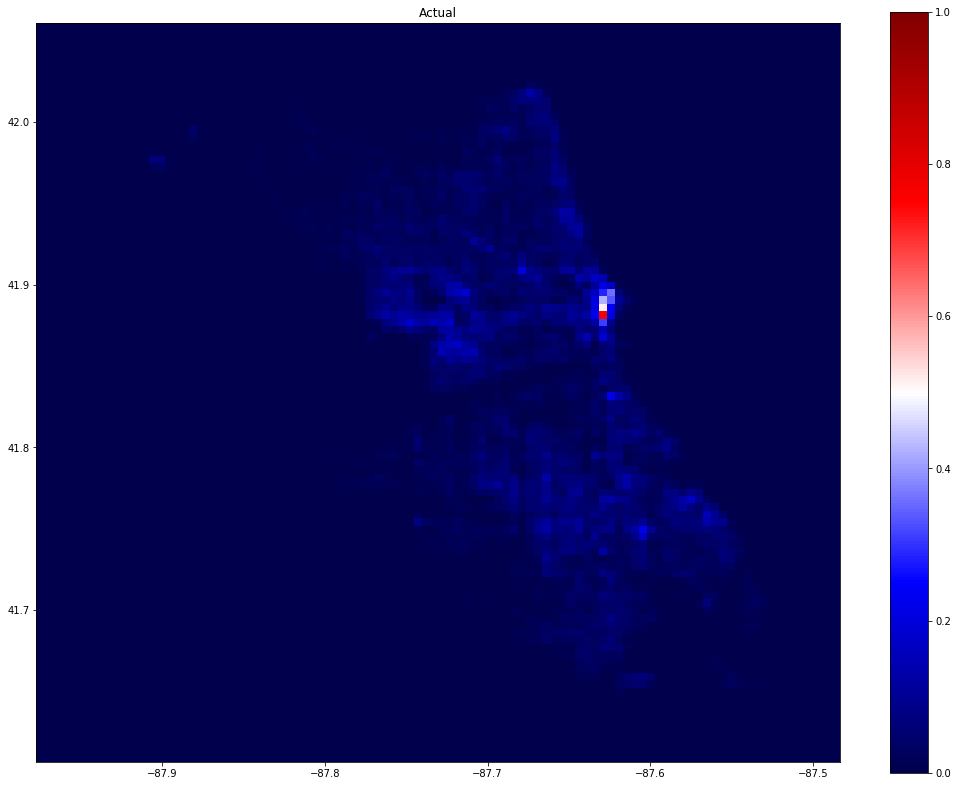

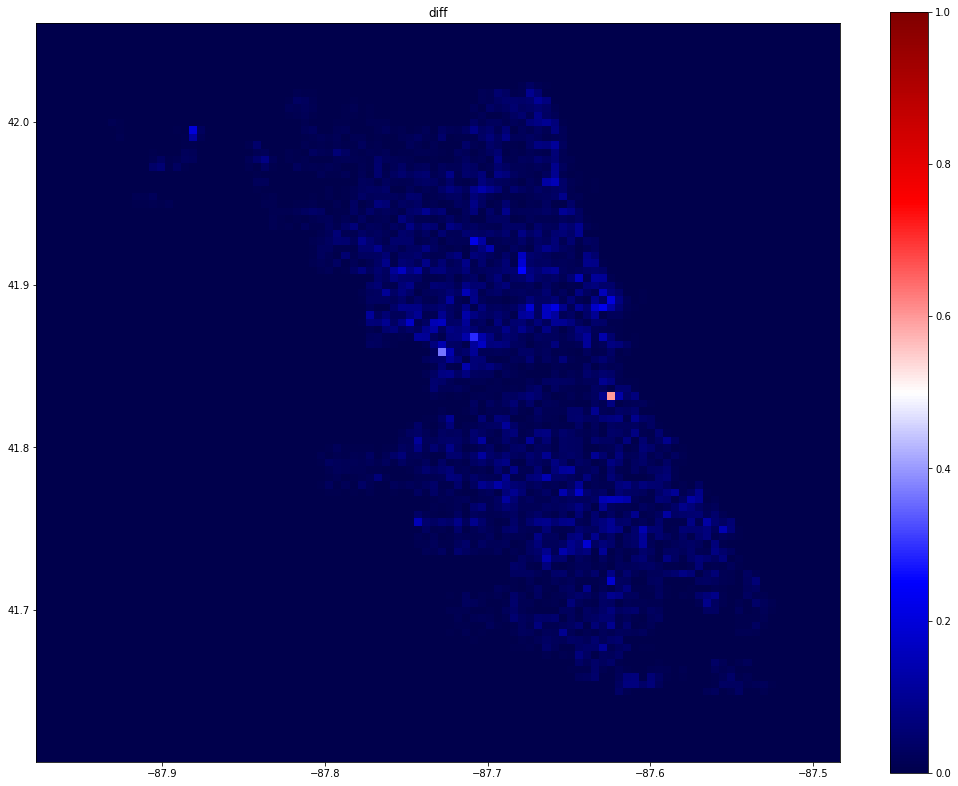

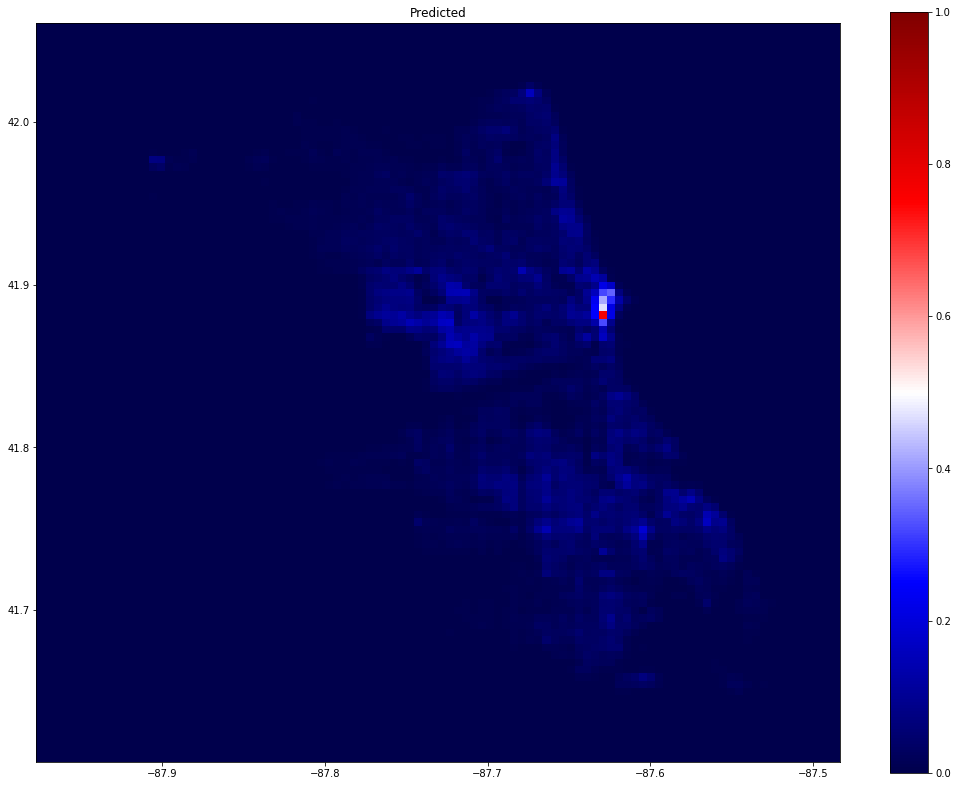

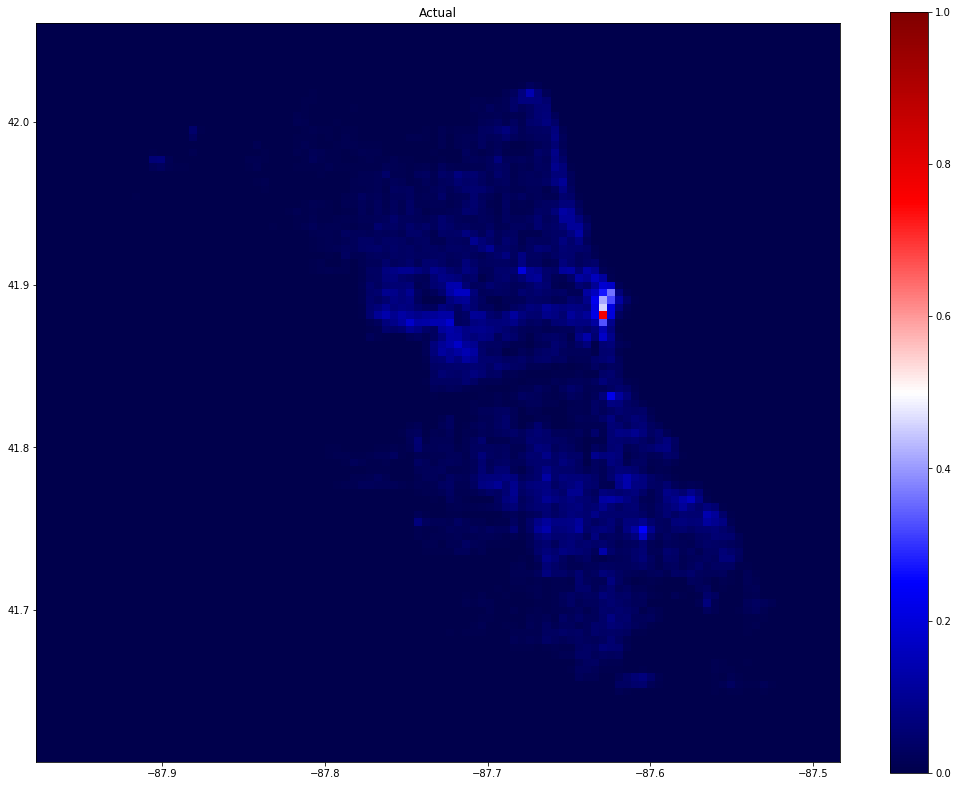

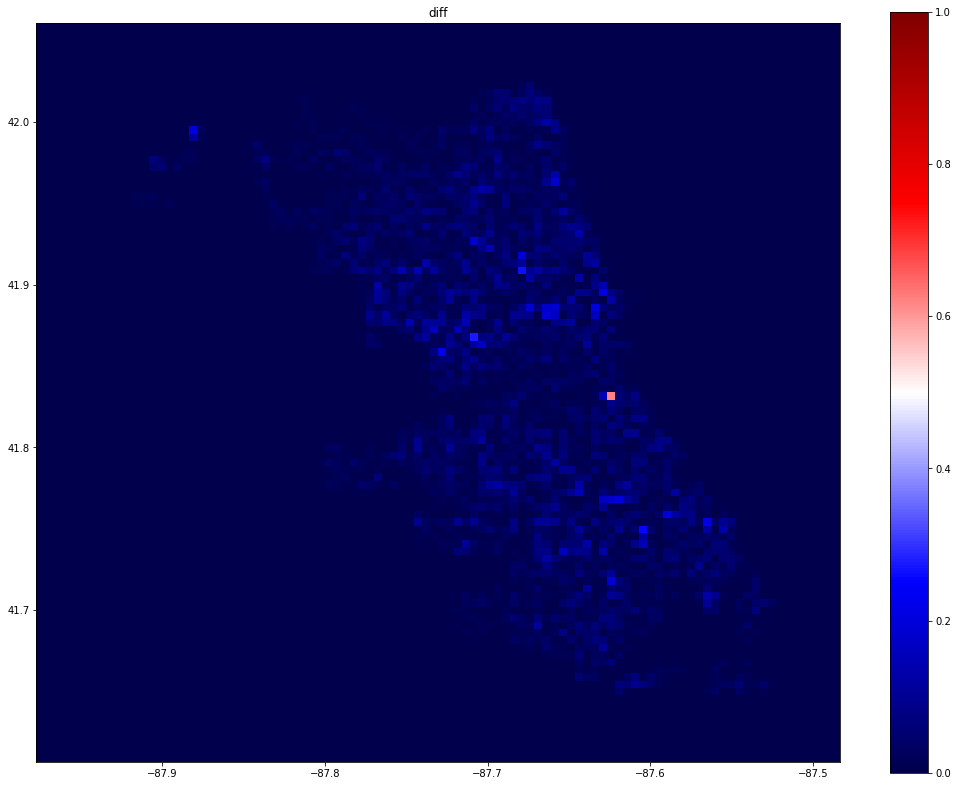

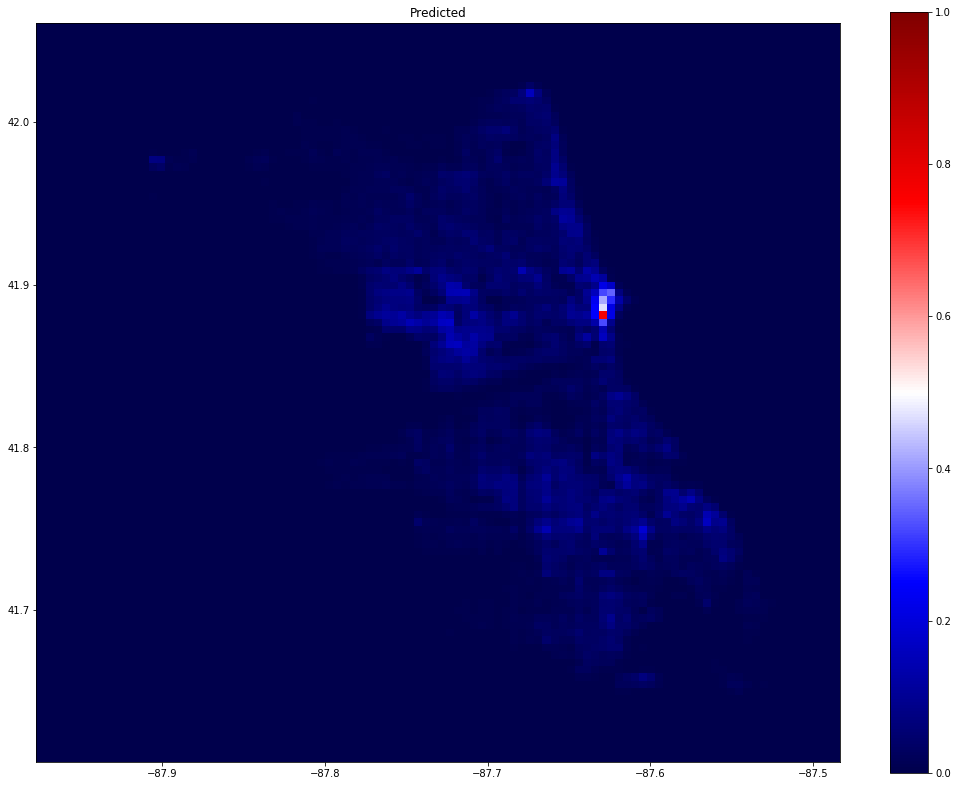

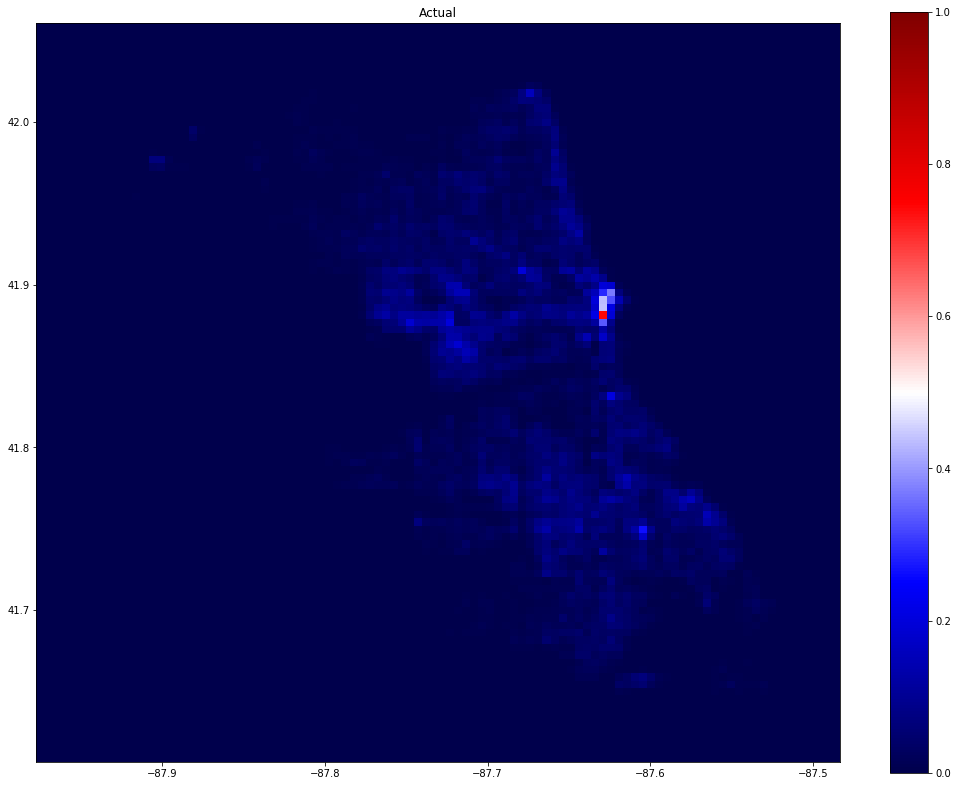

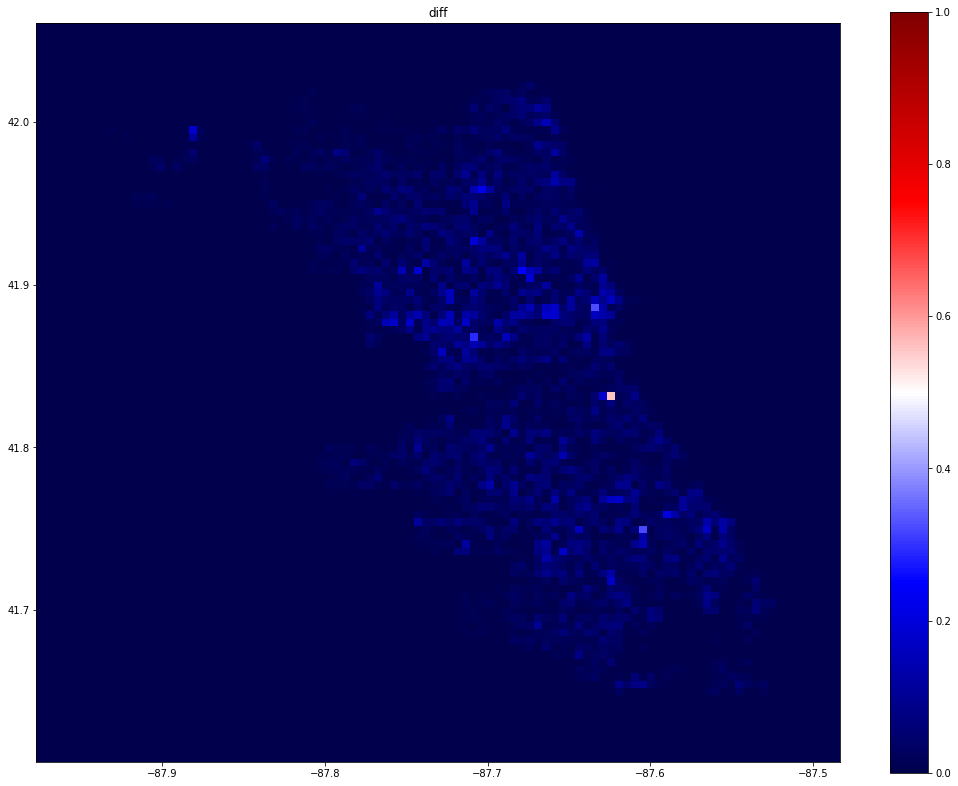

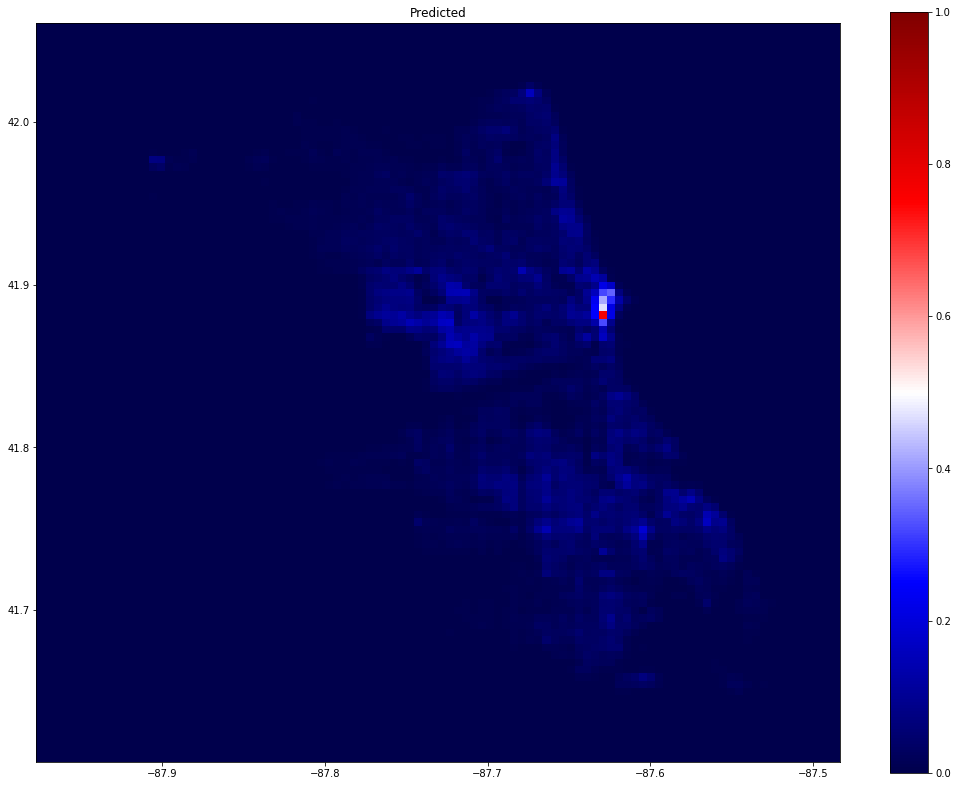

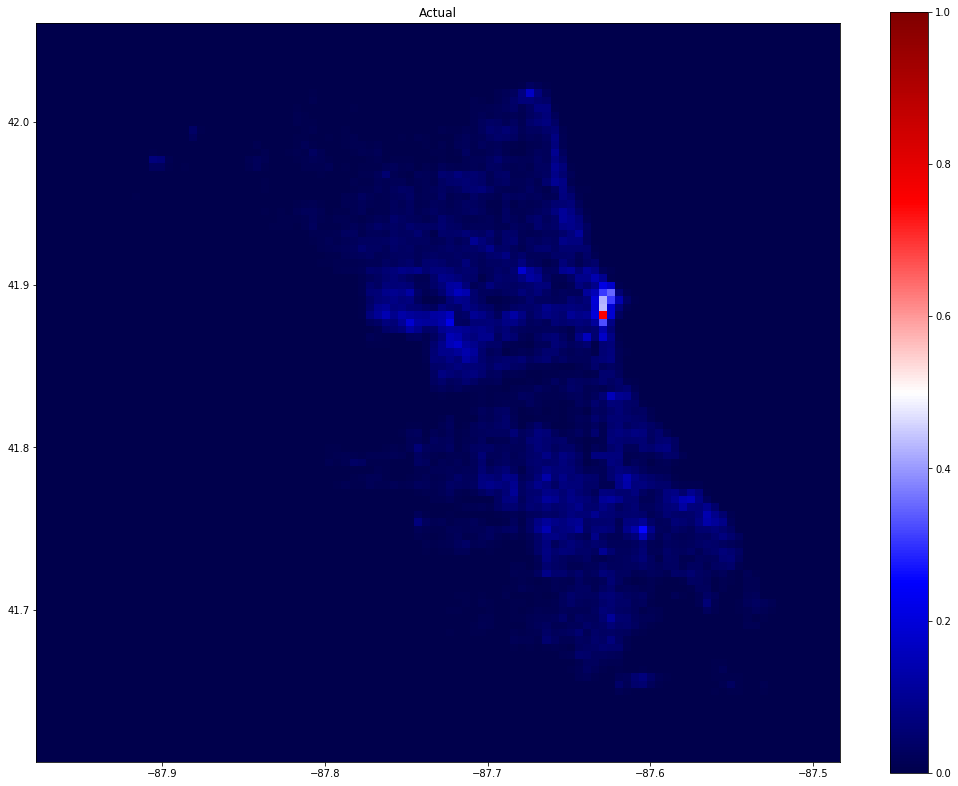

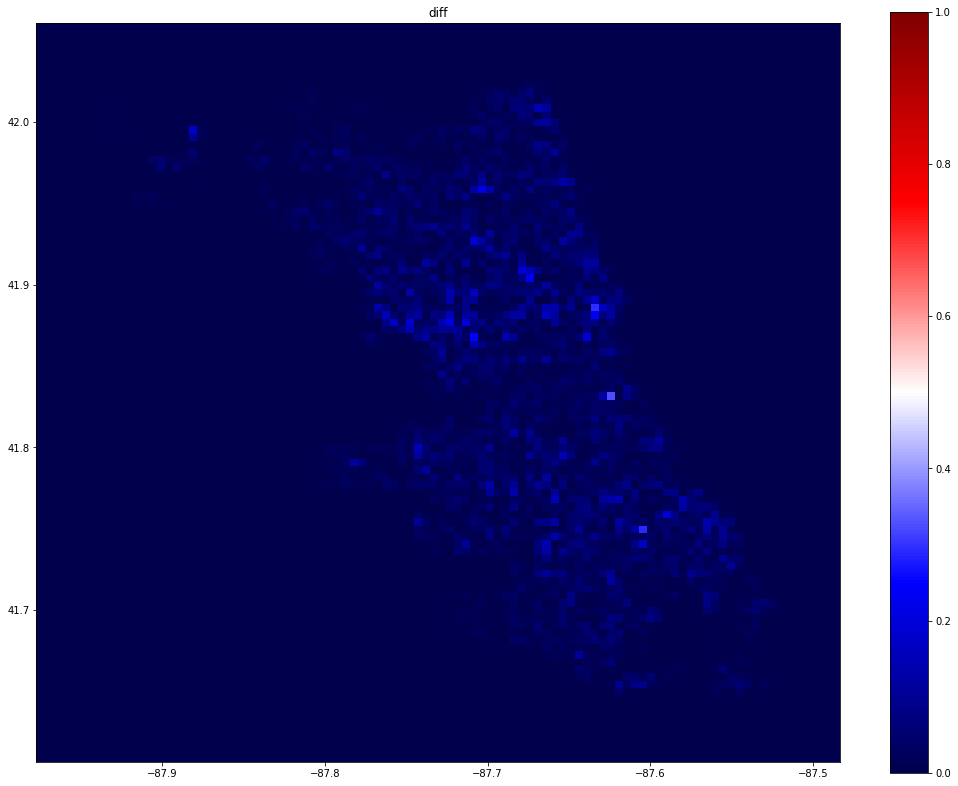

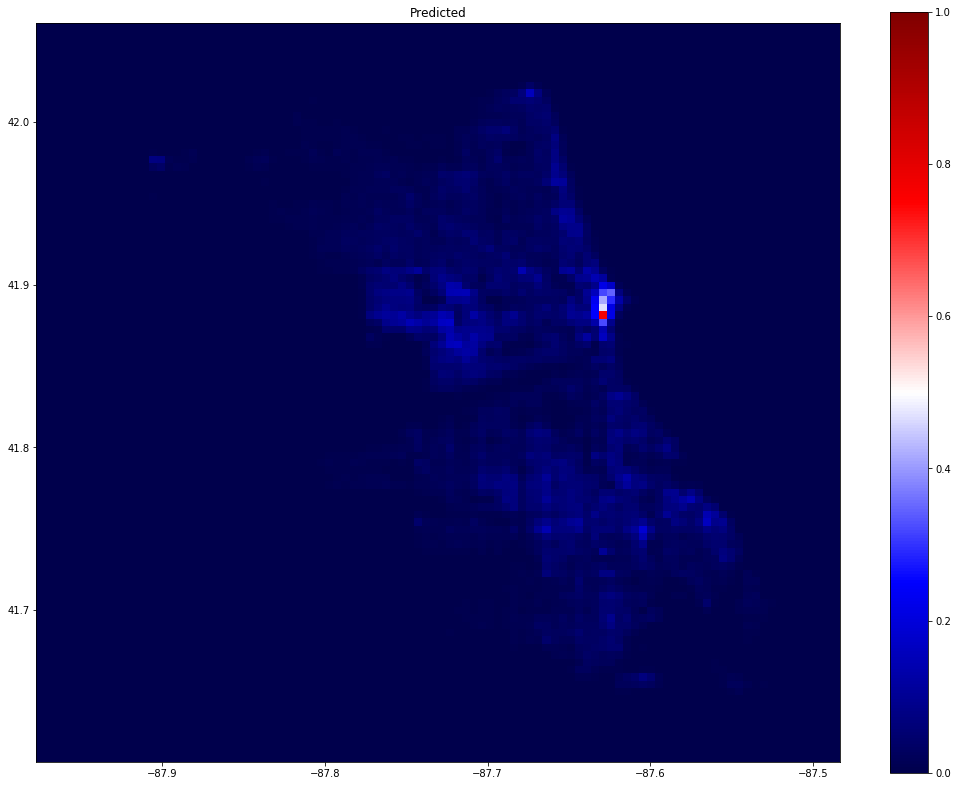

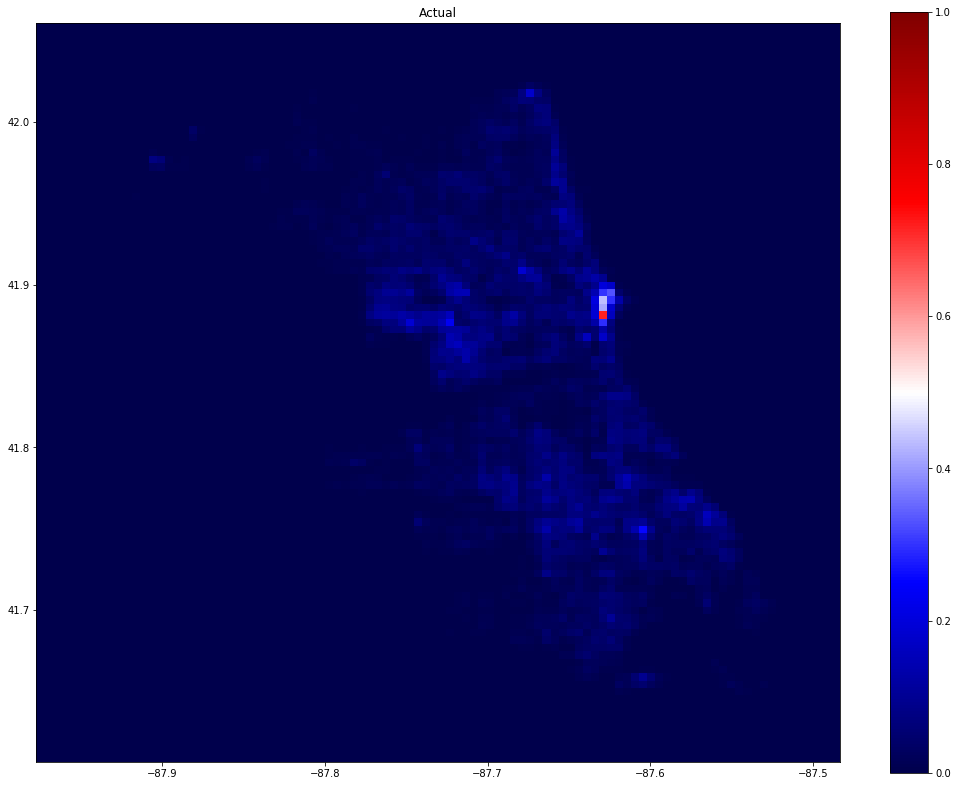

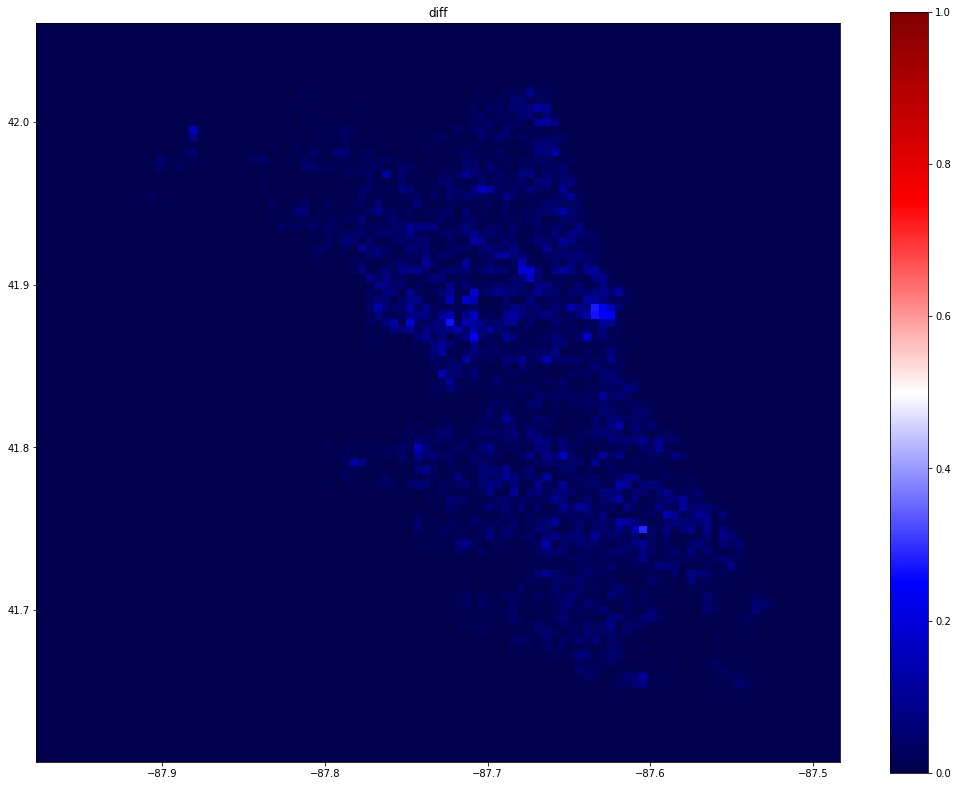

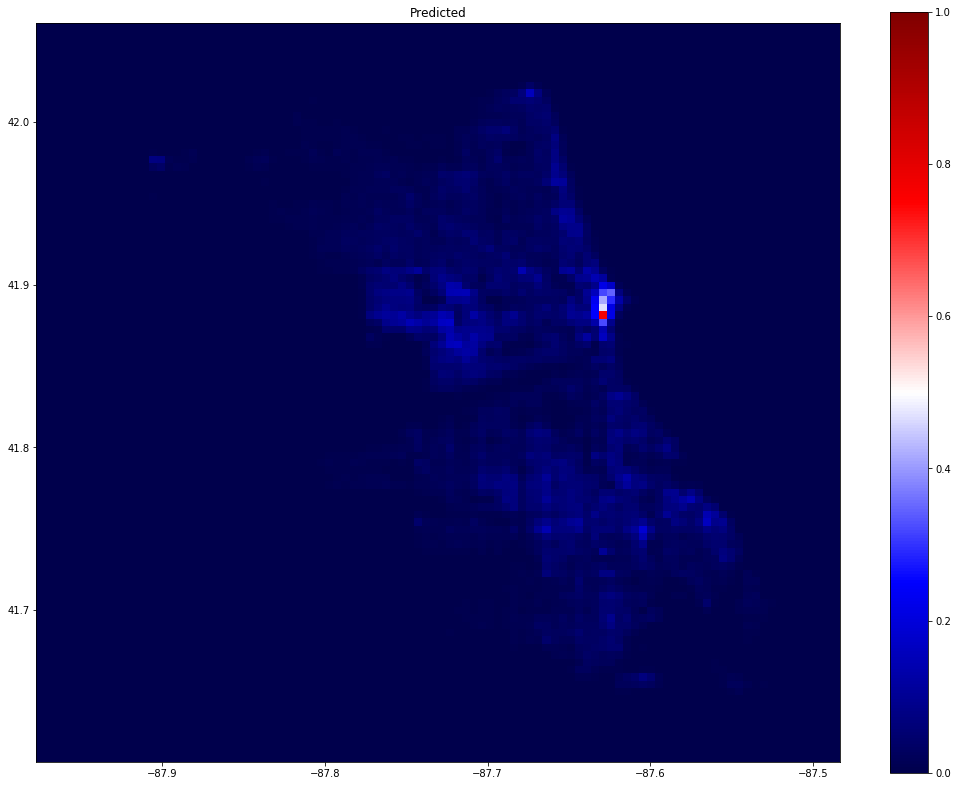

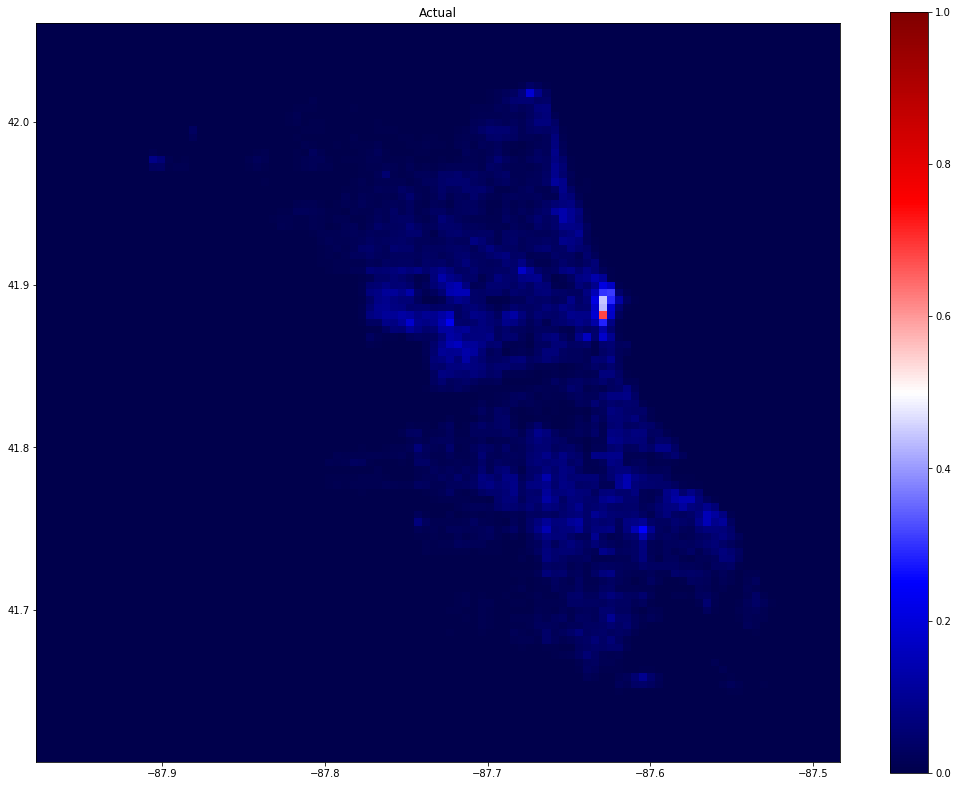

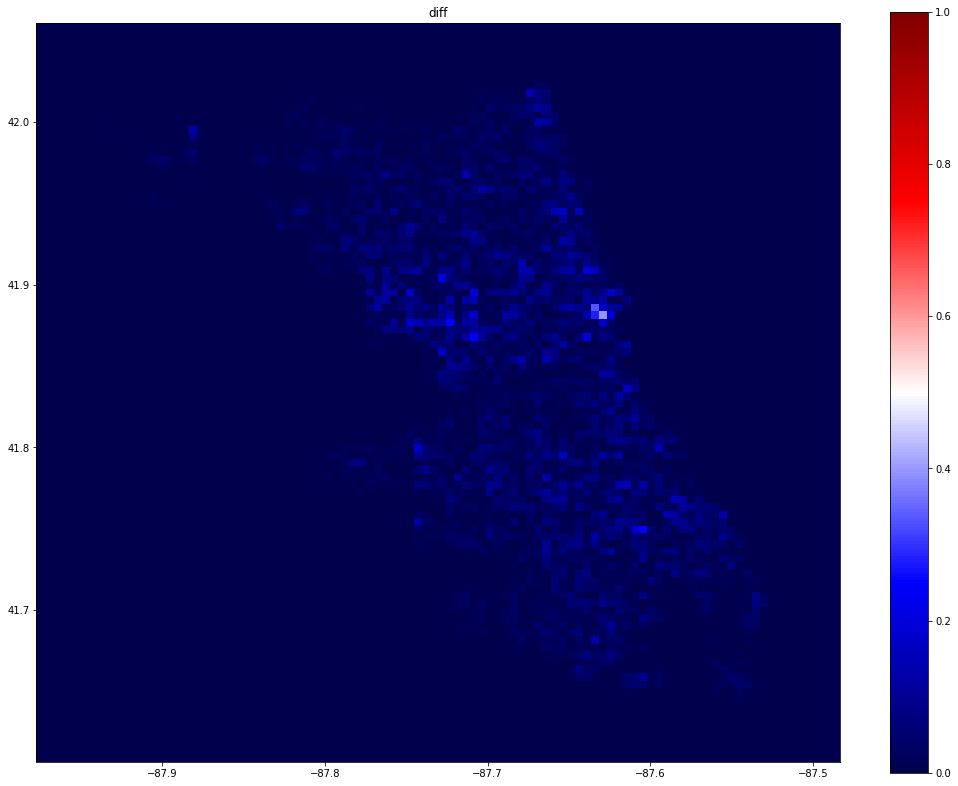

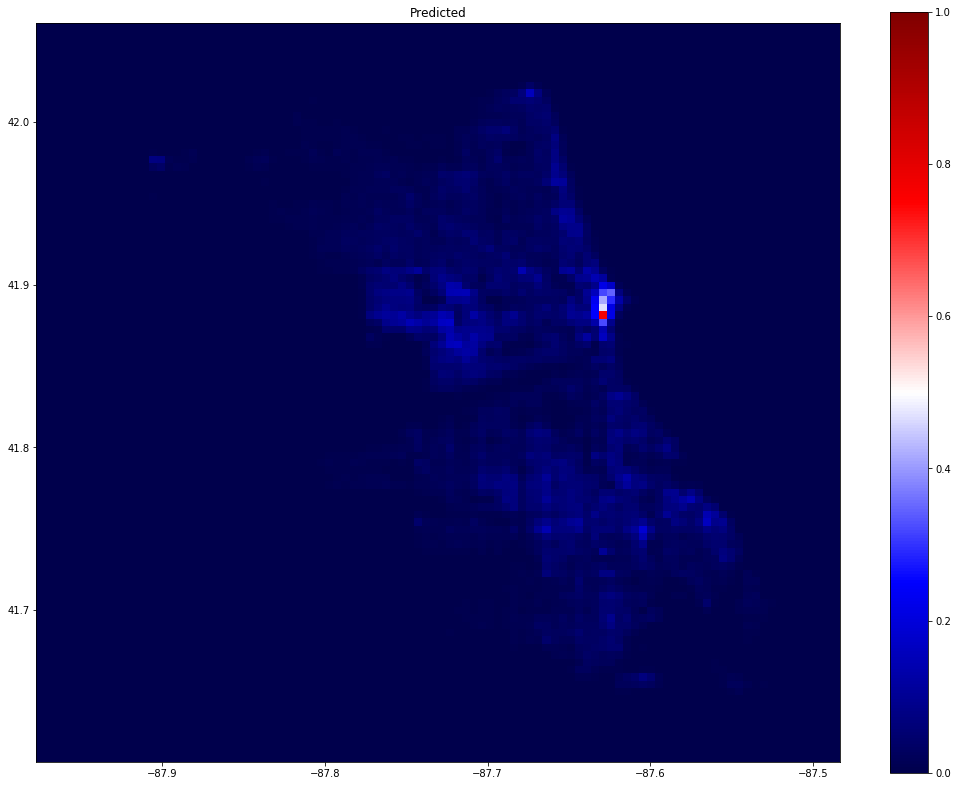

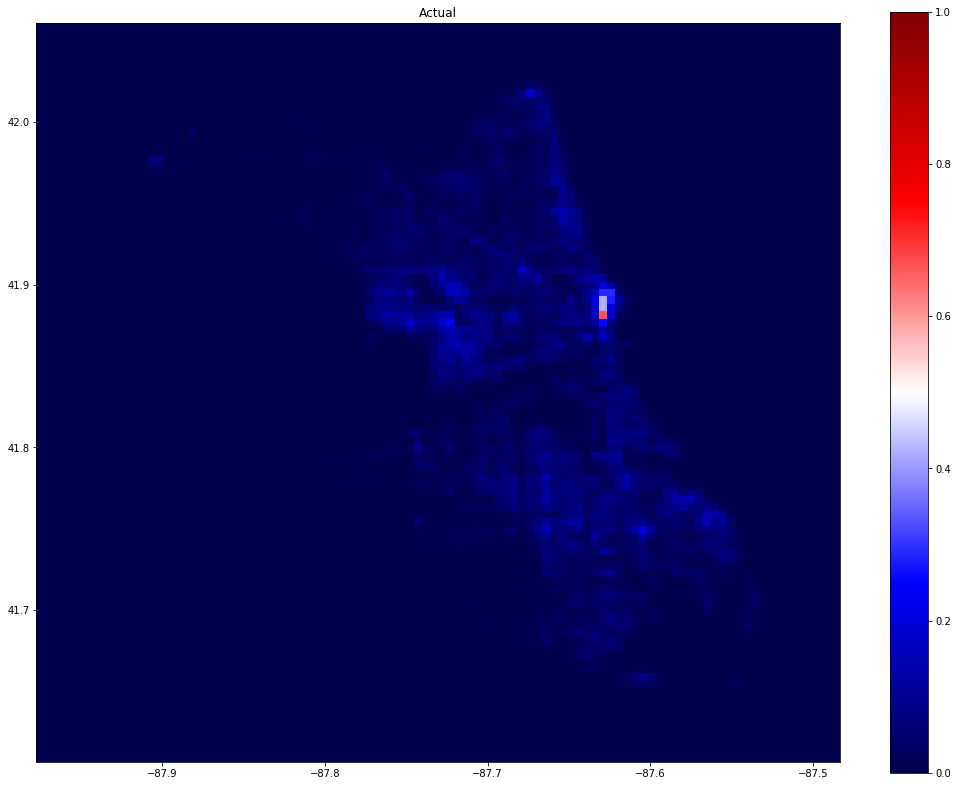

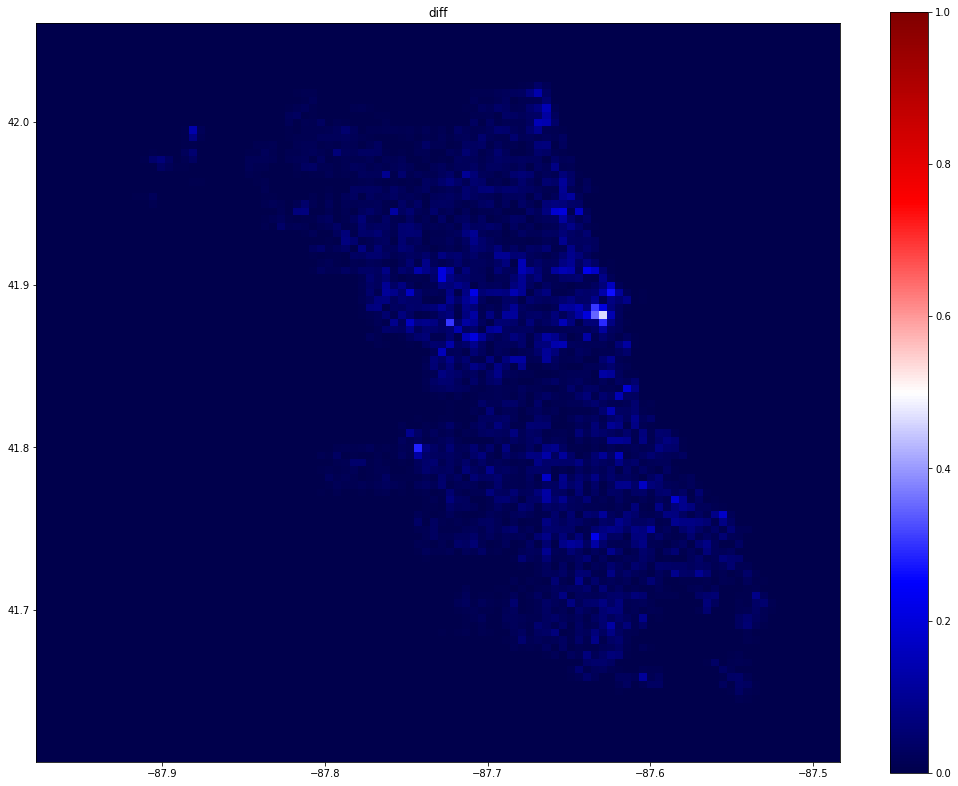

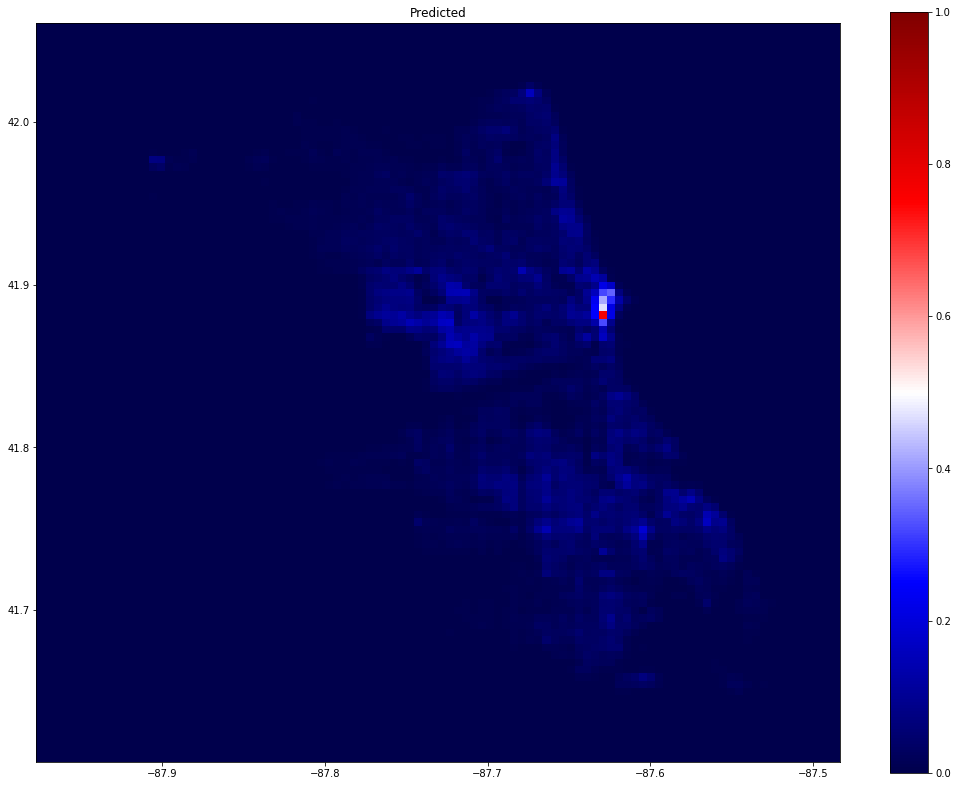

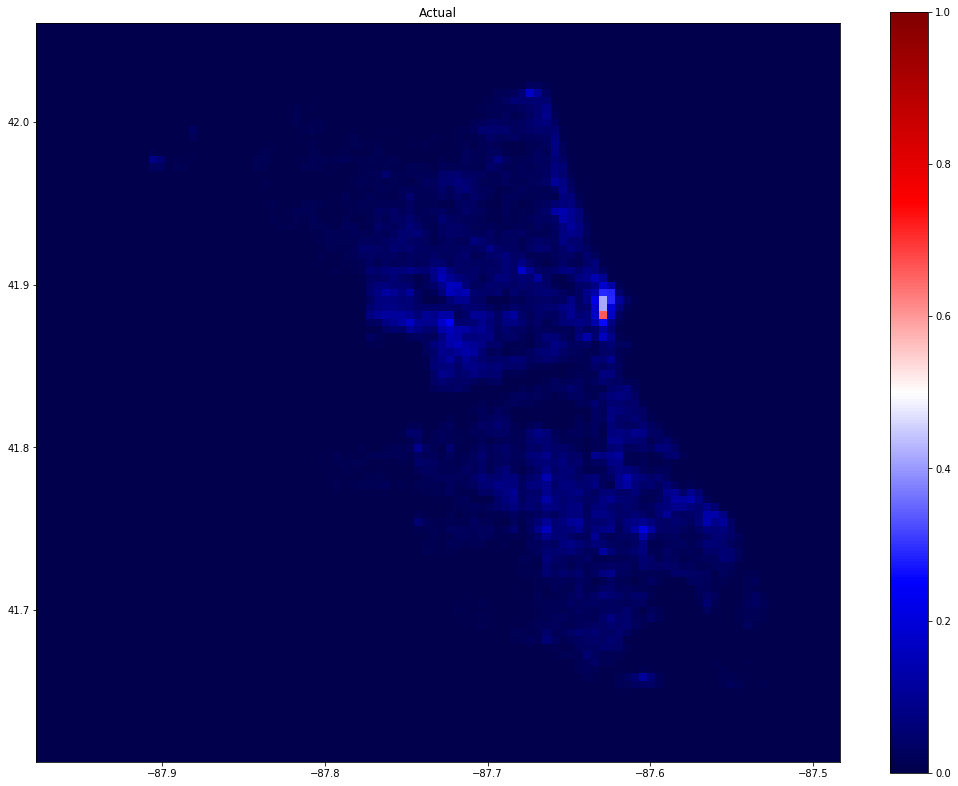

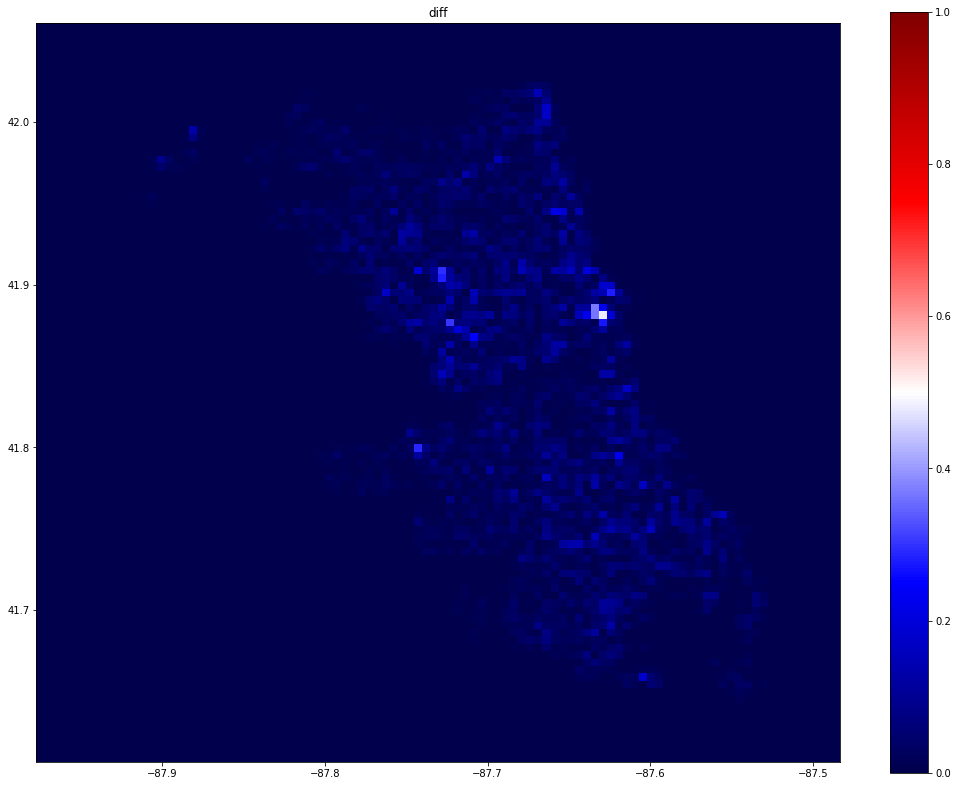

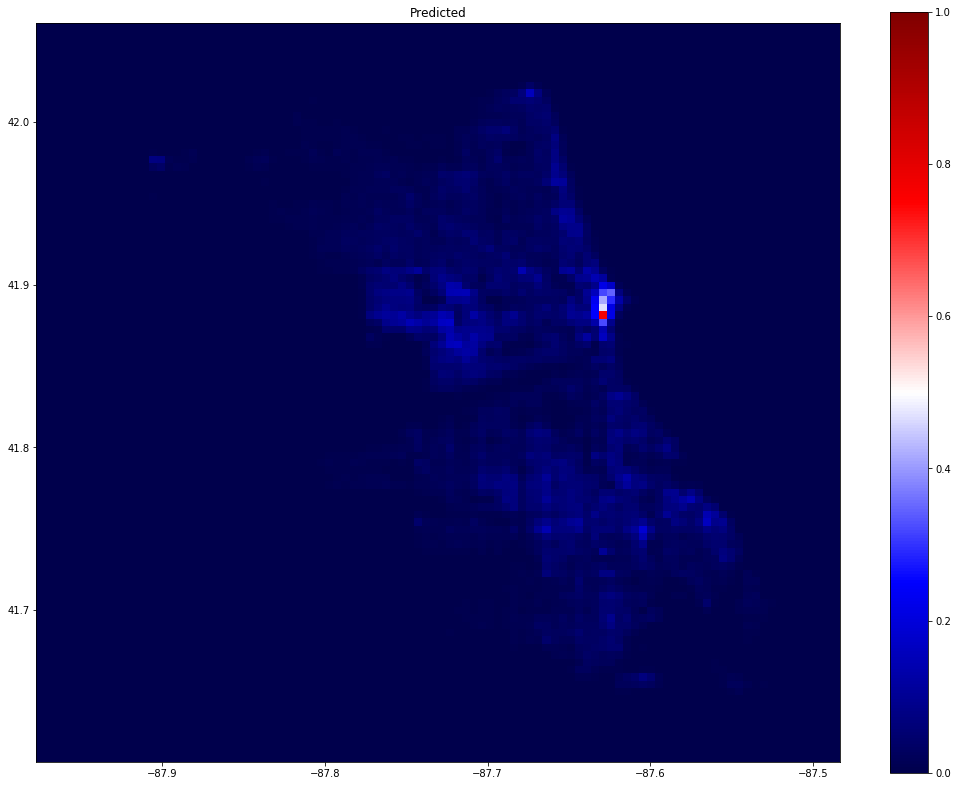

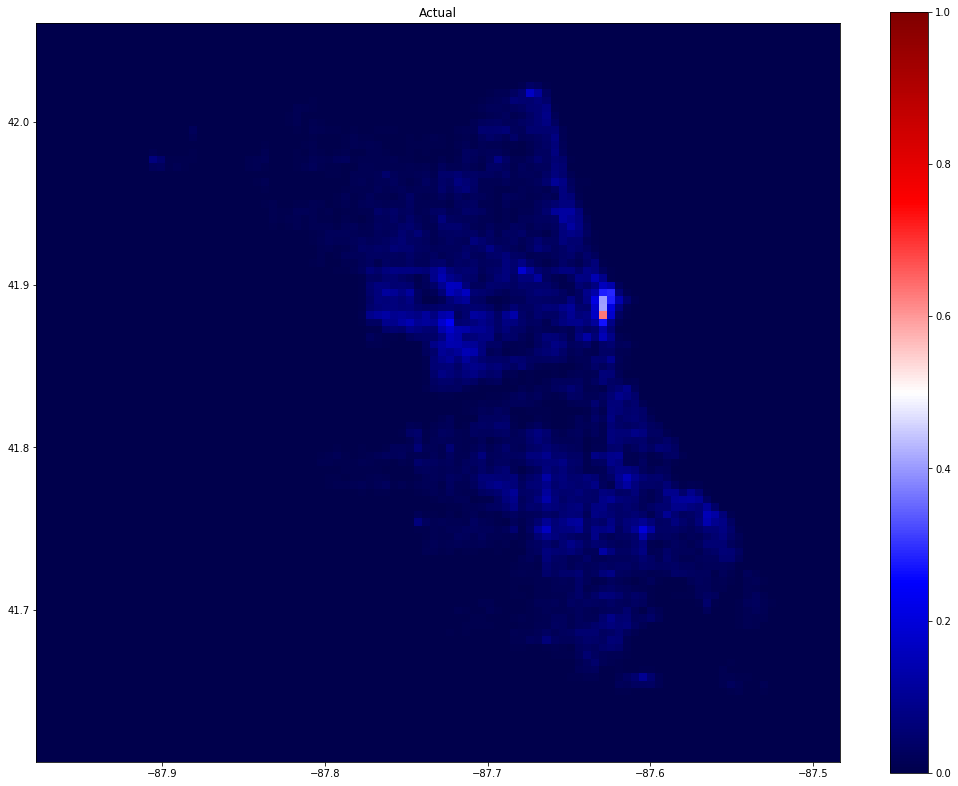

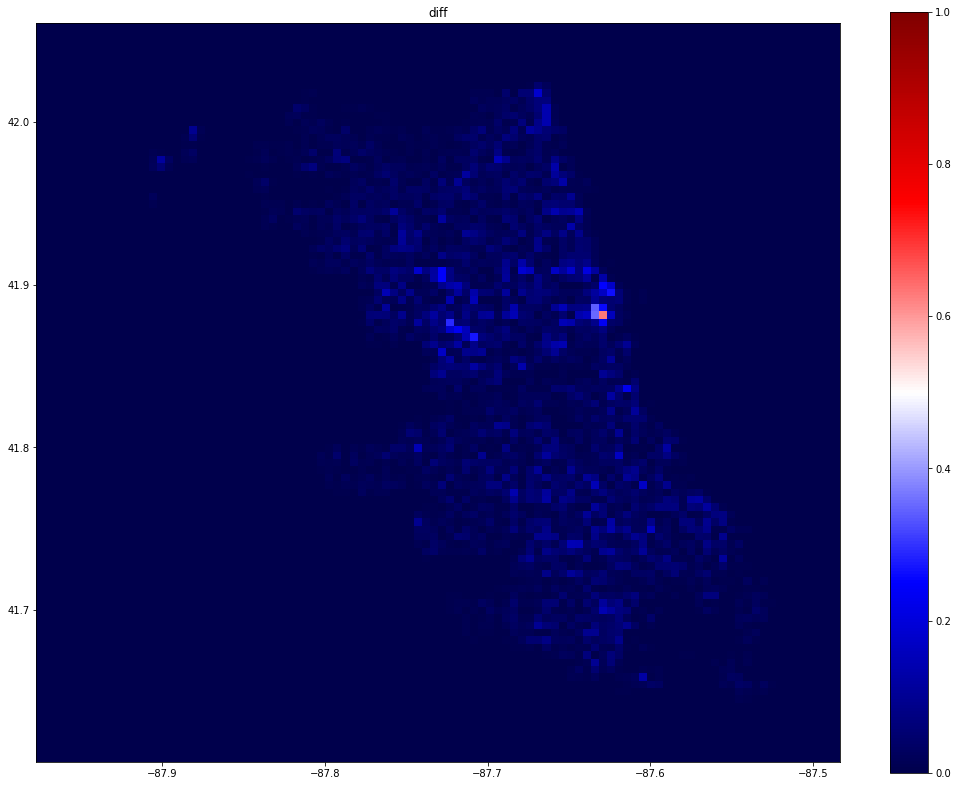

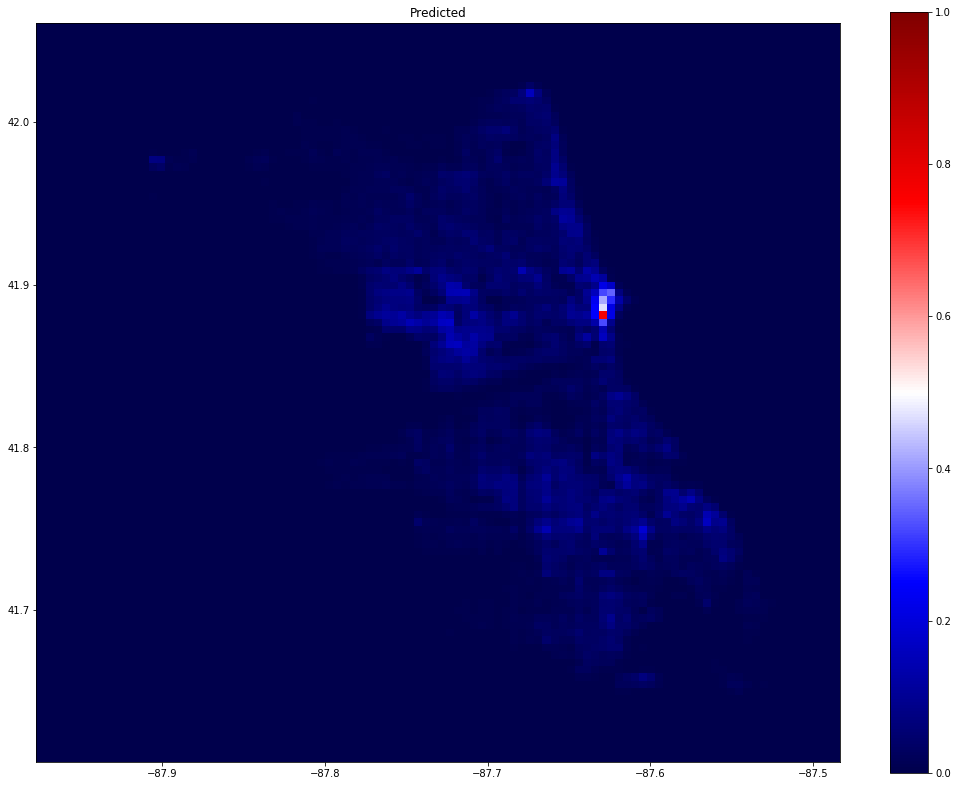

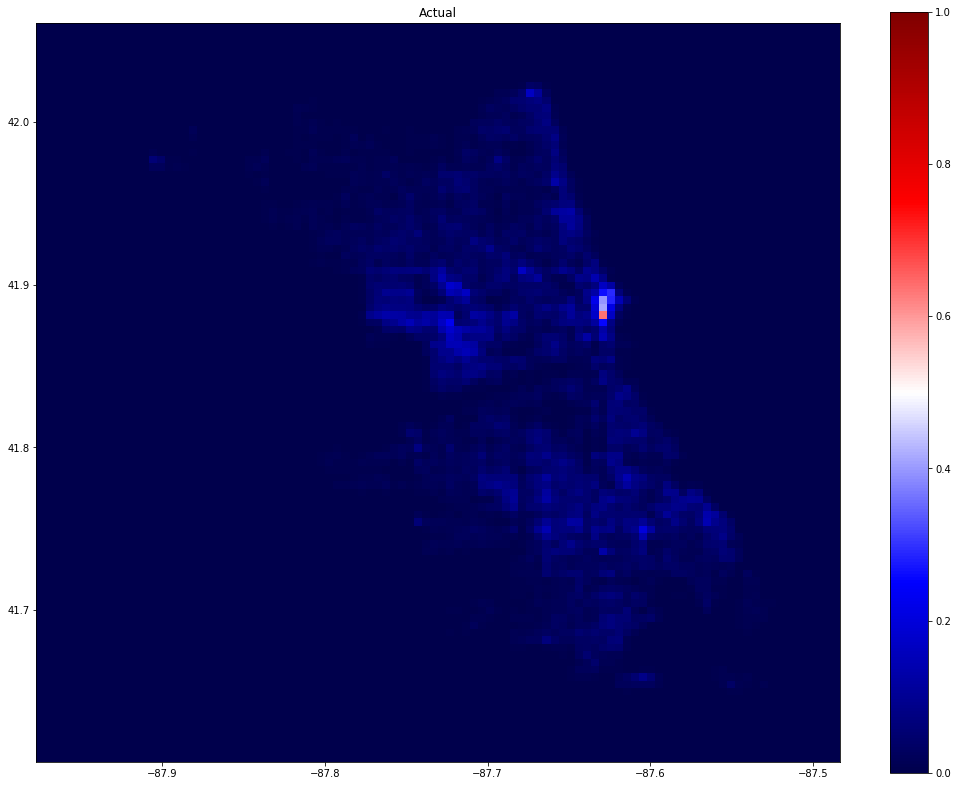

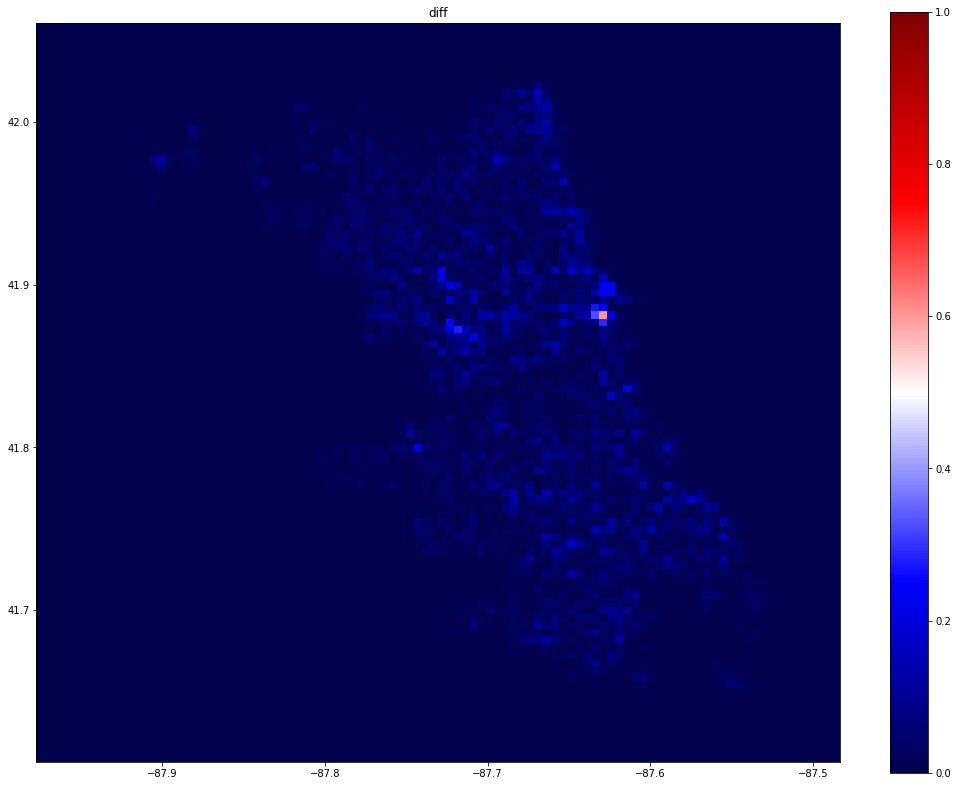

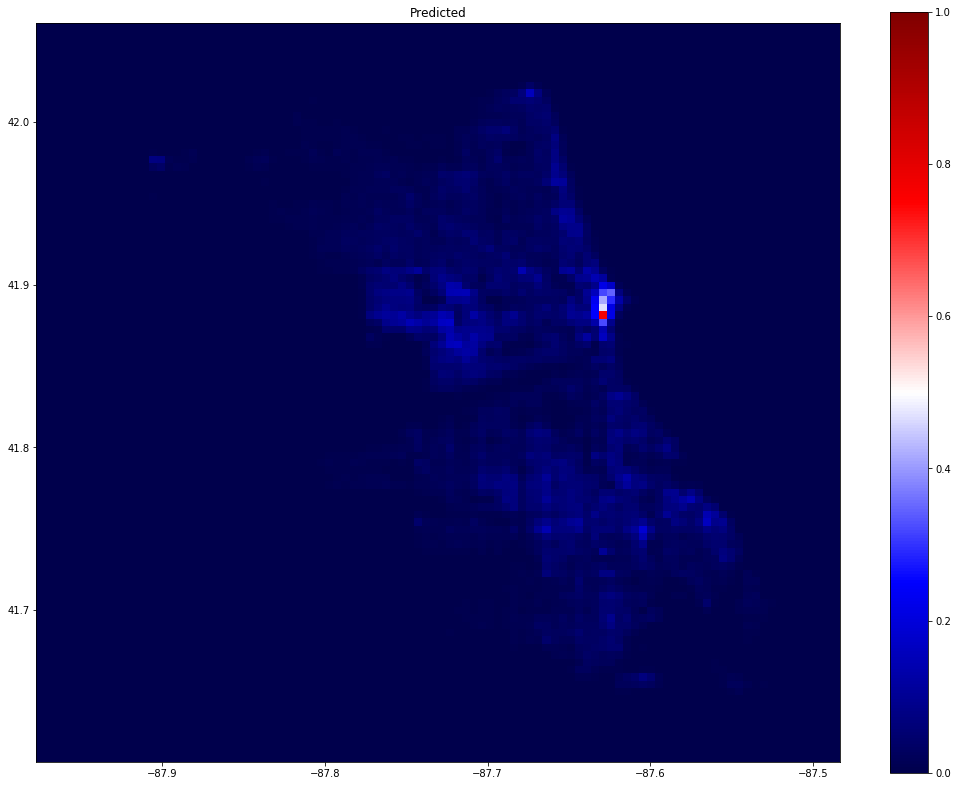

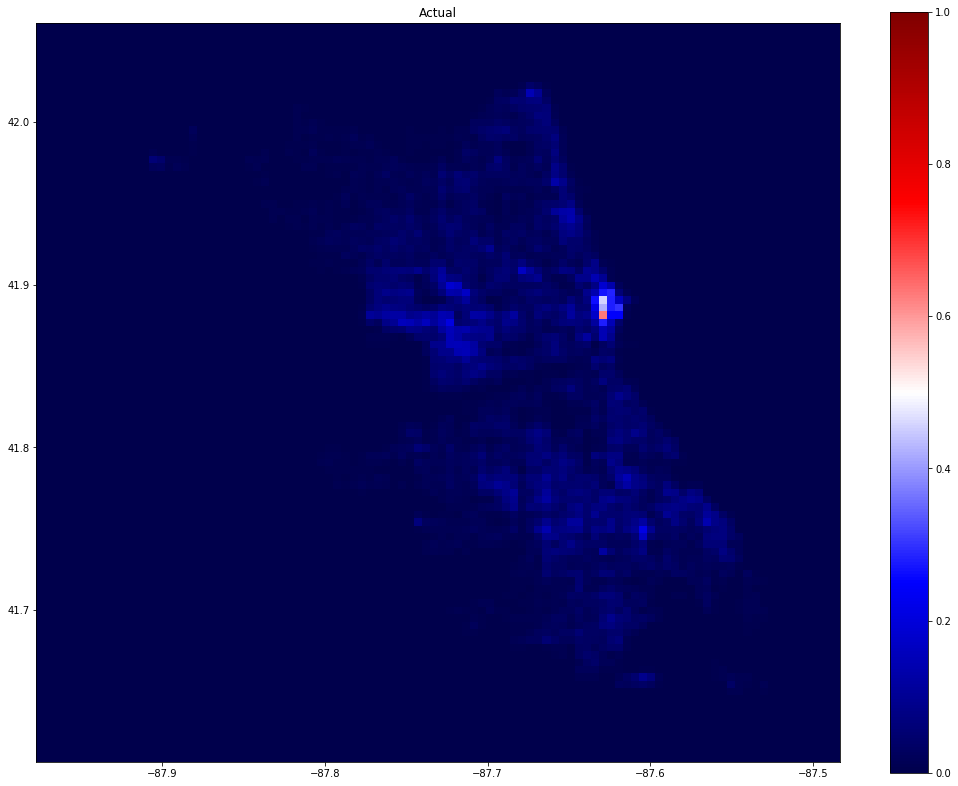

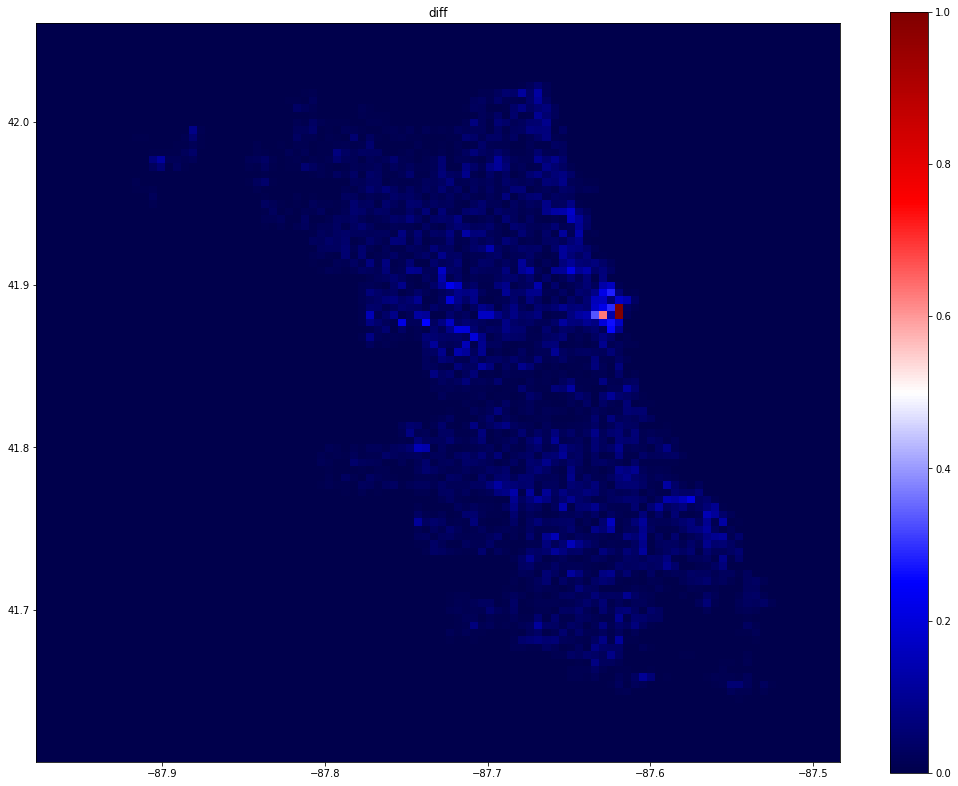

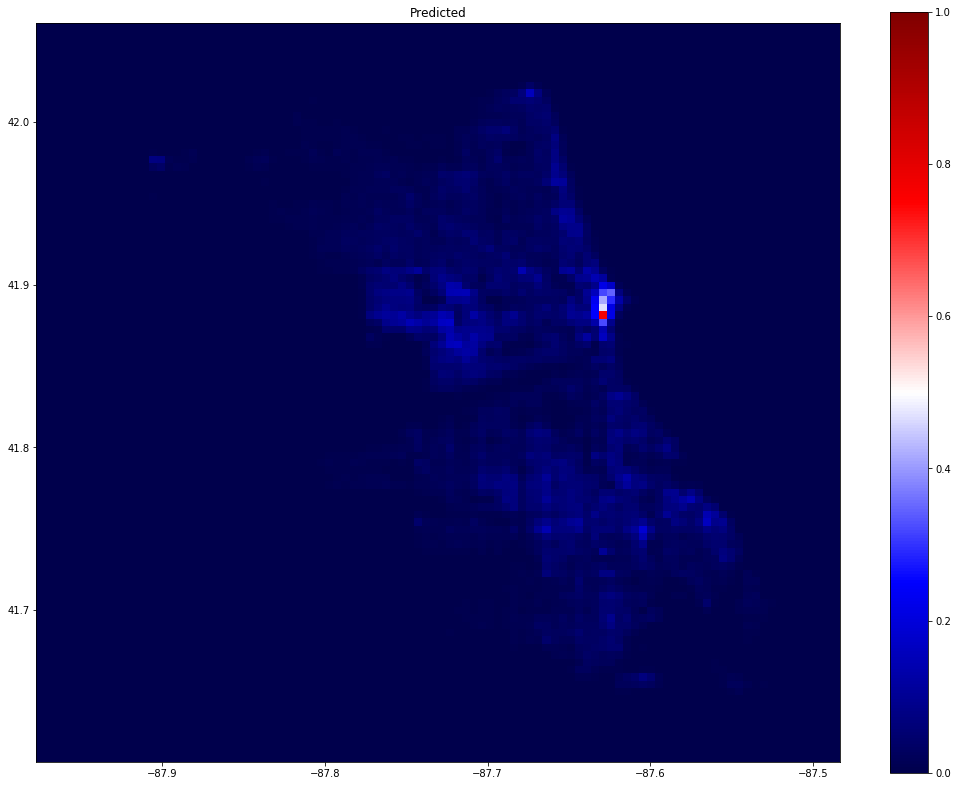

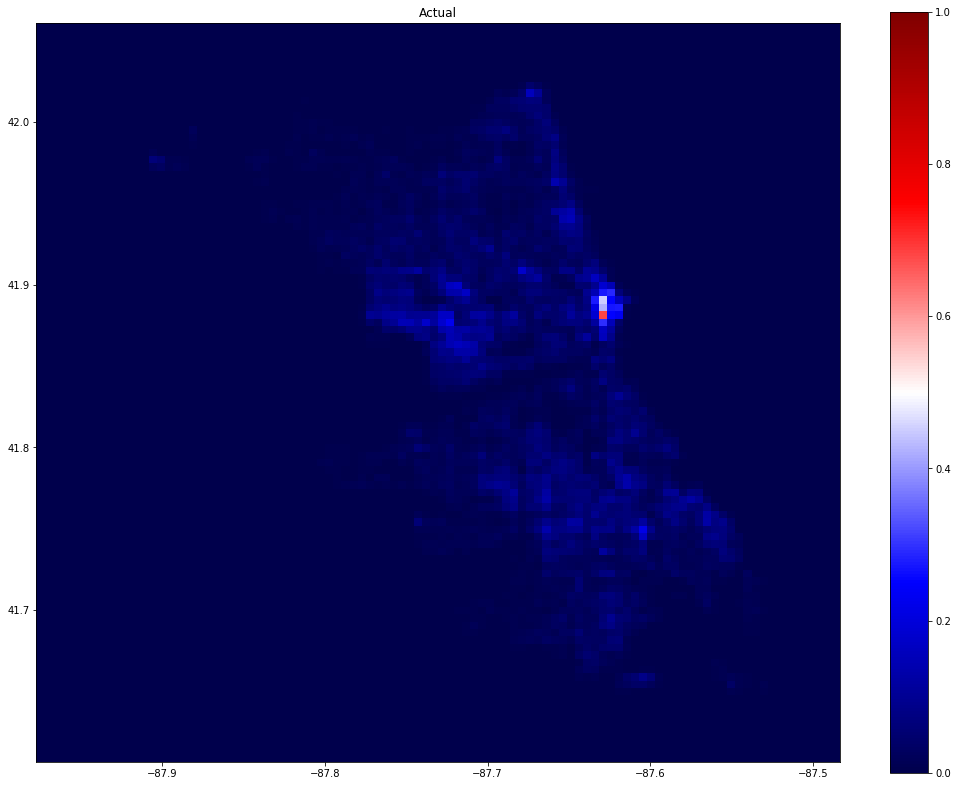

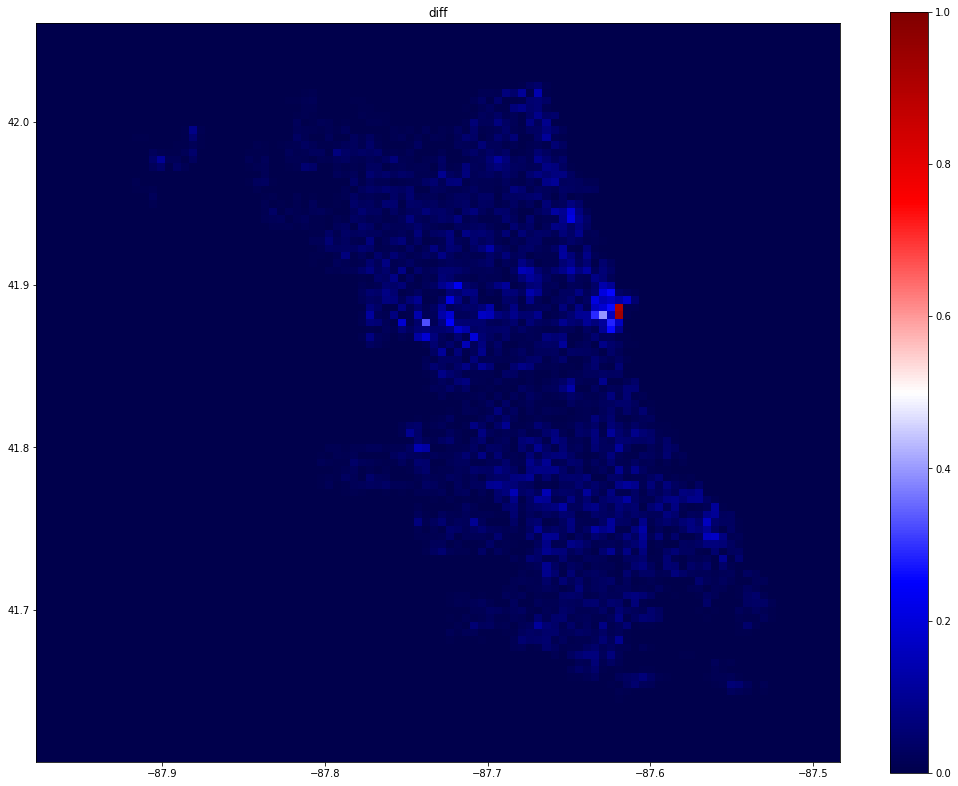

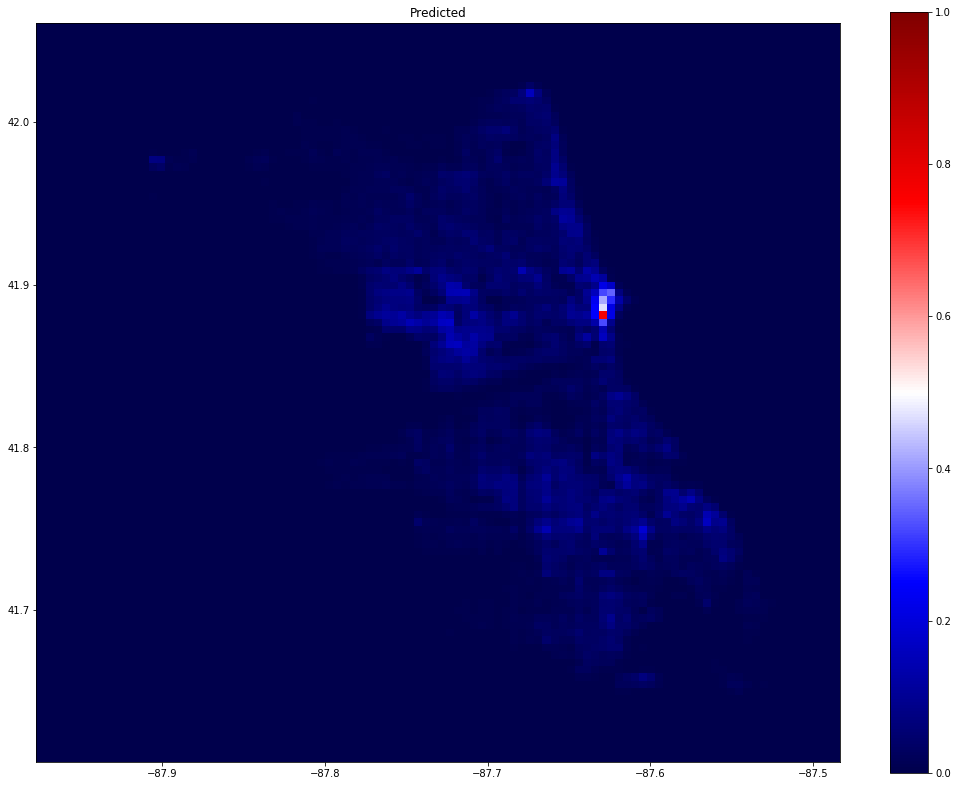

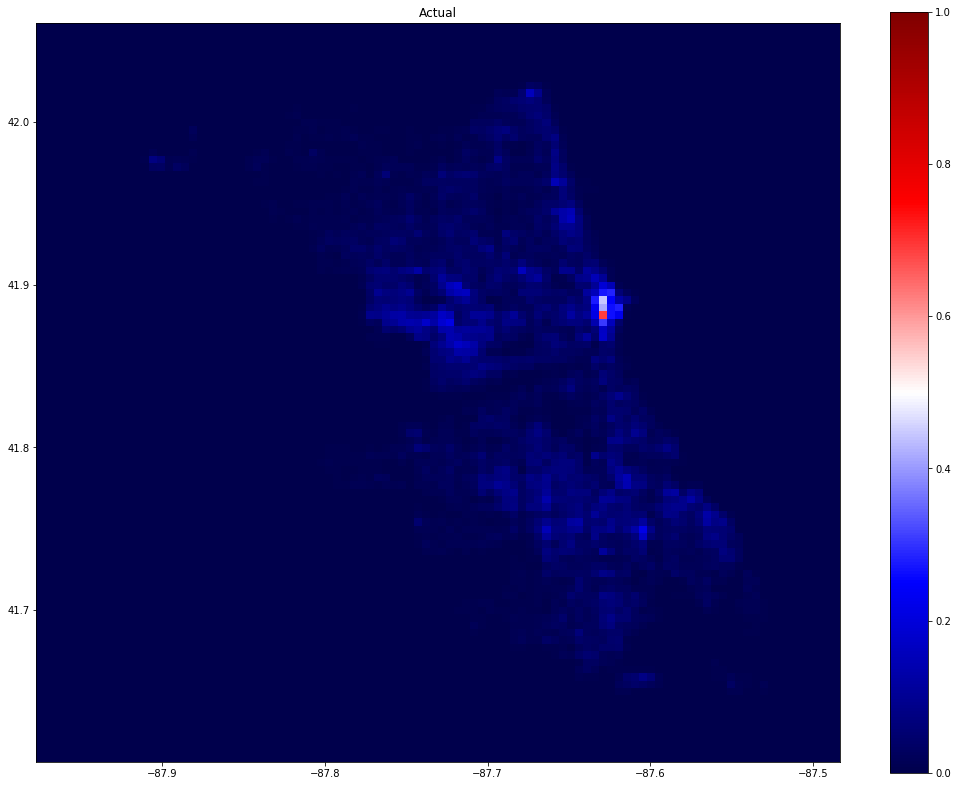

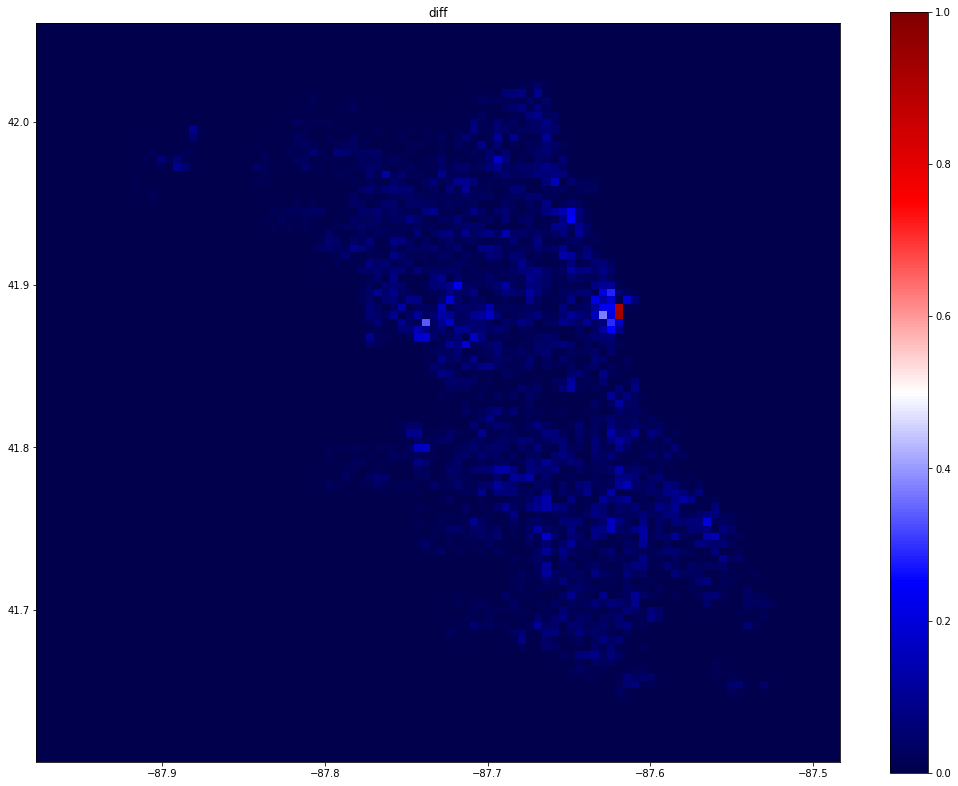

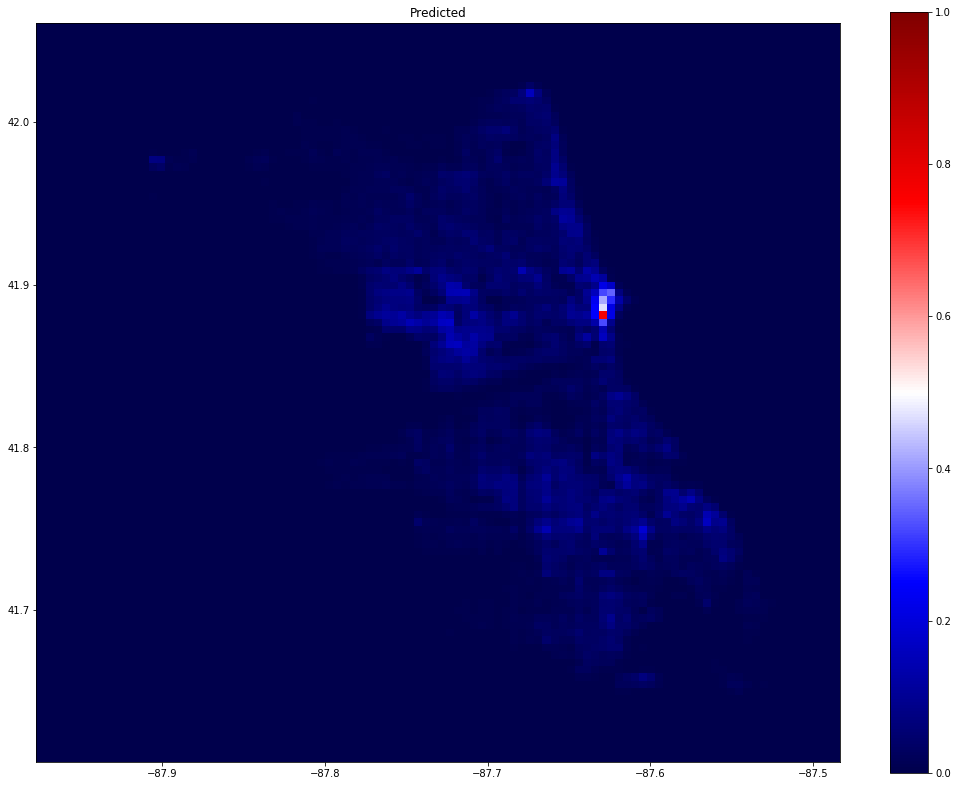

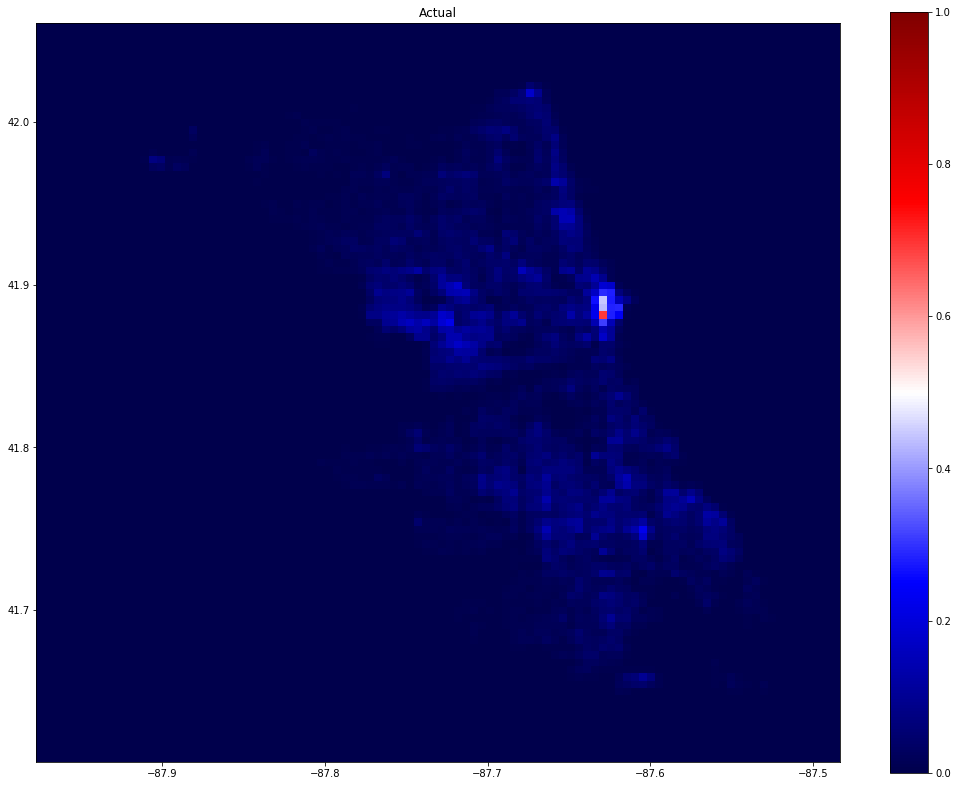

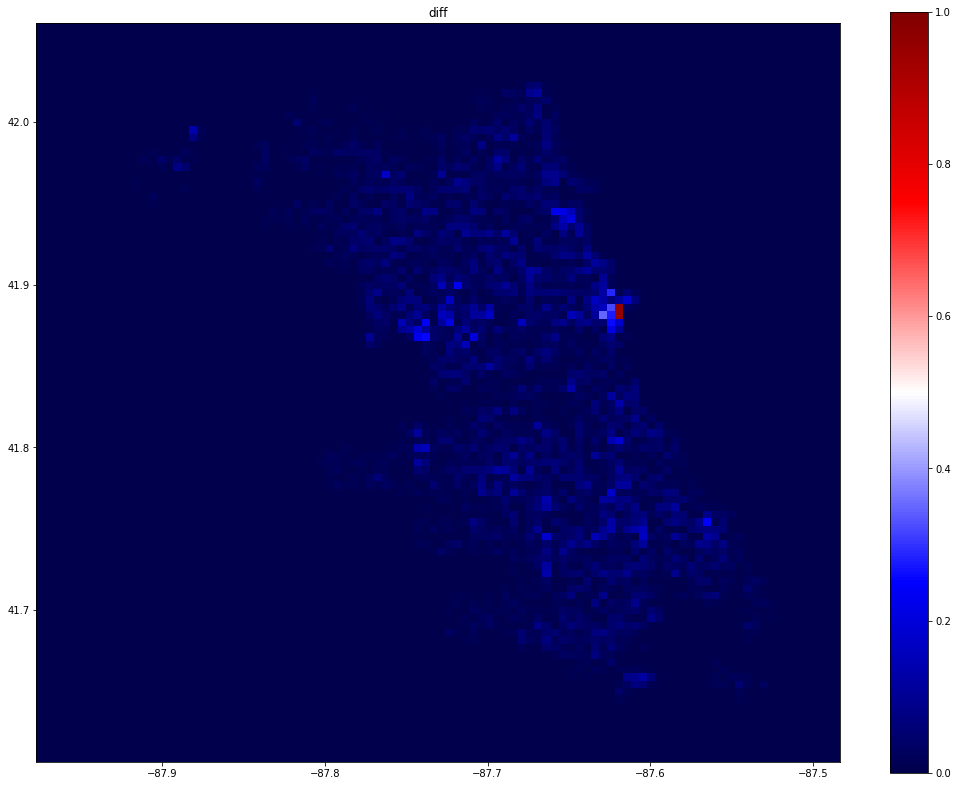

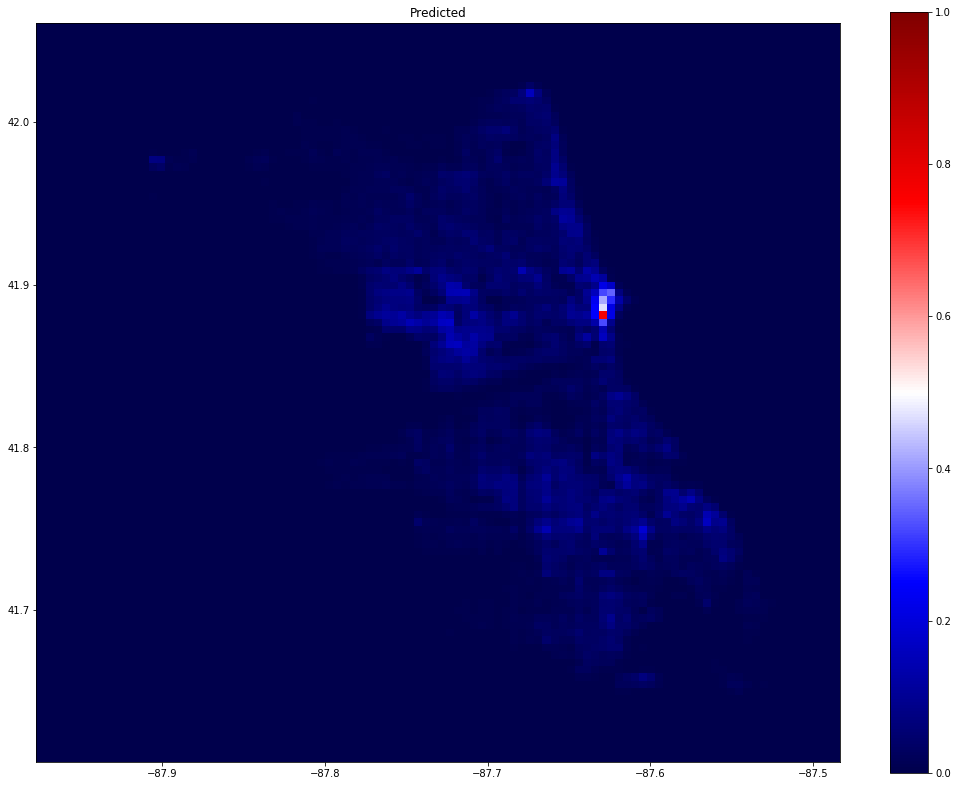

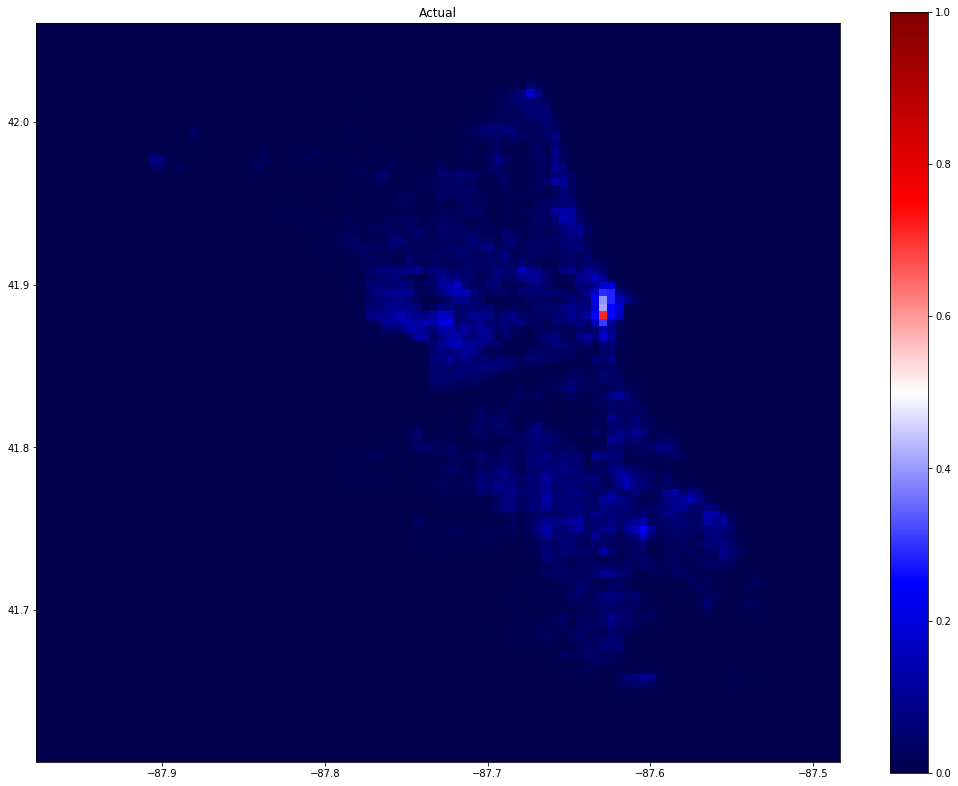

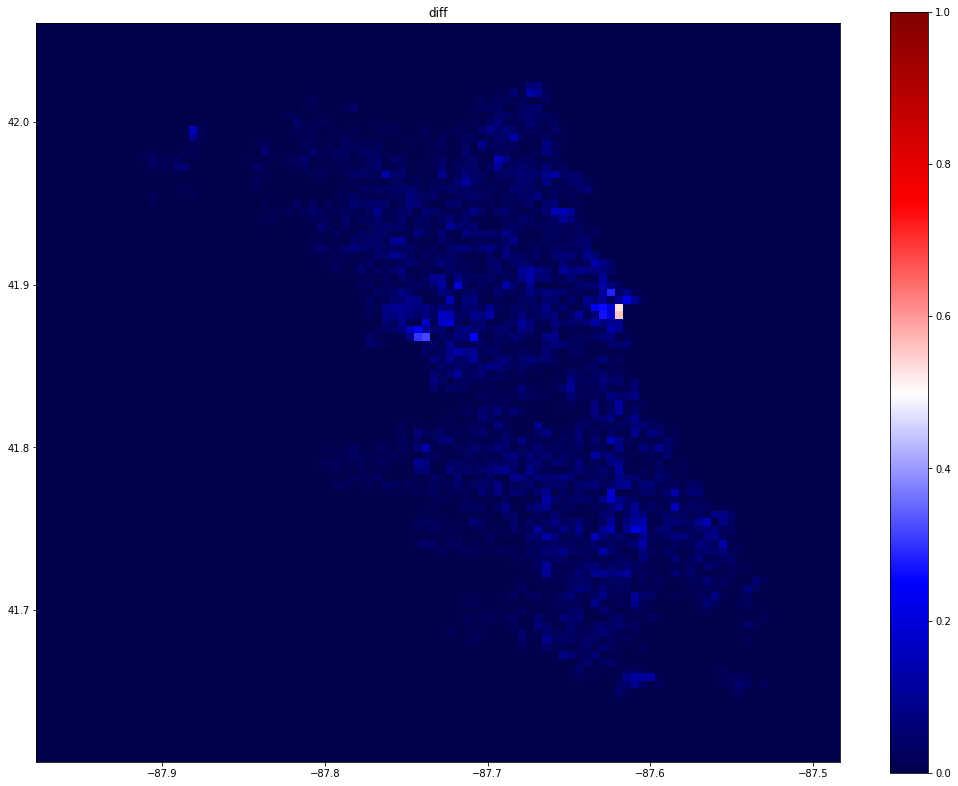

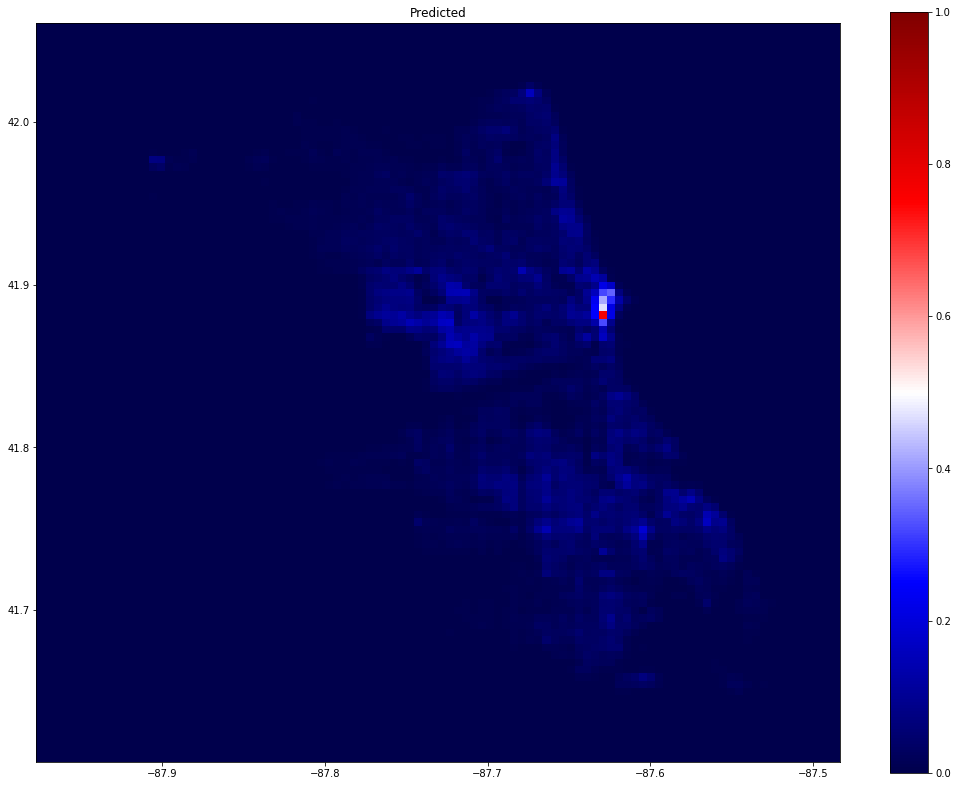

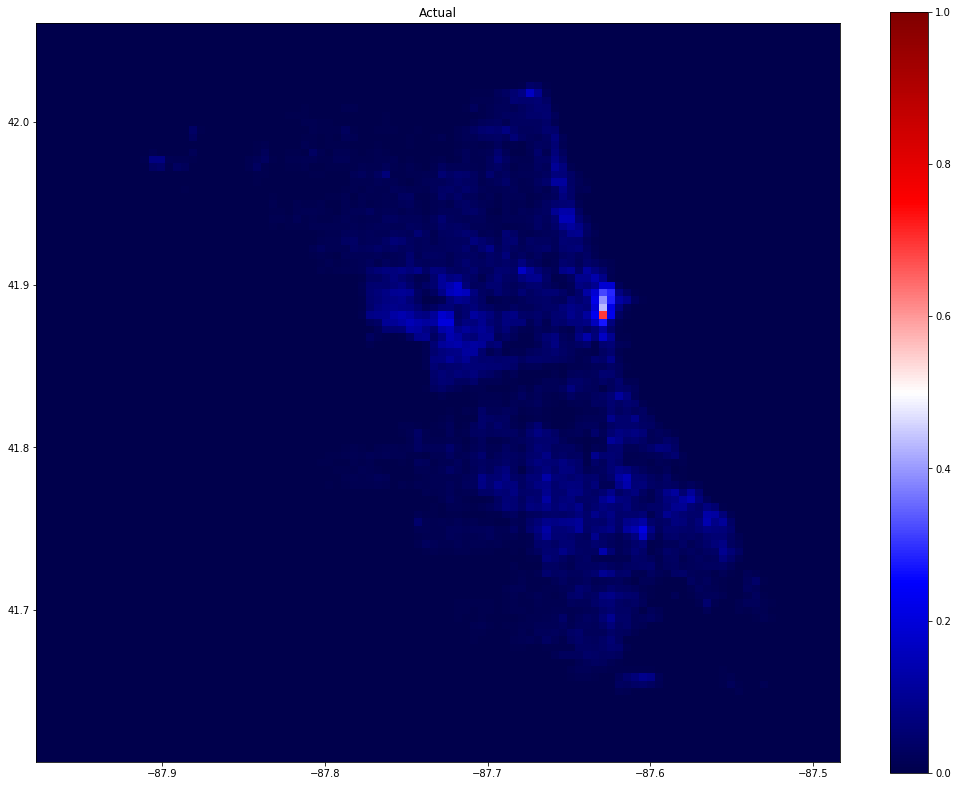

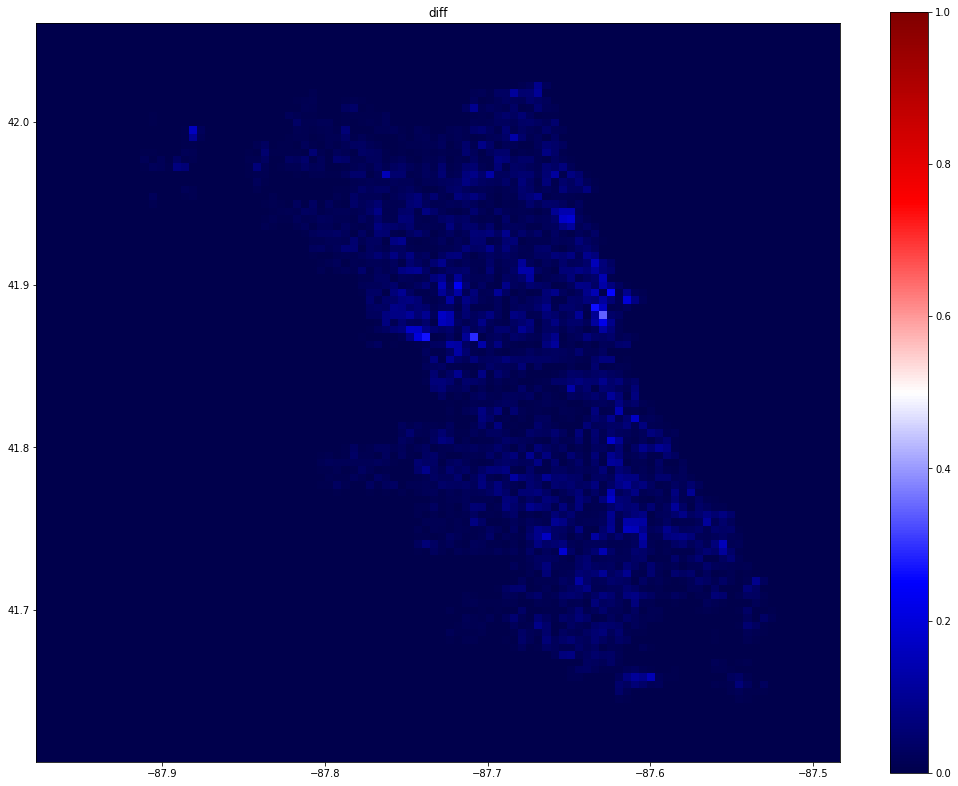

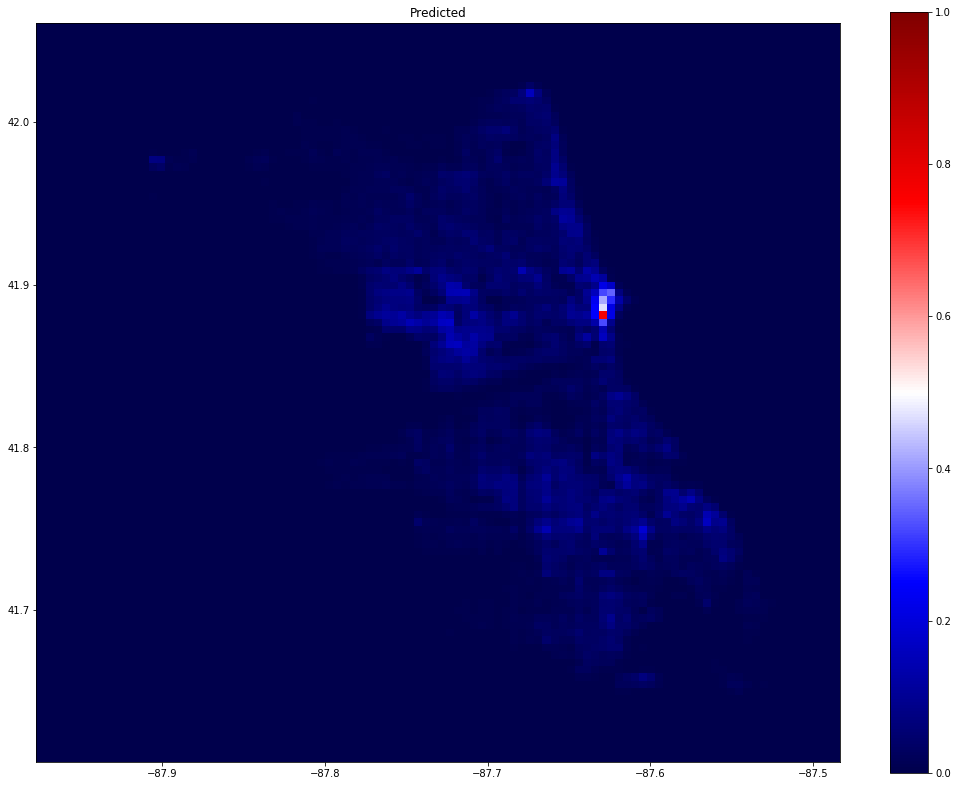

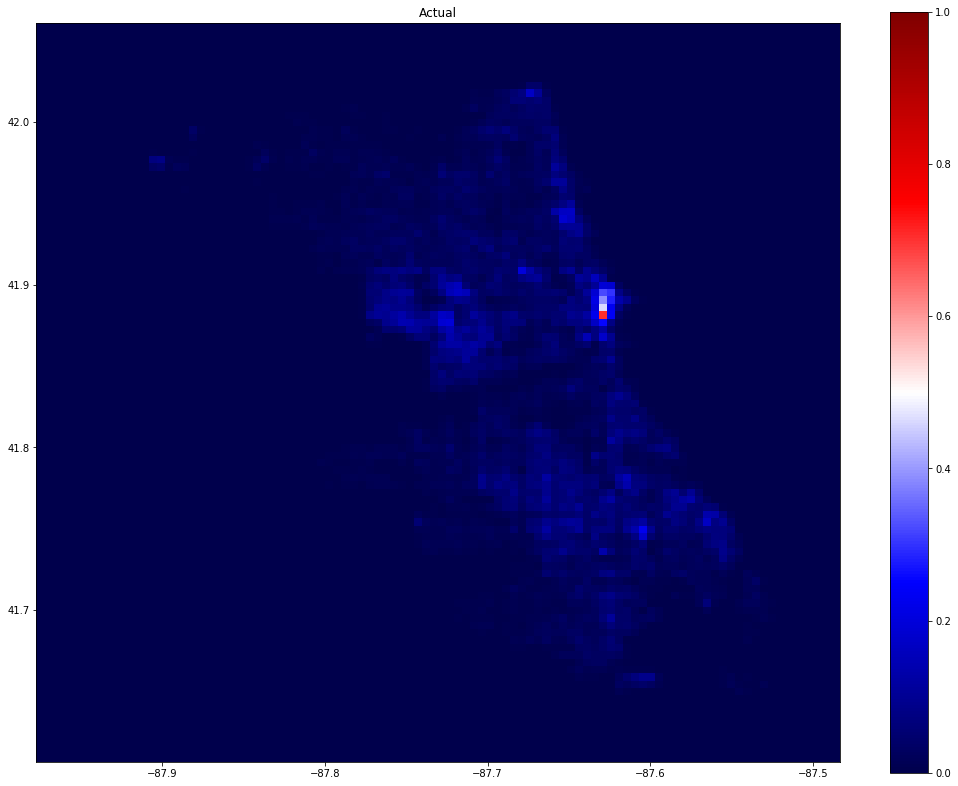

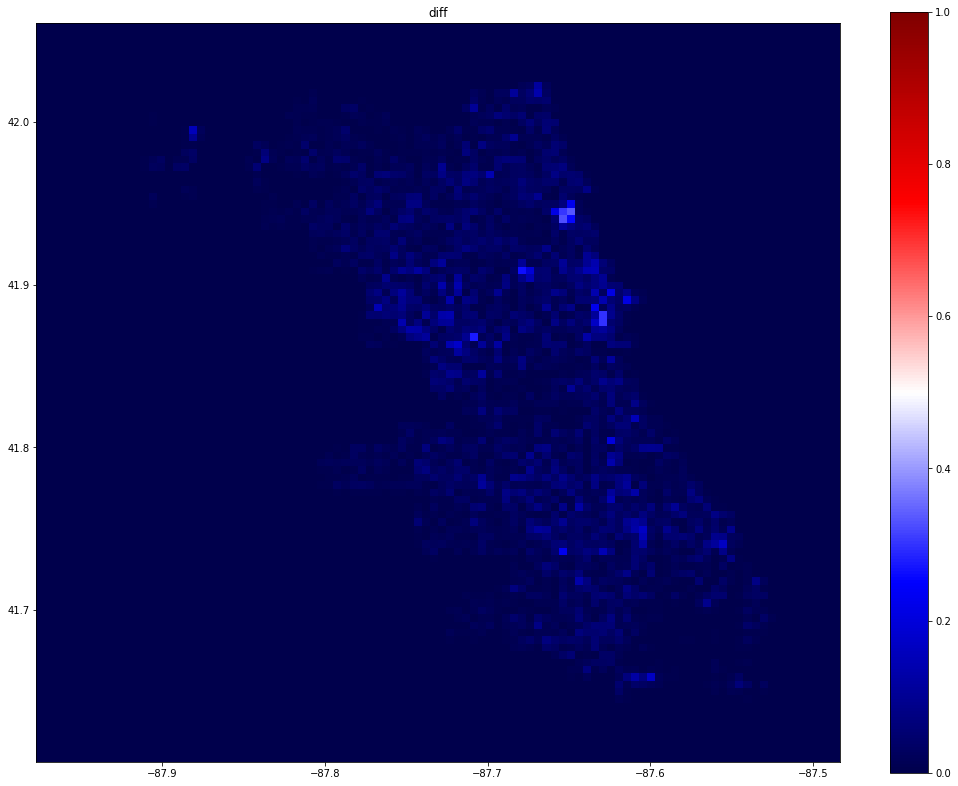

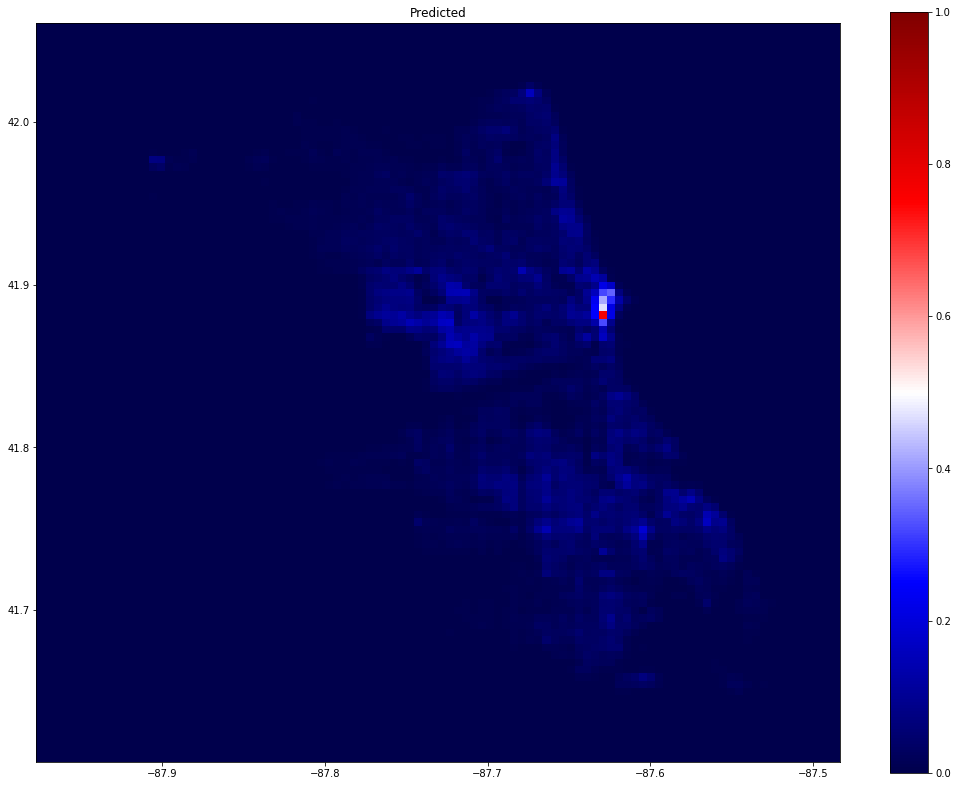

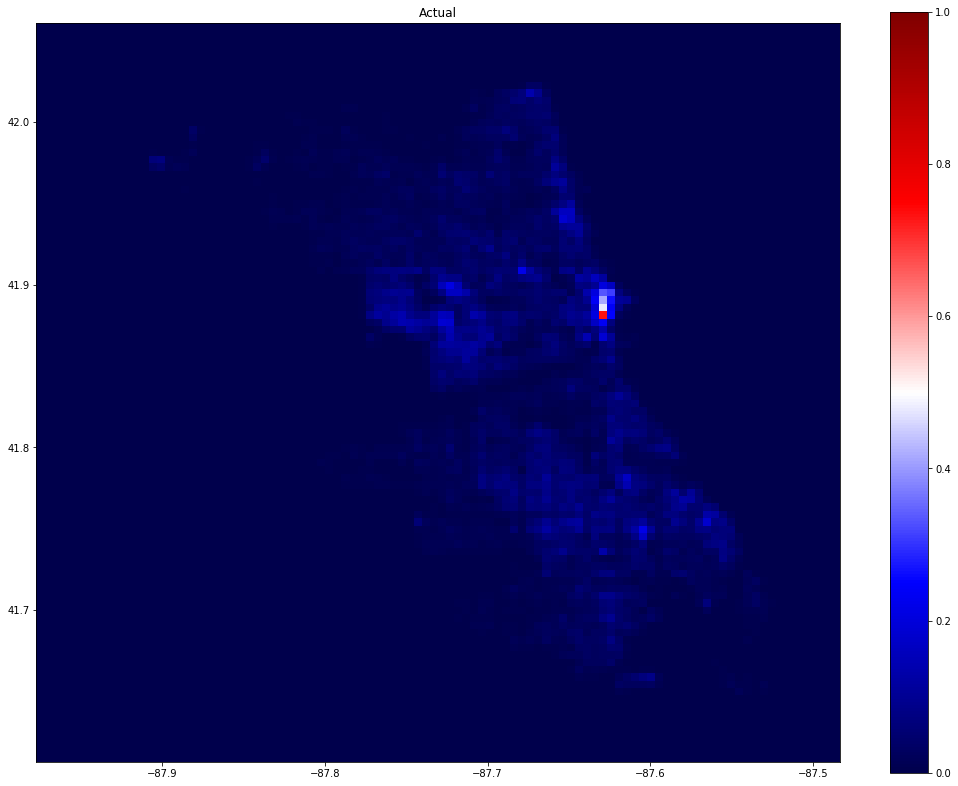

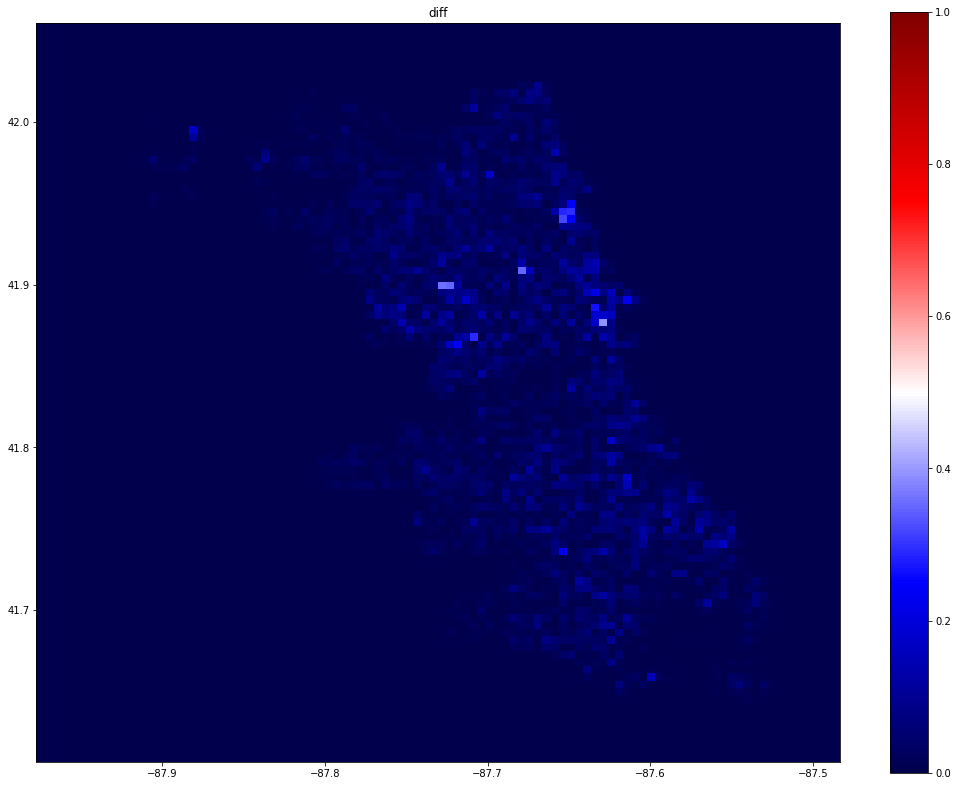

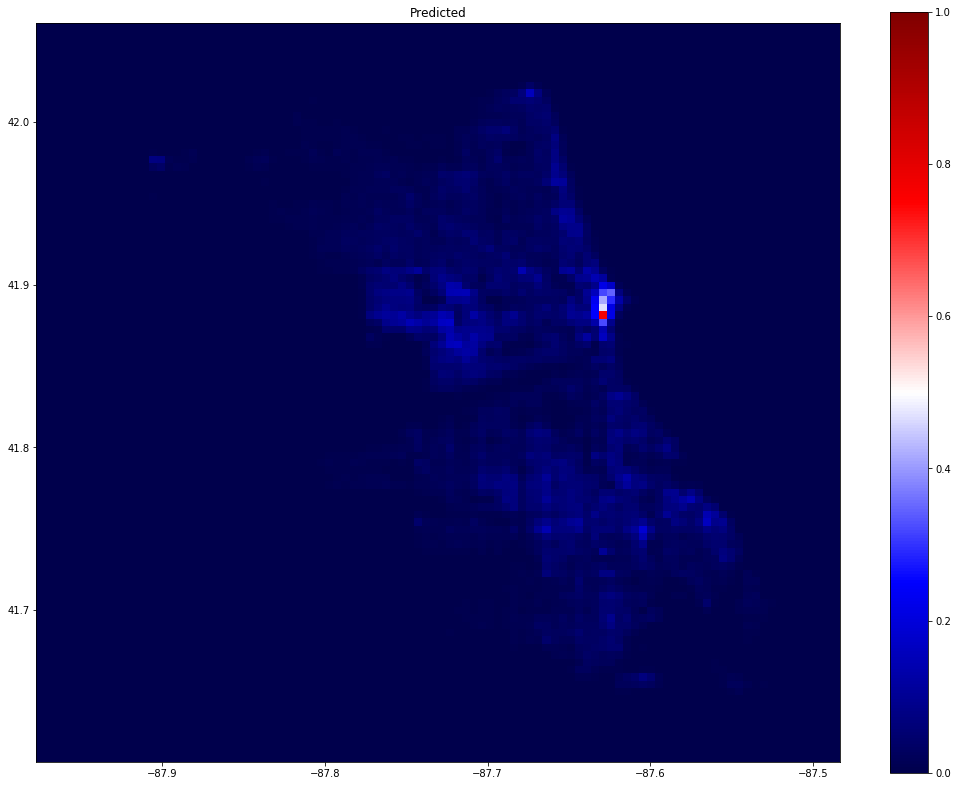

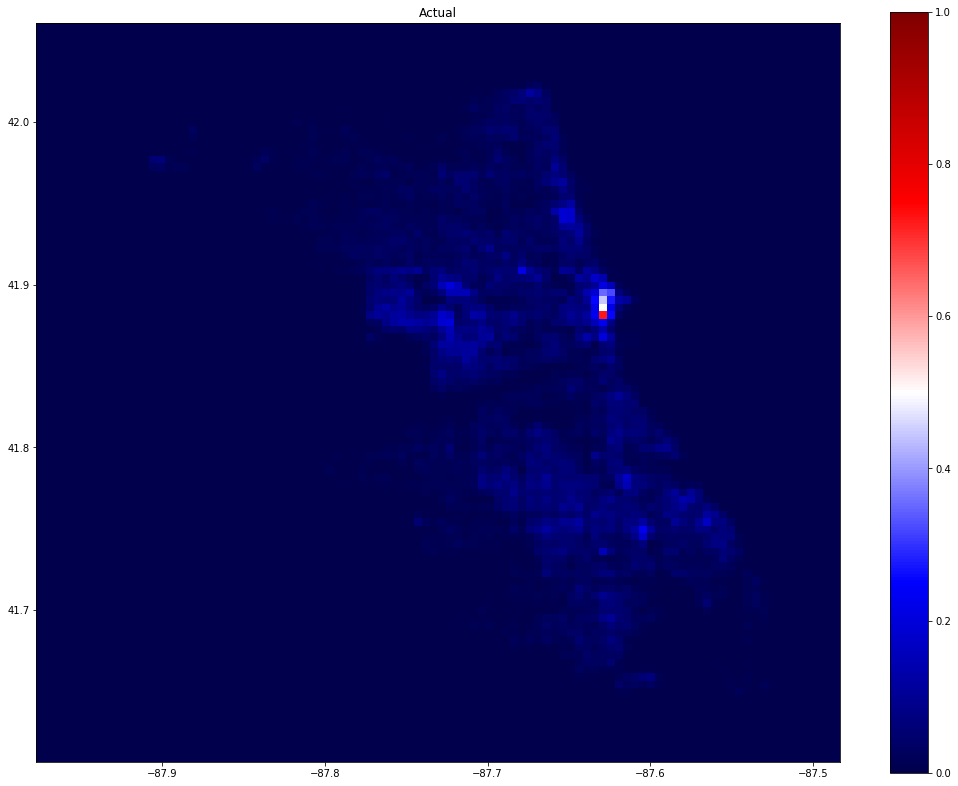

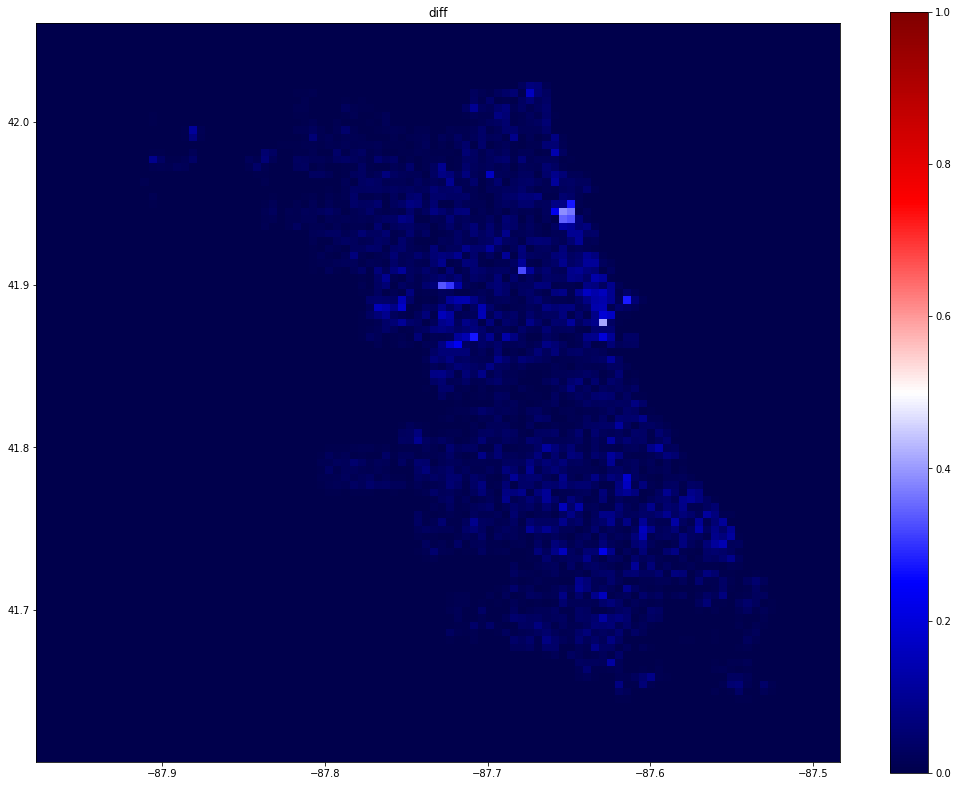

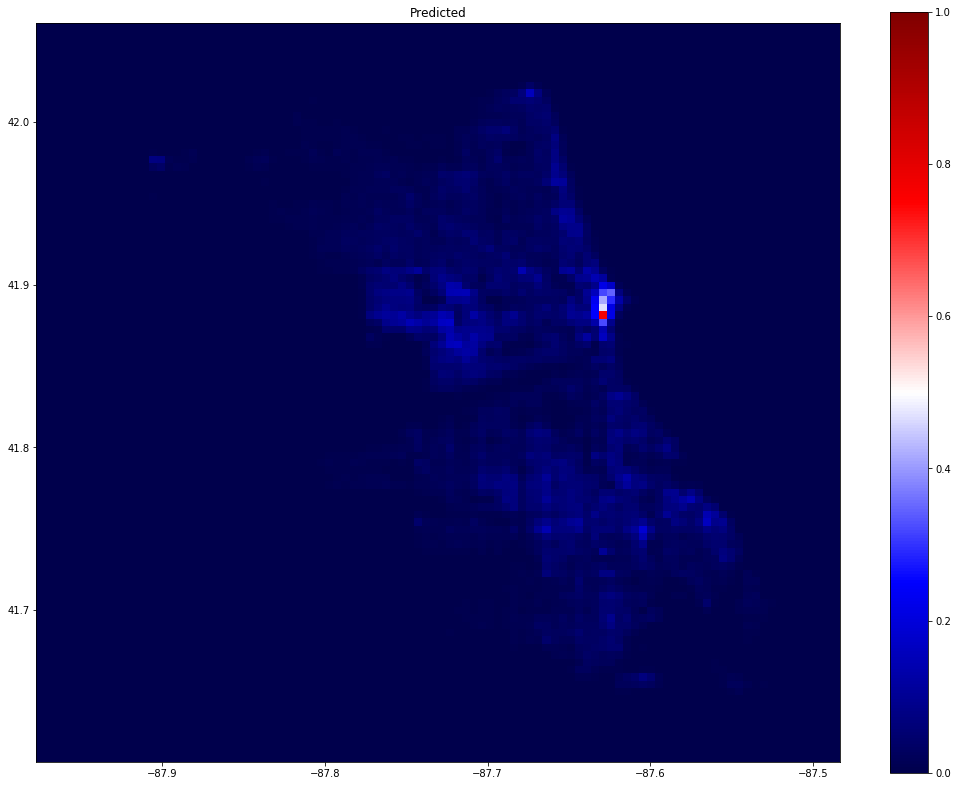

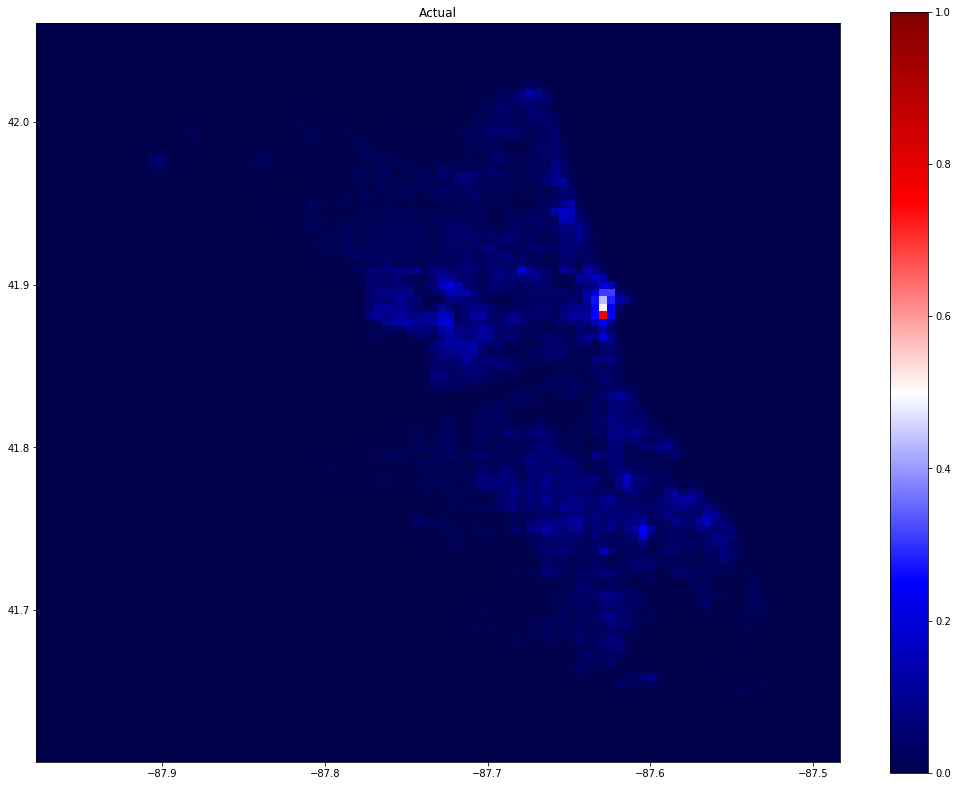

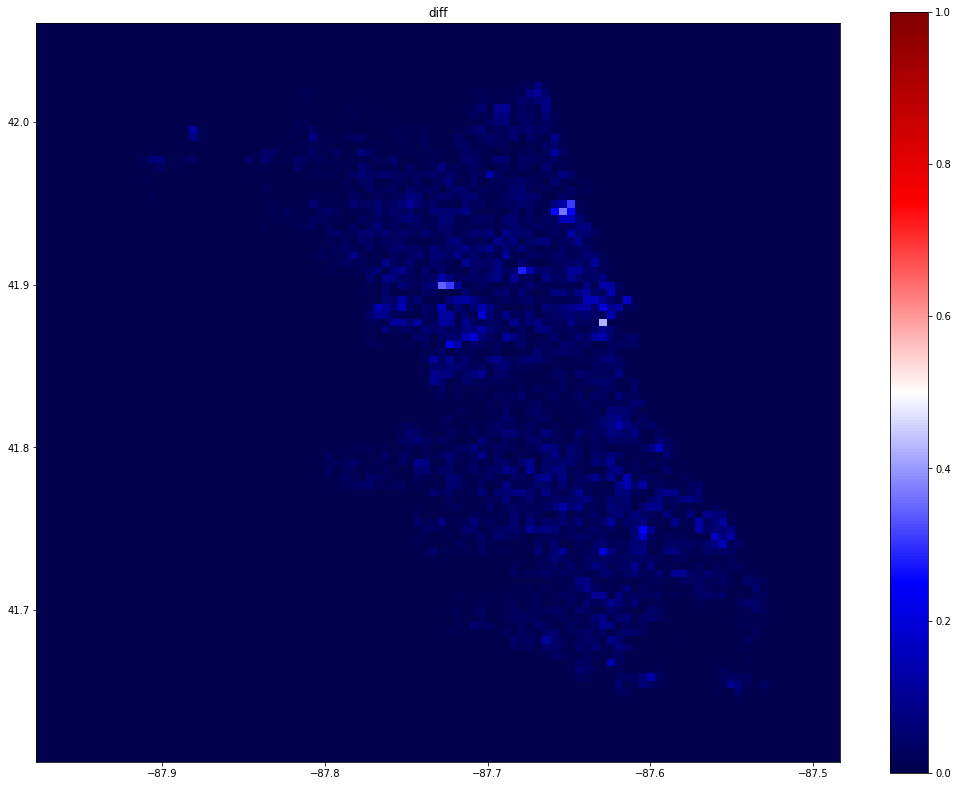

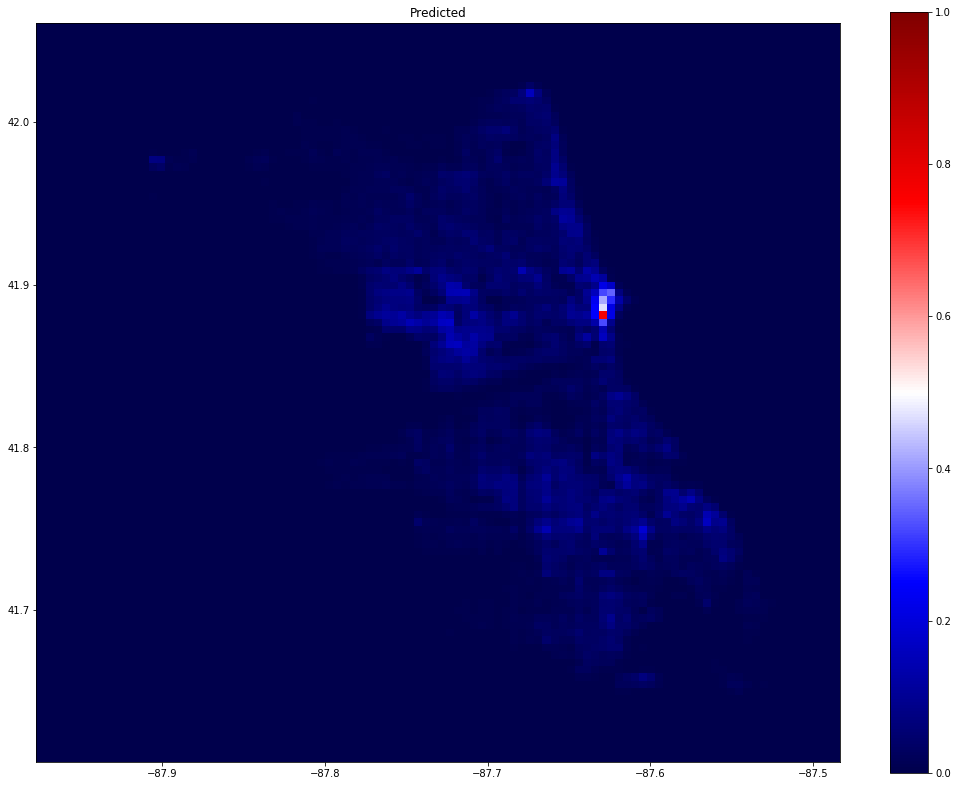

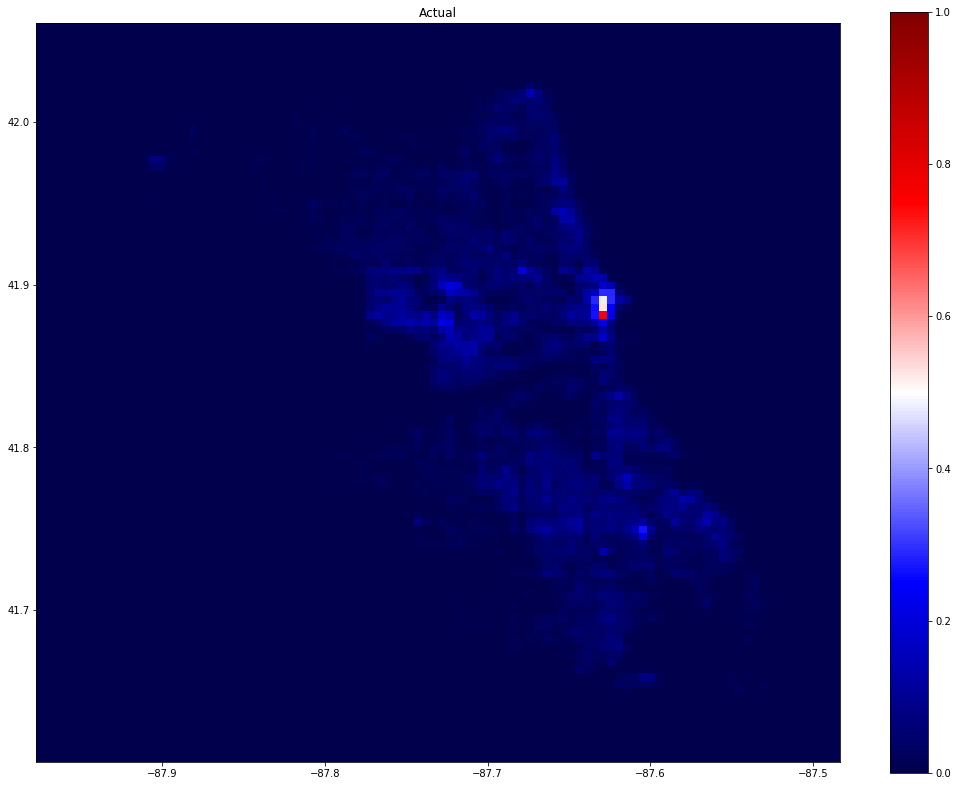

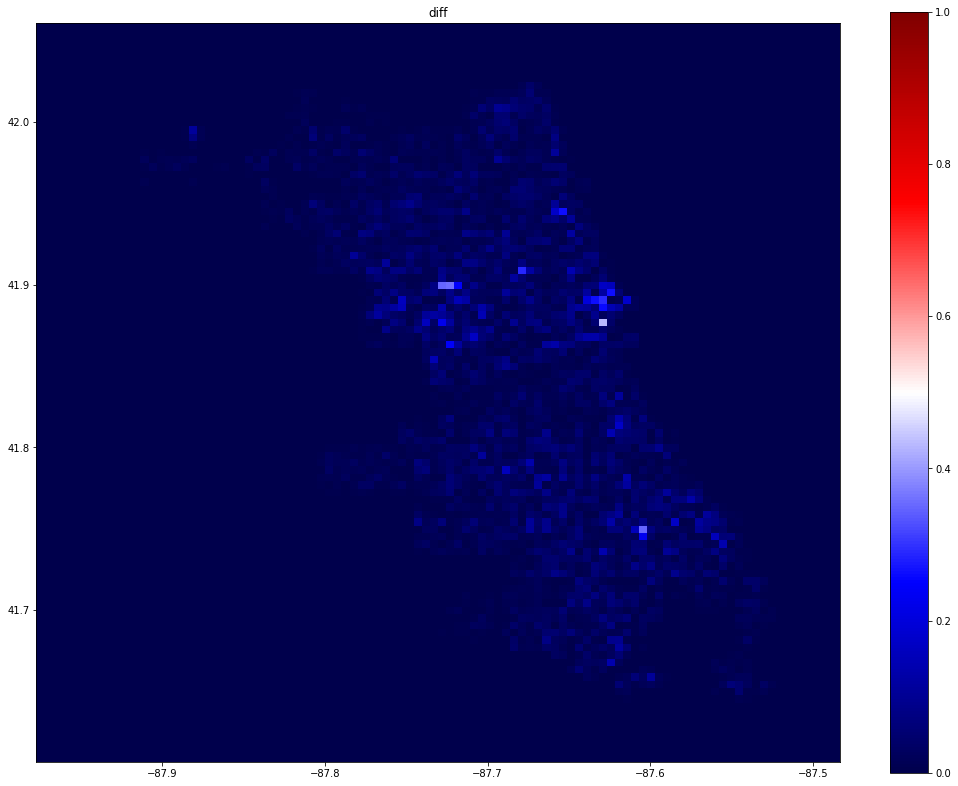

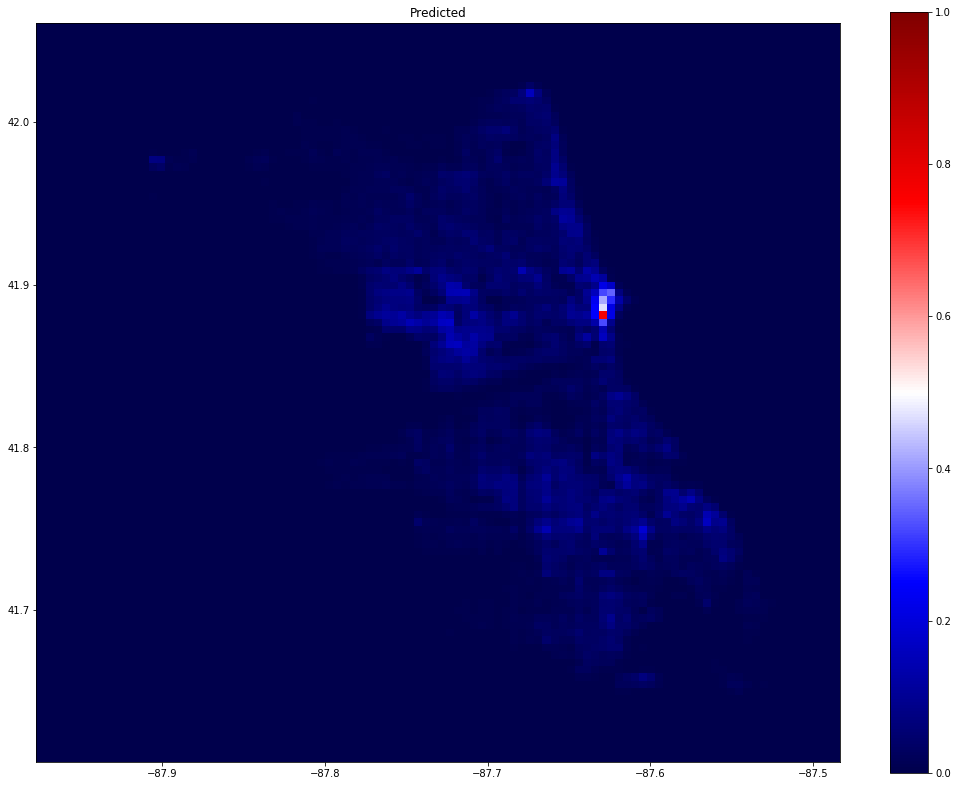

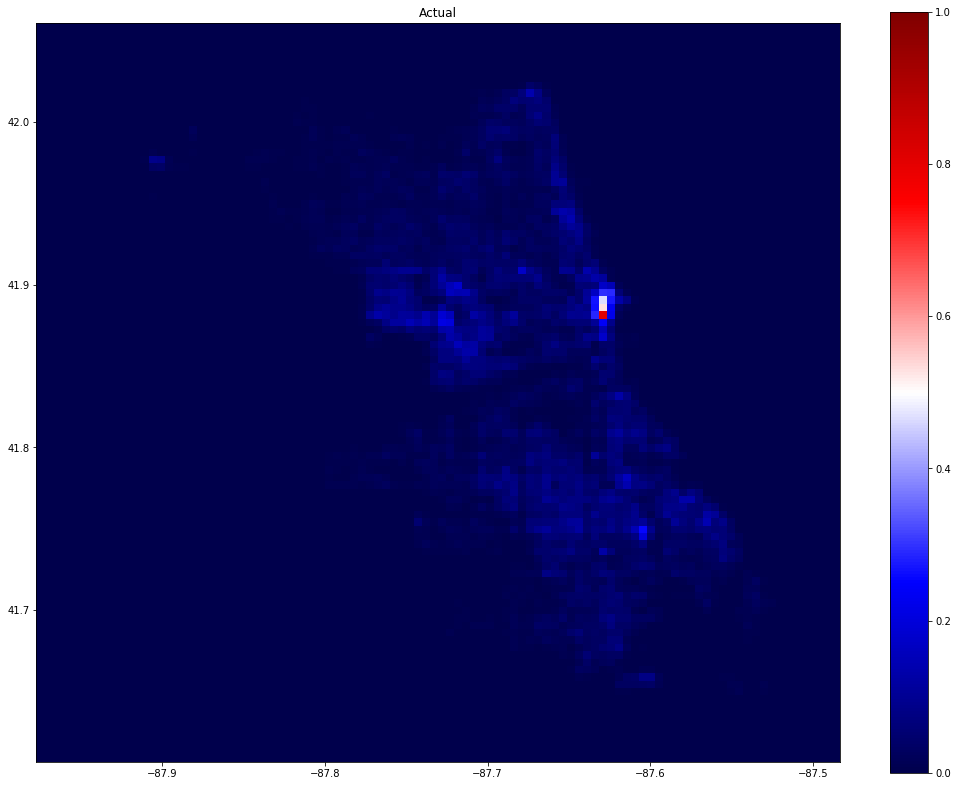

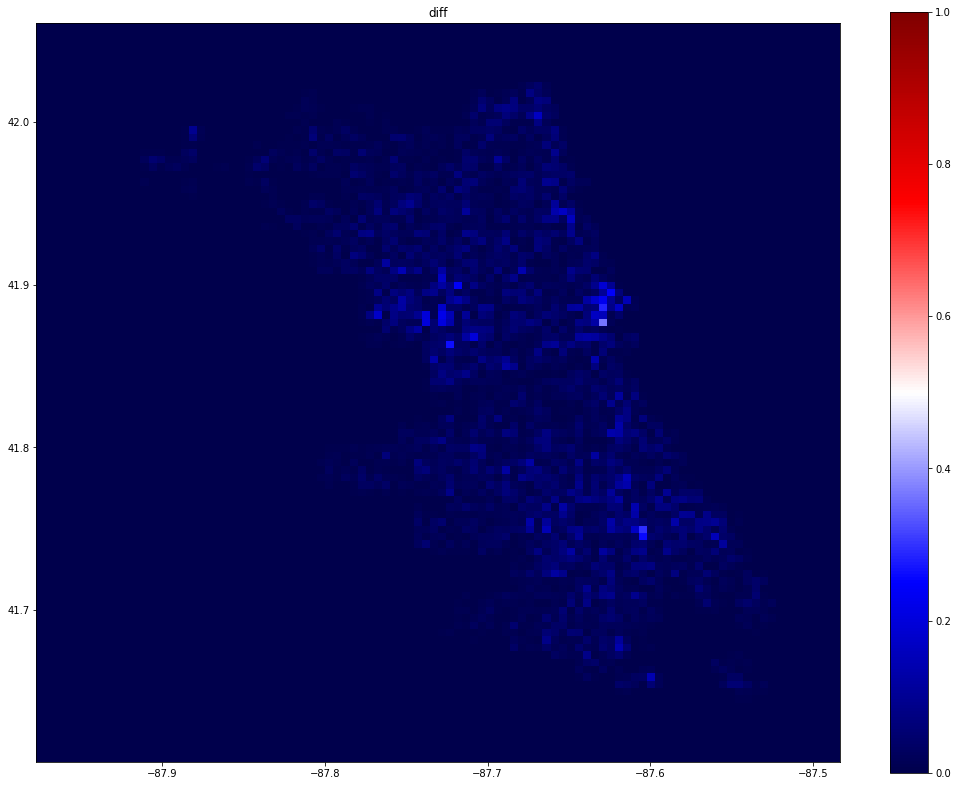

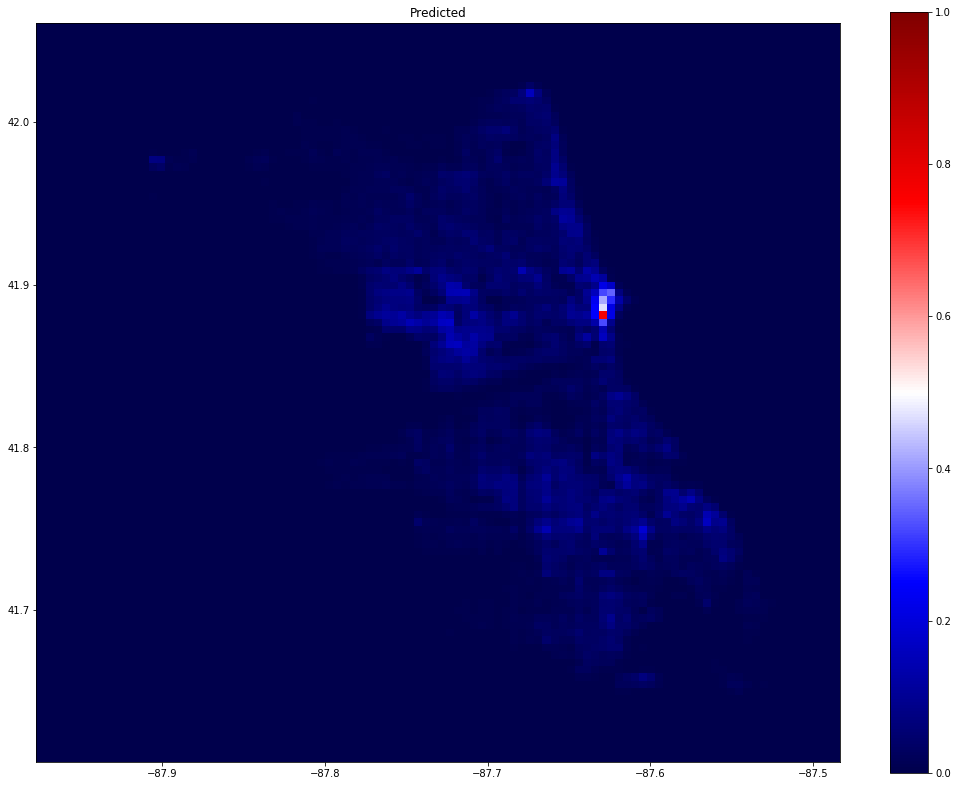

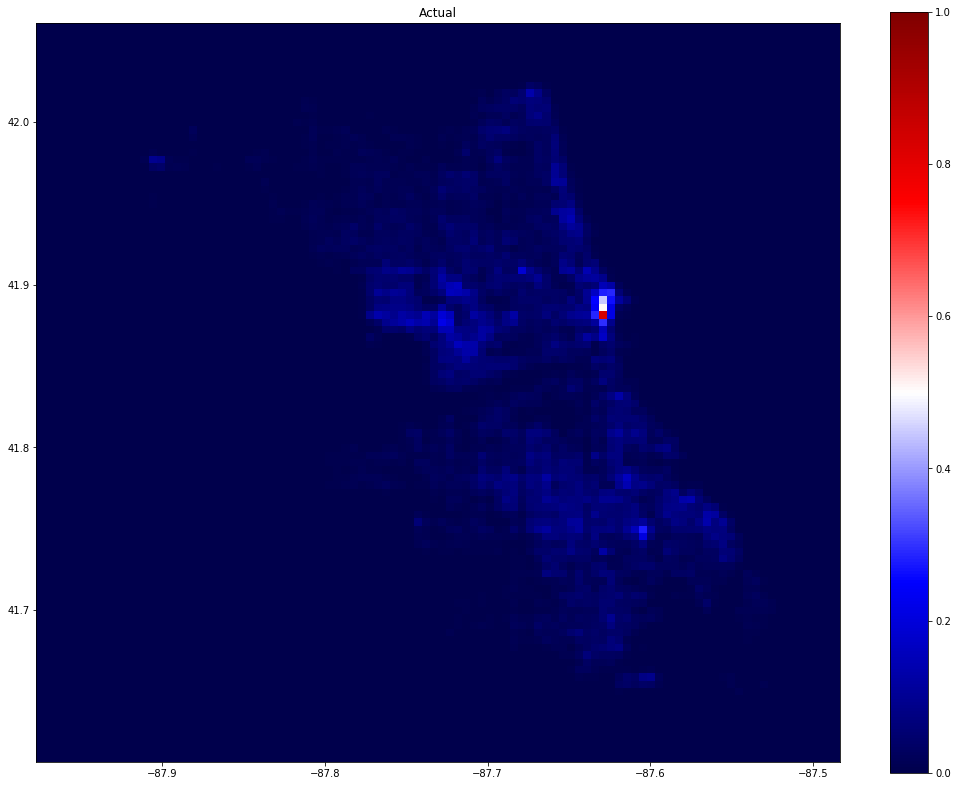

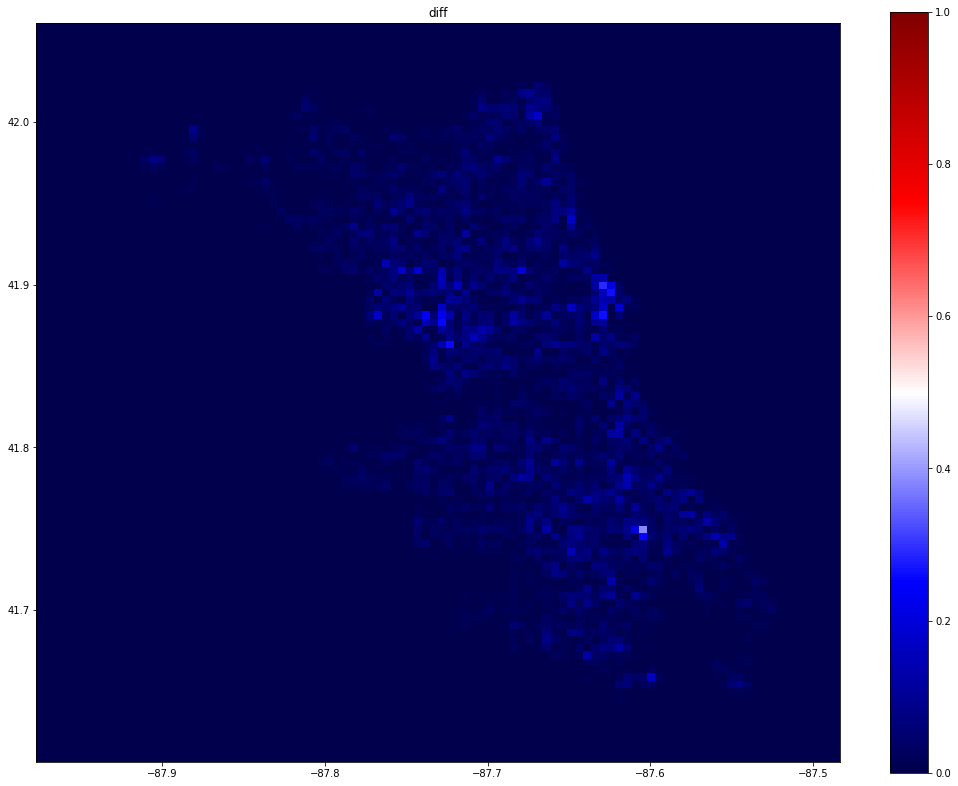

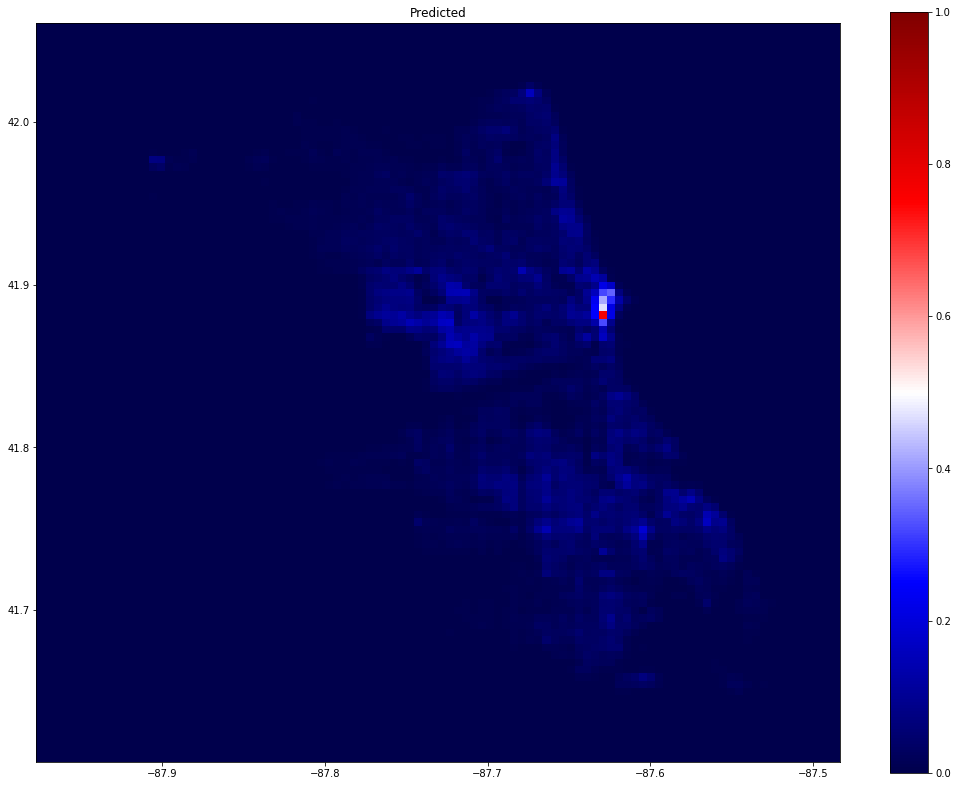

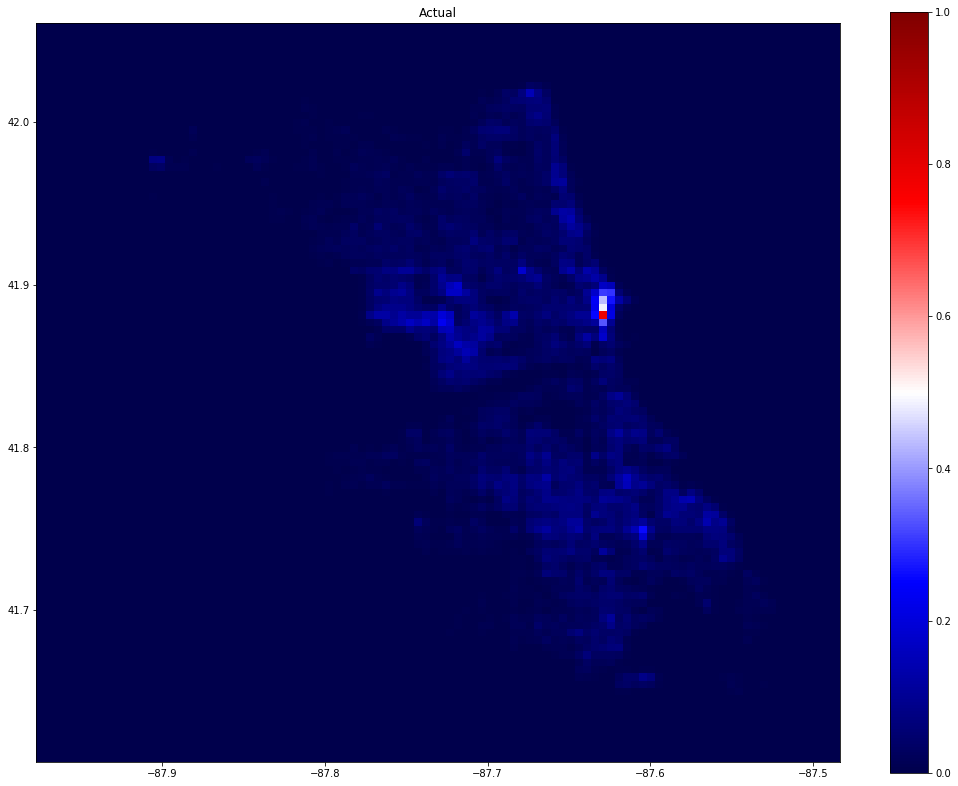

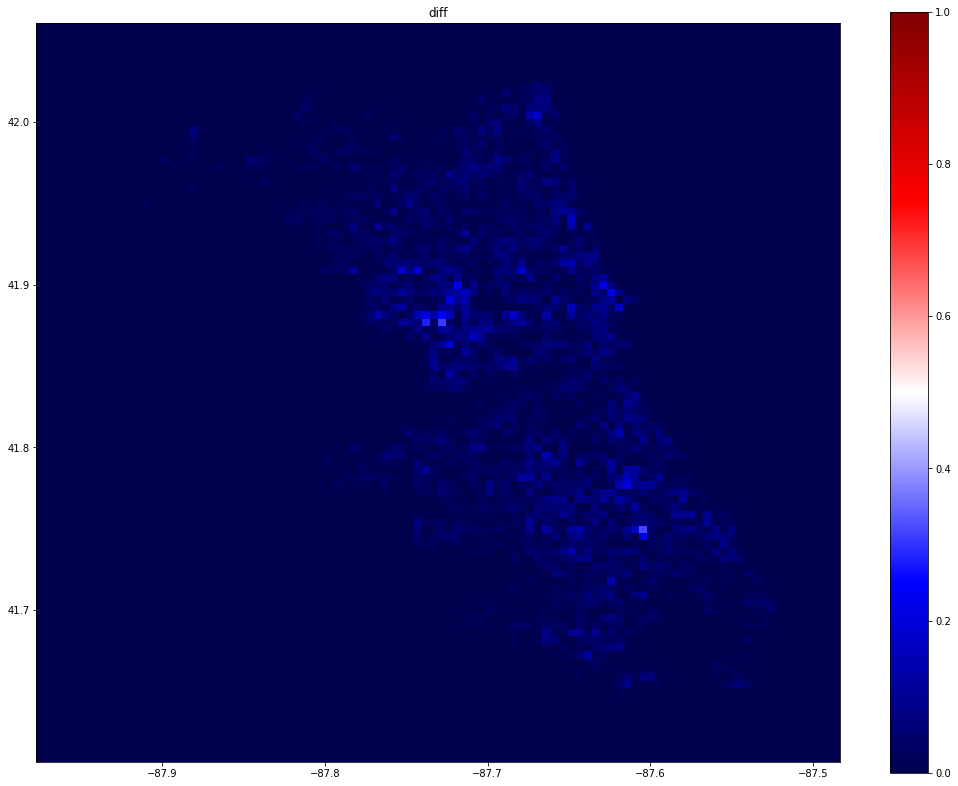

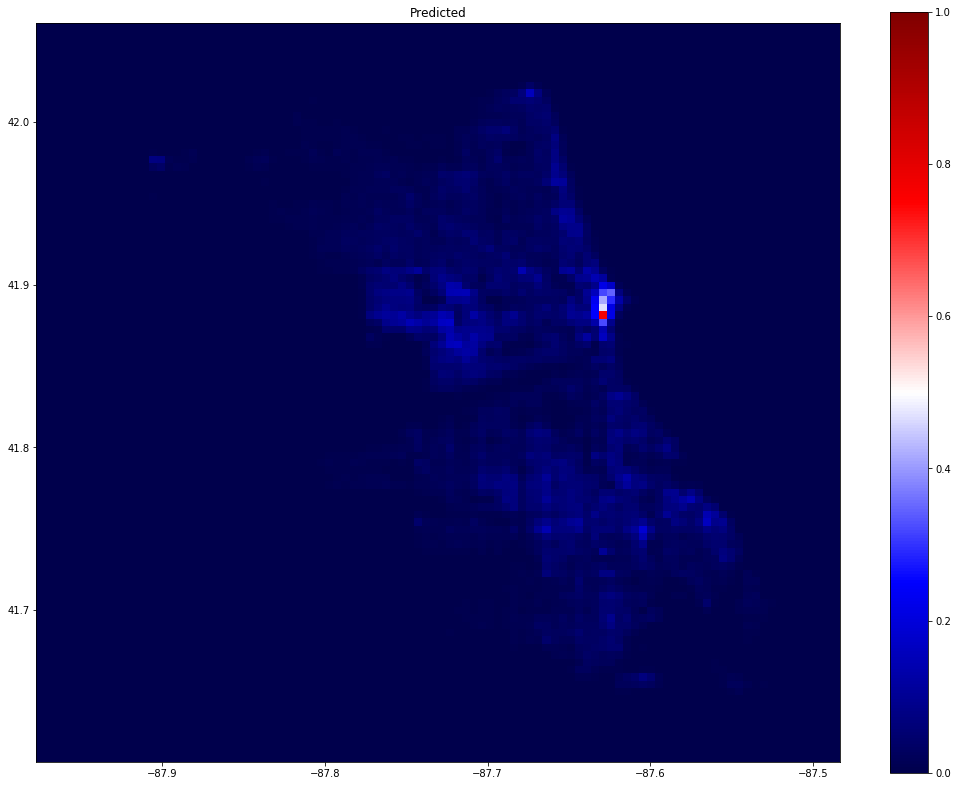

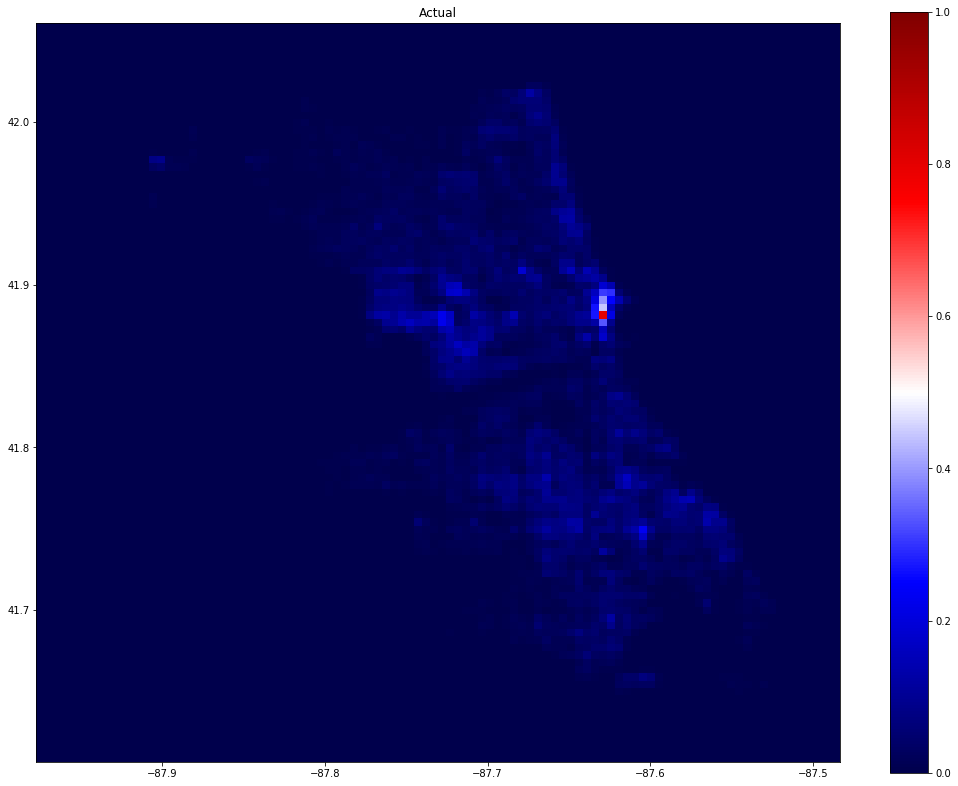

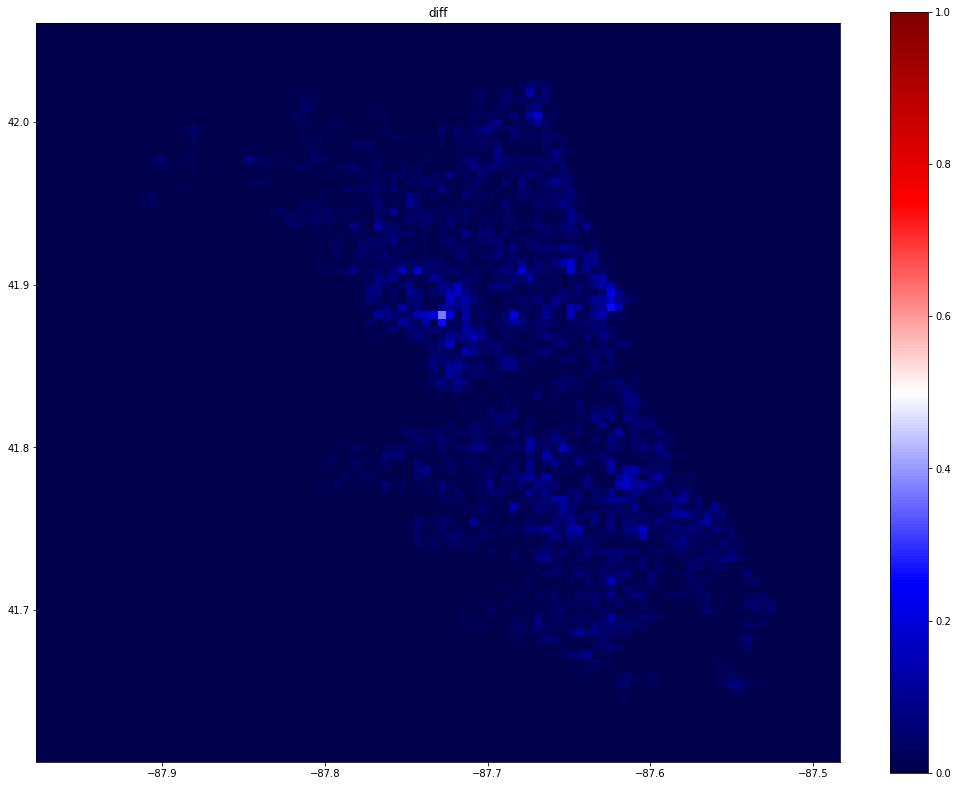

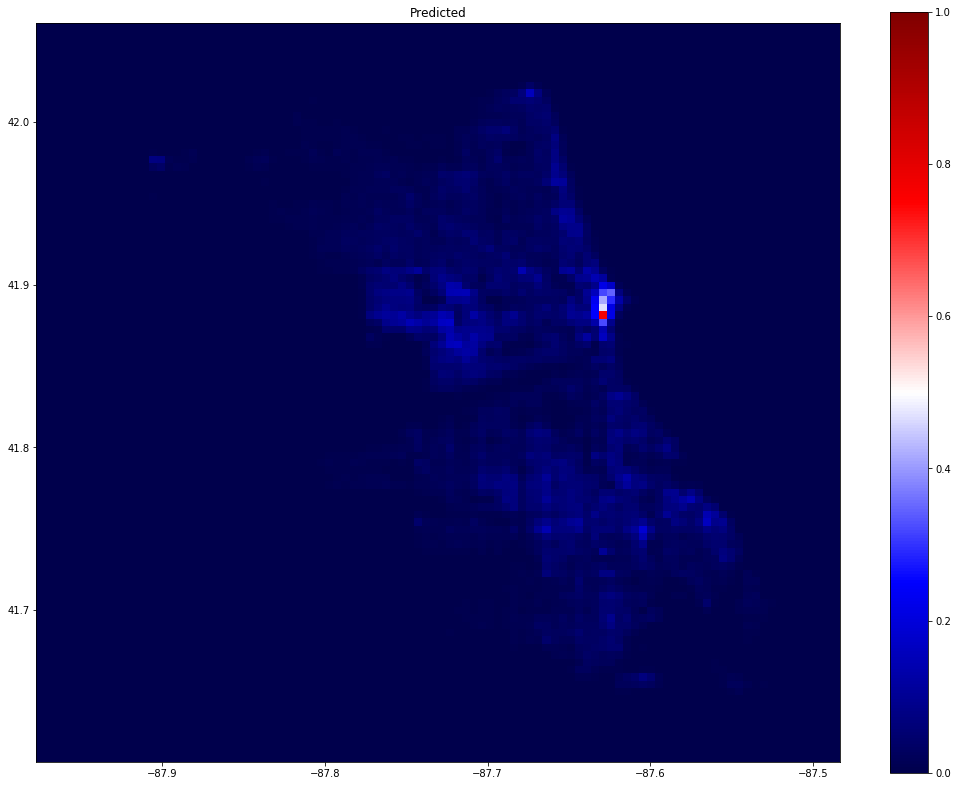

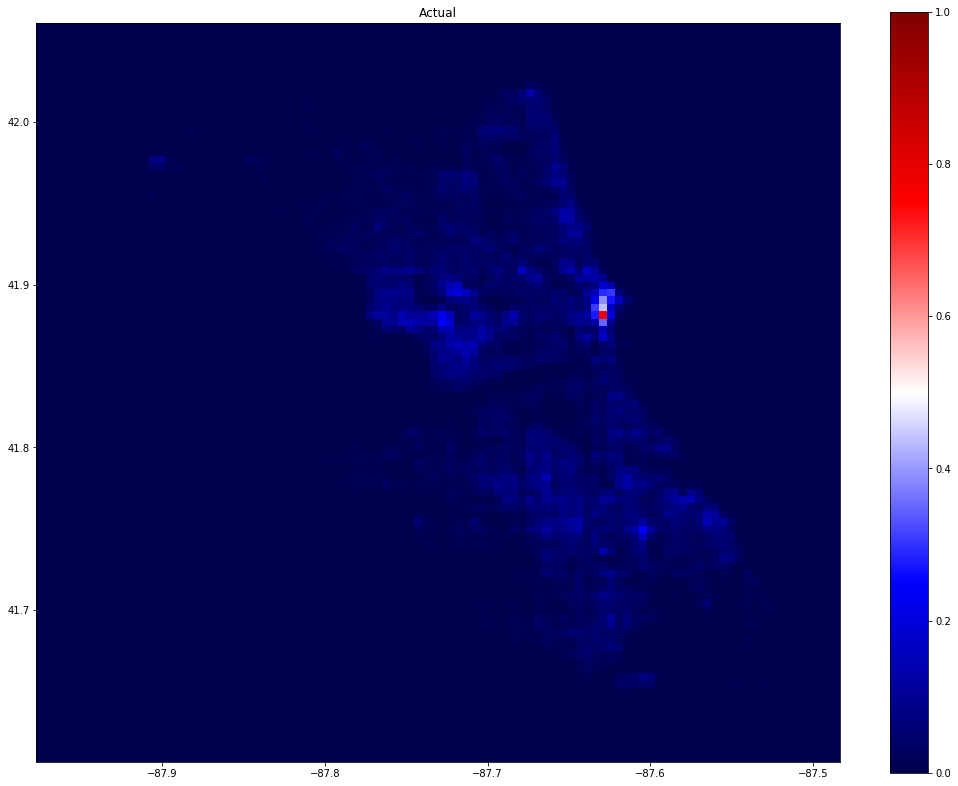

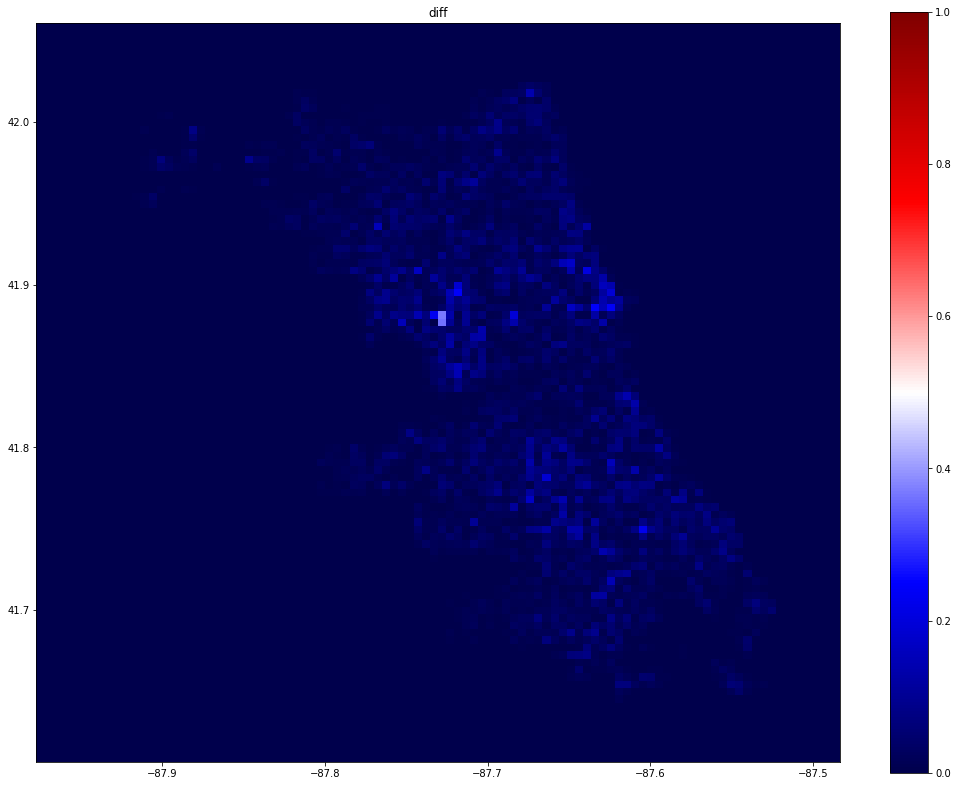

In [270]:
import matplotlib.pyplot as plt
grid_size = 500
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

for timeStepFromLast in range(Y_valid.shape[0]):
    plt.figure(figsize=(18, 14))
    plt.title('Predicted')
    plt.imshow( X=reshapePred(Predict,timeStepFromLast),vmax=vmax,vmin=vmin, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    
    plt.figure(figsize=(18, 14))
    plt.title('Actual')
    plt.imshow( X=reshapePred(Y_valid,timeStepFromLast ),vmax=vmax,vmin=vmin, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()
    
    diff = np.abs(reshapePred(Predict,timeStepFromLast)-reshapePred(Y_valid,timeStepFromLast ))
    plt.figure(figsize=(18, 14))
    plt.title('diff')
    plt.imshow( X=scaleDiff(diff,diff_max,diff_min),vmax=1,vmin=0, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
    plt.colorbar()

#### We plot the difference between prediction and target

In [255]:
diff = (reshapePred(Y_valid,3)-reshapePred(Predict,3))
diff.shape

(100, 100)

In [256]:
diff_max = np.max(diff)
diff_min = np.min(diff)
scaled_diff = (diff - diff_min)/(diff_max - diff_min)

In [257]:
np.max(scaled_diff)

1.0

In [258]:
diff

array([[-1.64879384e-06, -3.94163180e-07, -3.94163180e-07, ...,
         1.81284850e-06,  3.94163180e-07, -3.94163180e-07],
       [-1.64875746e-06, -3.94163180e-07, -3.94163180e-07, ...,
         3.94163180e-07,  3.94163180e-07,  3.94163180e-07],
       [ 3.94163180e-07, -1.81284850e-06, -3.94163180e-07, ...,
        -3.94163180e-07, -3.94163180e-07, -3.94163180e-07],
       ...,
       [ 3.94163180e-07,  3.94163180e-07,  3.94163180e-07, ...,
         1.81284850e-06,  3.94163180e-07,  1.81284850e-06],
       [-3.94163180e-07,  3.94163180e-07,  1.64879384e-06, ...,
        -1.64879384e-06,  1.81284850e-06,  3.94163180e-07],
       [ 3.94163180e-07,  3.94163180e-07,  3.94163180e-07, ...,
         3.94163180e-07, -3.94163180e-07, -1.81284850e-06]])

In [263]:
vmax, vmin = np.max(scaled_diff), np.min(scaled_diff)

In [264]:
vmax, vmin 

(1.0, 0.0)

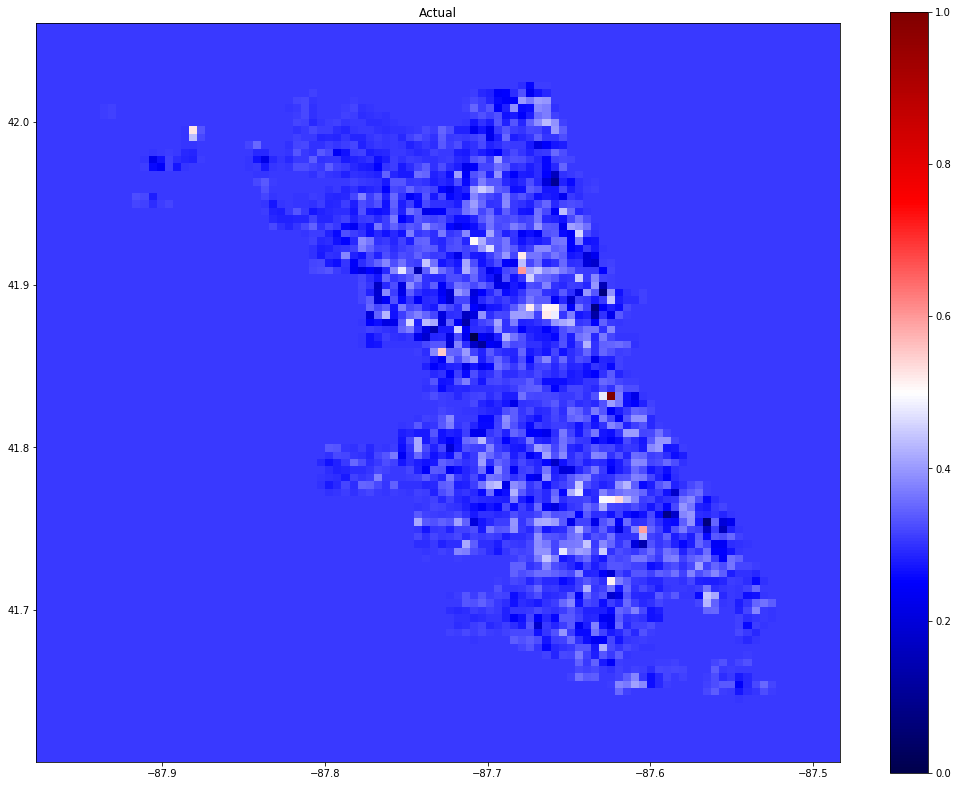

In [265]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=scaled_diff,vmax=vmax, vmin=vmin, cmap=plt.cm.seismic, extent=[xmin, xmax, ymin, ymax])
plt.colorbar()

#### Note the differences is scaled, red means extreme differences inplot above. Interestingly we see the extreme differences is at the highest crime areas.